# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")  # ignore runtime warning

# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   
3                      1                 2  ...         2.0         2.0   
4                      3                 2  ...         2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. **Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.** You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

=> Total records: 891221
=> Null values: 4896838
=> Number of Duplicated values: 52494


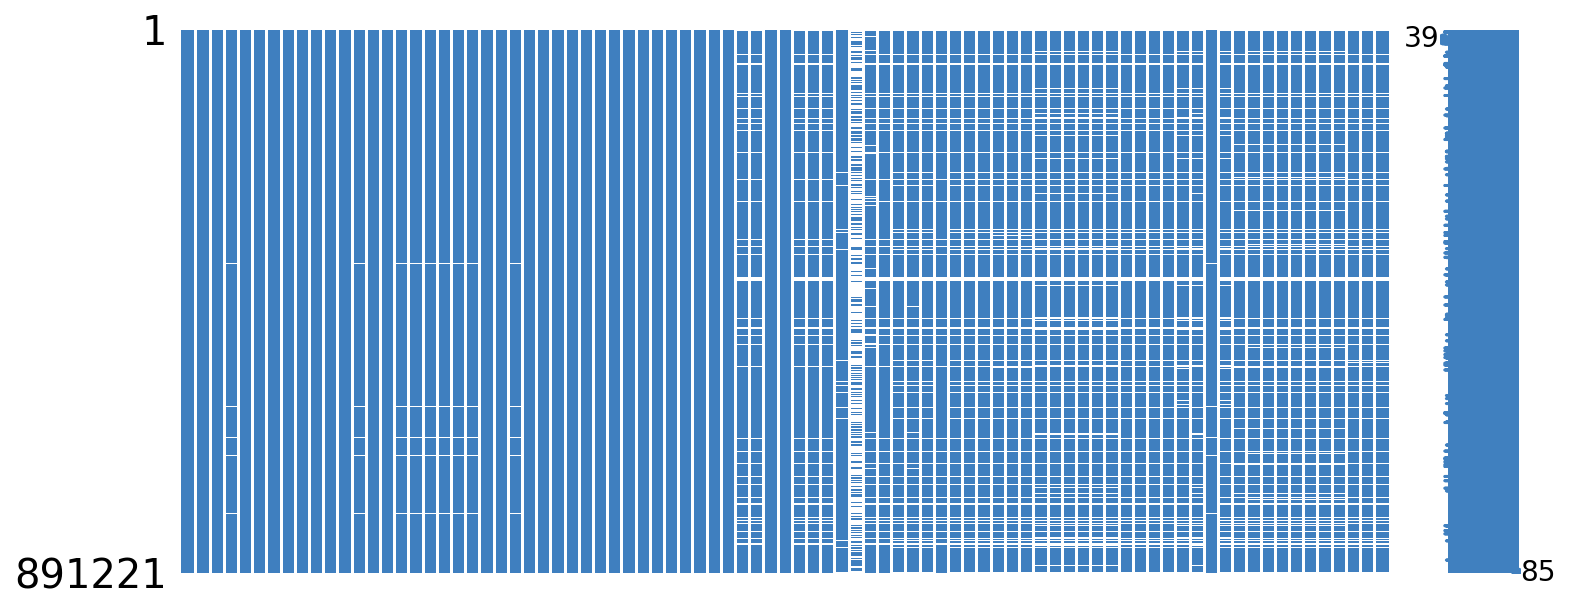

In [8]:
# initial check about missing and duplicated data
import missingno as msno
df = azdias.copy()
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"=> Total records: {df.shape[0]}")
print(f"=> Null values: {df.isna().sum().sum()}")
print(f"=> Number of Duplicated values: {df.duplicated().sum()}")

In [9]:
converted = []
for i in range(feat_info['missing_or_unknown'].shape[0]):
    
    # parsing: convert str into int except when containing str value, e.g. X 
    if feat_info['missing_or_unknown'][i] == '[]':
        converted.append(list(map(int, feat_info['missing_or_unknown'][i].strip('[]'))))
    else:
        try:
            converted.append(list(map(int, feat_info['missing_or_unknown'][i].strip('[]').split(','))))
        except:
            converted.append(list(map(str, feat_info['missing_or_unknown'][i].strip('[]').split(','))))    
            
feat_info['missing_or_unknown'] = converted

Do not run below cell due to iteration of the cleaning process

In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [11]:
from tqdm.notebook import tqdm
for column in azdias.columns:
    print(f'Converting column name: {column}')
    converted = []
    for i in tqdm(range(azdias[column].shape[0])):
        if azdias[column][i] in feat_info[feat_info['attribute'] == column].missing_or_unknown.tolist()[0]:
            converted.append(np.NaN)
        else:
            converted.append(azdias[column][i])            
    azdias[column] = converted

# export data
azdias.to_csv('azdias_null_cleaned.csv', index = False)

Converting column name: AGER_TYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ALTERSKATEGORIE_GROB


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ANREDE_KZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: CJT_GESAMTTYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZ_MINIMALIST


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZ_SPARER


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZ_VORSORGER


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZ_ANLEGER


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZ_UNAUFFAELLIGER


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZ_HAUSBAUER


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: FINANZTYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: GEBURTSJAHR


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: GFK_URLAUBERTYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: GREEN_AVANTGARDE


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: HEALTH_TYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: LP_LEBENSPHASE_FEIN


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: LP_LEBENSPHASE_GROB


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: LP_FAMILIE_FEIN


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: LP_FAMILIE_GROB


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: LP_STATUS_FEIN


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: LP_STATUS_GROB


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: NATIONALITAET_KZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PRAEGENDE_JUGENDJAHRE


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: RETOURTYP_BK_S


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_SOZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_FAM


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_REL


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_MAT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_VERT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_LUST


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_ERL


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_KULT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_RAT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_KRIT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_DOM


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_KAEM


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_PFLICHT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SEMIO_TRADV


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SHOPPER_TYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: SOHO_KZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: TITEL_KZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: VERS_TYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ZABEOTYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ALTER_HH


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ANZ_PERSONEN


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ANZ_TITEL


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: HH_EINKOMMEN_SCORE


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KK_KUNDENTYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: W_KEIT_KIND_HH


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: WOHNDAUER_2008


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ANZ_HAUSHALTE_AKTIV


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ANZ_HH_TITEL


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: GEBAEUDETYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KONSUMNAEHE


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: MIN_GEBAEUDEJAHR


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: OST_WEST_KZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: WOHNLAGE


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: CAMEO_DEUG_2015


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: CAMEO_DEU_2015


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: CAMEO_INTL_2015


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG1


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG2


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG3


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG4


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA05_BAUMAX


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA05_GBZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: BALLRAUM


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: EWDICHTE


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: INNENSTADT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: GEBAEUDETYP_RASTER


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KKK


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: MOBI_REGIO


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ONLINE_AFFINITAET


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: REGIOTYP


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: KBA13_ANZAHL_PKW


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG1


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG2


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG3


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG4


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_BAUMAX


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_HHZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: PLZ8_GBZ


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ARBEIT


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: ORTSGR_KLS9


  0%|          | 0/891221 [00:00<?, ?it/s]

Converting column name: RELAT_AB


  0%|          | 0/891221 [00:00<?, ?it/s]

In [12]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

In [13]:
azdias_cleaned = azdias.copy()

- verify the result with each format of columns

In [15]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [16]:
# get the name of types

verify_type_list = []
for i in range(5):
    verify_type_list.append(feat_info.type.value_counts().reset_index()['index'][i])
print(verify_type_list)

['ordinal', 'categorical', 'numeric', 'mixed', 'interval']


In [17]:
# get the name of the sample column per type to verify
verify_column_list = []
for i in verify_type_list:
    column_pick = feat_info[feat_info.type == i].sample(1).attribute.values[0]
    print(f'Type: {i} --- Column(picked randomly) => {column_pick }')
    verify_column_list.append(column_pick)
print('\n', verify_column_list)

Type: ordinal --- Column(picked randomly) => SEMIO_ERL
Type: categorical --- Column(picked randomly) => CJT_GESAMTTYP
Type: numeric --- Column(picked randomly) => MIN_GEBAEUDEJAHR
Type: mixed --- Column(picked randomly) => WOHNLAGE
Type: interval --- Column(picked randomly) => ALTER_HH

 ['SEMIO_ERL', 'CJT_GESAMTTYP', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'ALTER_HH']


In [18]:
for column in verify_column_list:
    missing_unknown = feat_info[feat_info['attribute'] == column].missing_or_unknown.tolist()[0]
    print(f'\n\nVerifying Column: {column}')    
    print(f'> missing or unknown list: {missing_unknown}')
    c = 1
    for i in azdias_cleaned[column].values:
#         print(f'Line number: {c} Value: {i} Missing or Unknown{missing_unknown}', end = '     \r')
        if i == np.NaN:
            pass
        elif i in missing_unknown:
            print(f'The column is not verified. Error attribute: {i}')
            break
        else:
            pass
        c+=1
    print(f'>> {column}: is verified.')
print('\n\n\n==> Verification has been done.')



Verifying Column: SEMIO_ERL
> missing or unknown list: [-1, 9]
>> SEMIO_ERL: is verified.


Verifying Column: CJT_GESAMTTYP
> missing or unknown list: [0]
>> CJT_GESAMTTYP: is verified.


Verifying Column: MIN_GEBAEUDEJAHR
> missing or unknown list: [0]
>> MIN_GEBAEUDEJAHR: is verified.


Verifying Column: WOHNLAGE
> missing or unknown list: [-1]
>> WOHNLAGE: is verified.


Verifying Column: ALTER_HH
> missing or unknown list: [0]
>> ALTER_HH: is verified.



==> Verification has been done.


=> Total records: 891221
=> Null values: 8373929
=> Number of Duplicated values: 52494


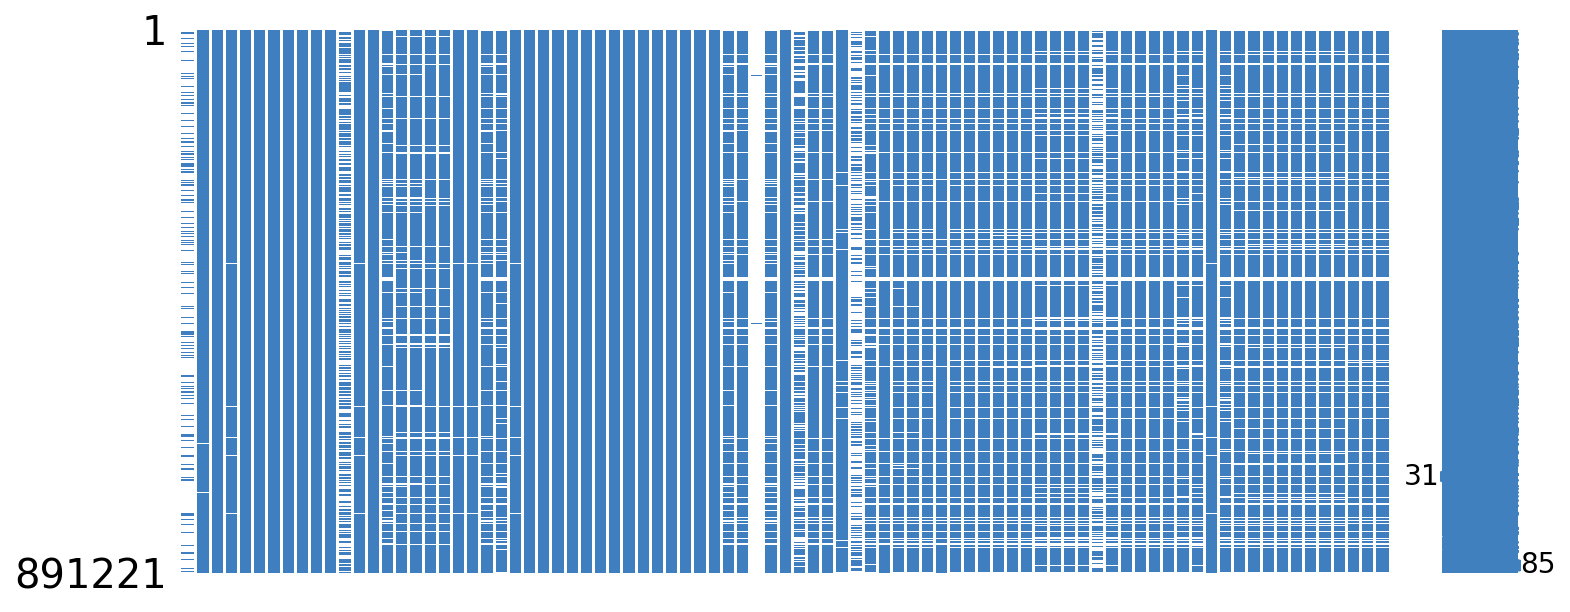

In [19]:
# check missing and duplicated data
df = azdias_cleaned.copy()
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"=> Total records: {df.shape[0]}")
print(f"=> Null values: {df.isna().sum().sum()}")
print(f"=> Number of Duplicated values: {df.duplicated().sum()}")

In [20]:
# save the original file as the cleaned ver.1
azdias = azdias_cleaned.copy()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

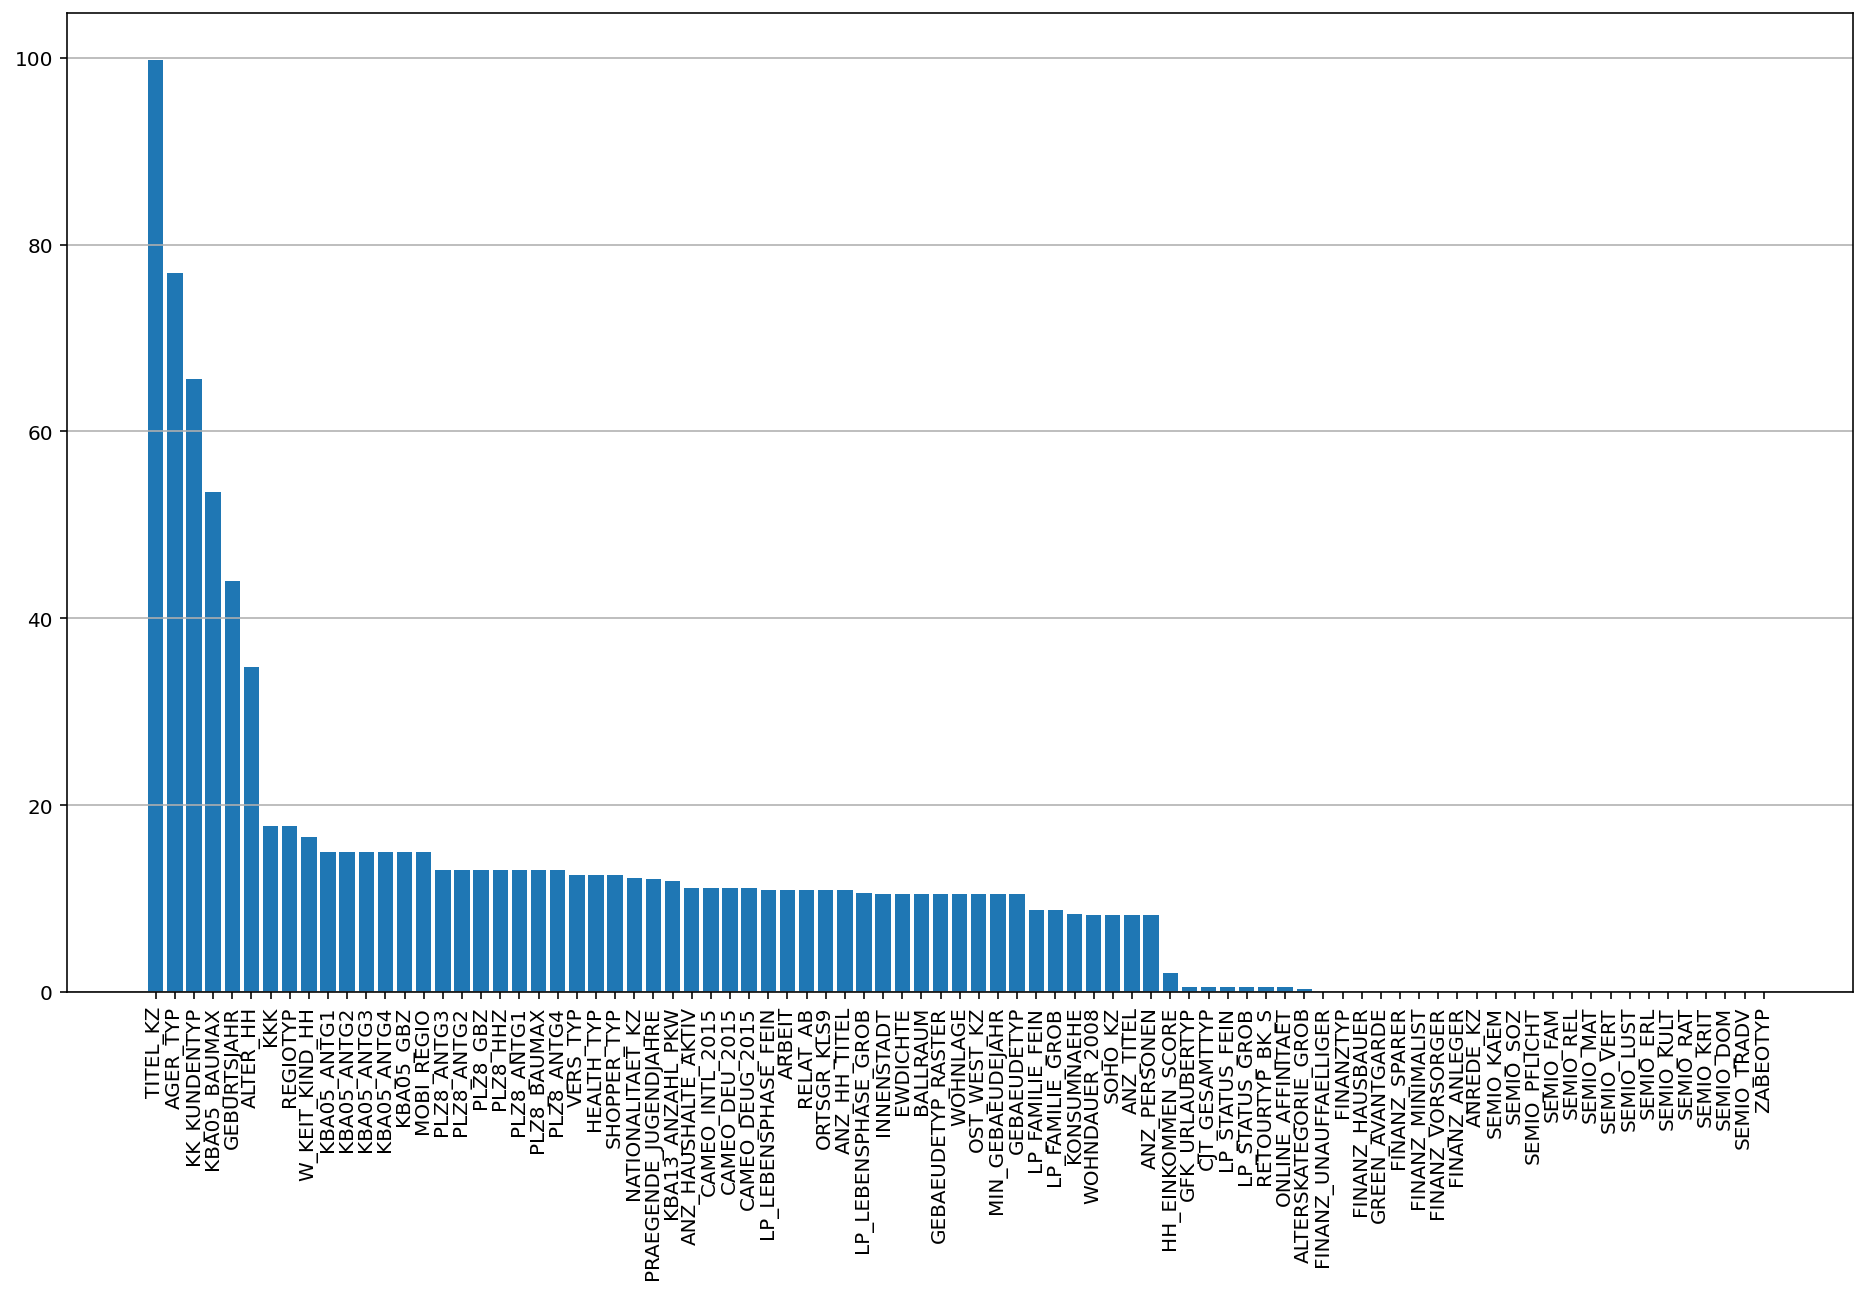

null_ratio
TITEL_KZ         99.757636
AGER_TYP         76.955435
KK_KUNDENTYP     65.596749
KBA05_BAUMAX     53.468668
GEBURTSJAHR      44.020282
ALTER_HH         34.813699
KKK              17.735668
REGIOTYP         17.735668
W_KEIT_KIND_HH   16.605084
KBA05_ANTG1      14.959701

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# get null percentage per column
null_list = {}
for column in azdias.columns:
    total = azdias[column].shape[0]
    missing = azdias[column].isna().sum()
    missing_percent = missing/total*100
    null_list[column] = missing_percent
    
null_ratio = pd.DataFrame([null_list]).T.rename(columns = {0:'null_ratio'})
null_ratio = null_ratio.sort_values('null_ratio', ascending = False)

# bar plot
plt.figure(figsize = (16,9))
plt.bar(null_ratio.index, null_ratio.null_ratio)
plt.xticks(rotation = 90)
plt.grid(axis = 'y')
plt.show()

null_ratio.head(10)

In [22]:
null_columns = null_ratio[null_ratio['null_ratio'] > 20].index.values.tolist()
null_columns 

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

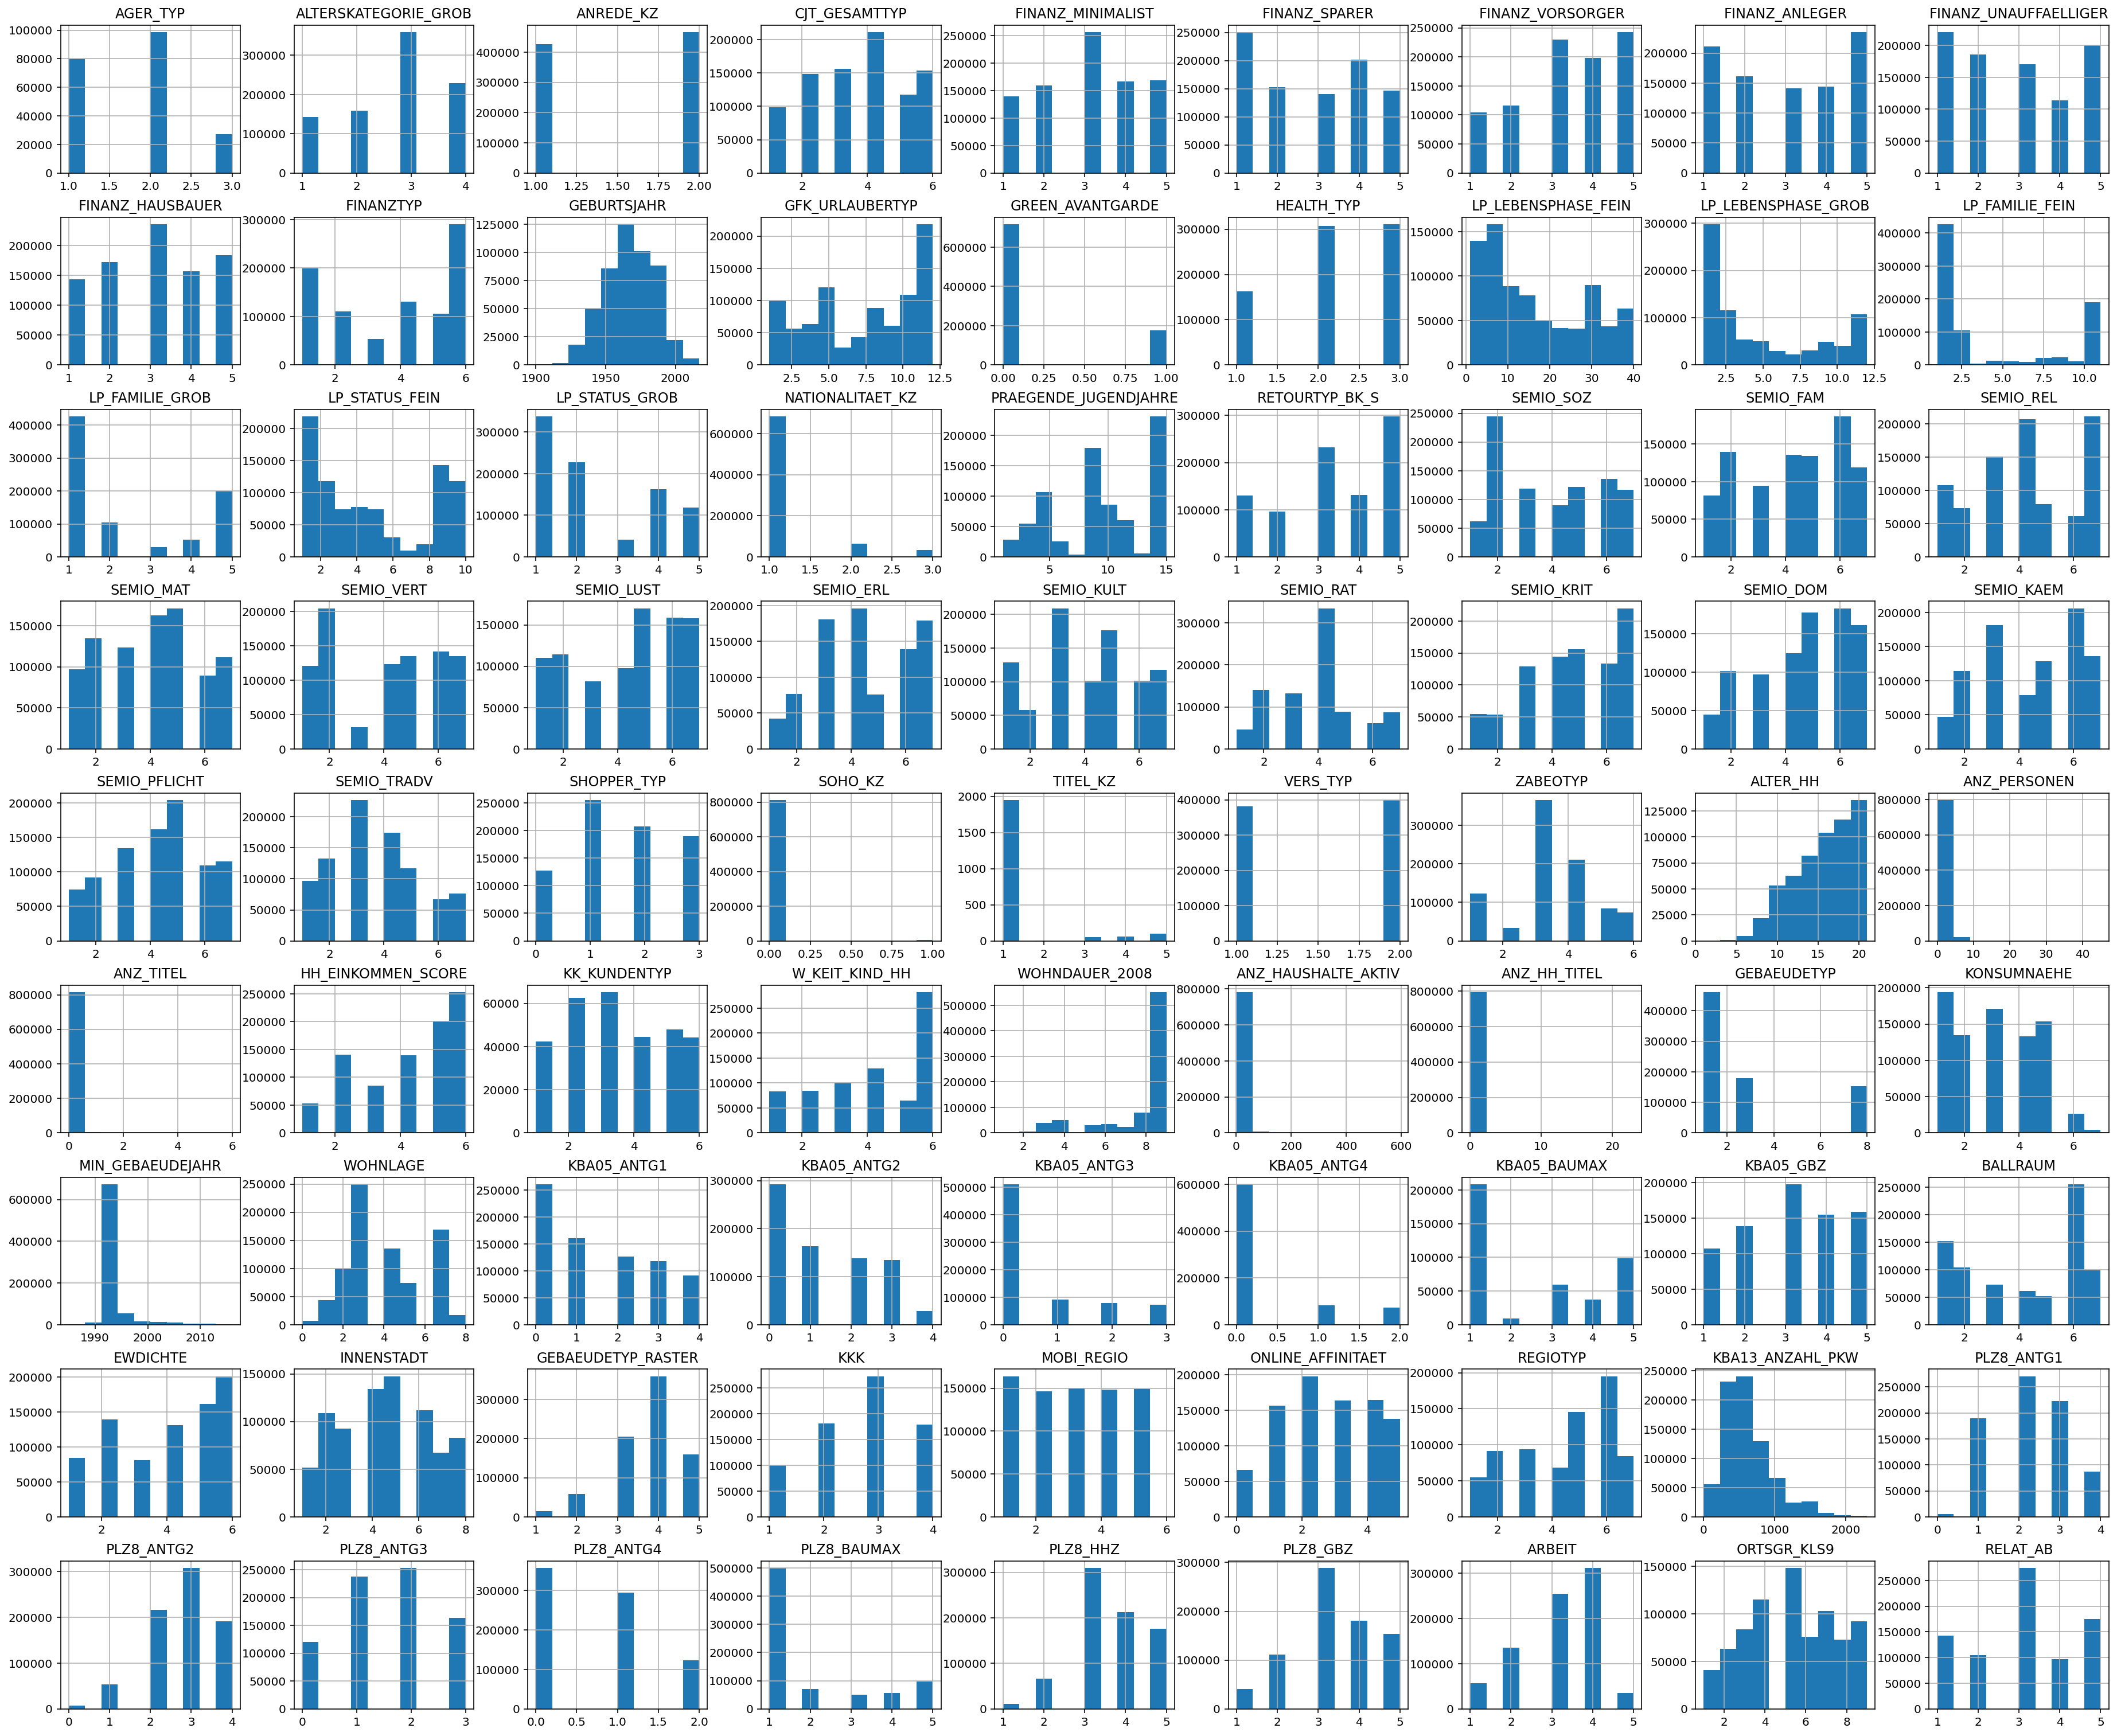

In [23]:
# Investigate patterns in the amount of missing data in each column.

fig = plt.figure(figsize = (32,27))
ax = fig.gca()
azdias.hist(ax = ax);

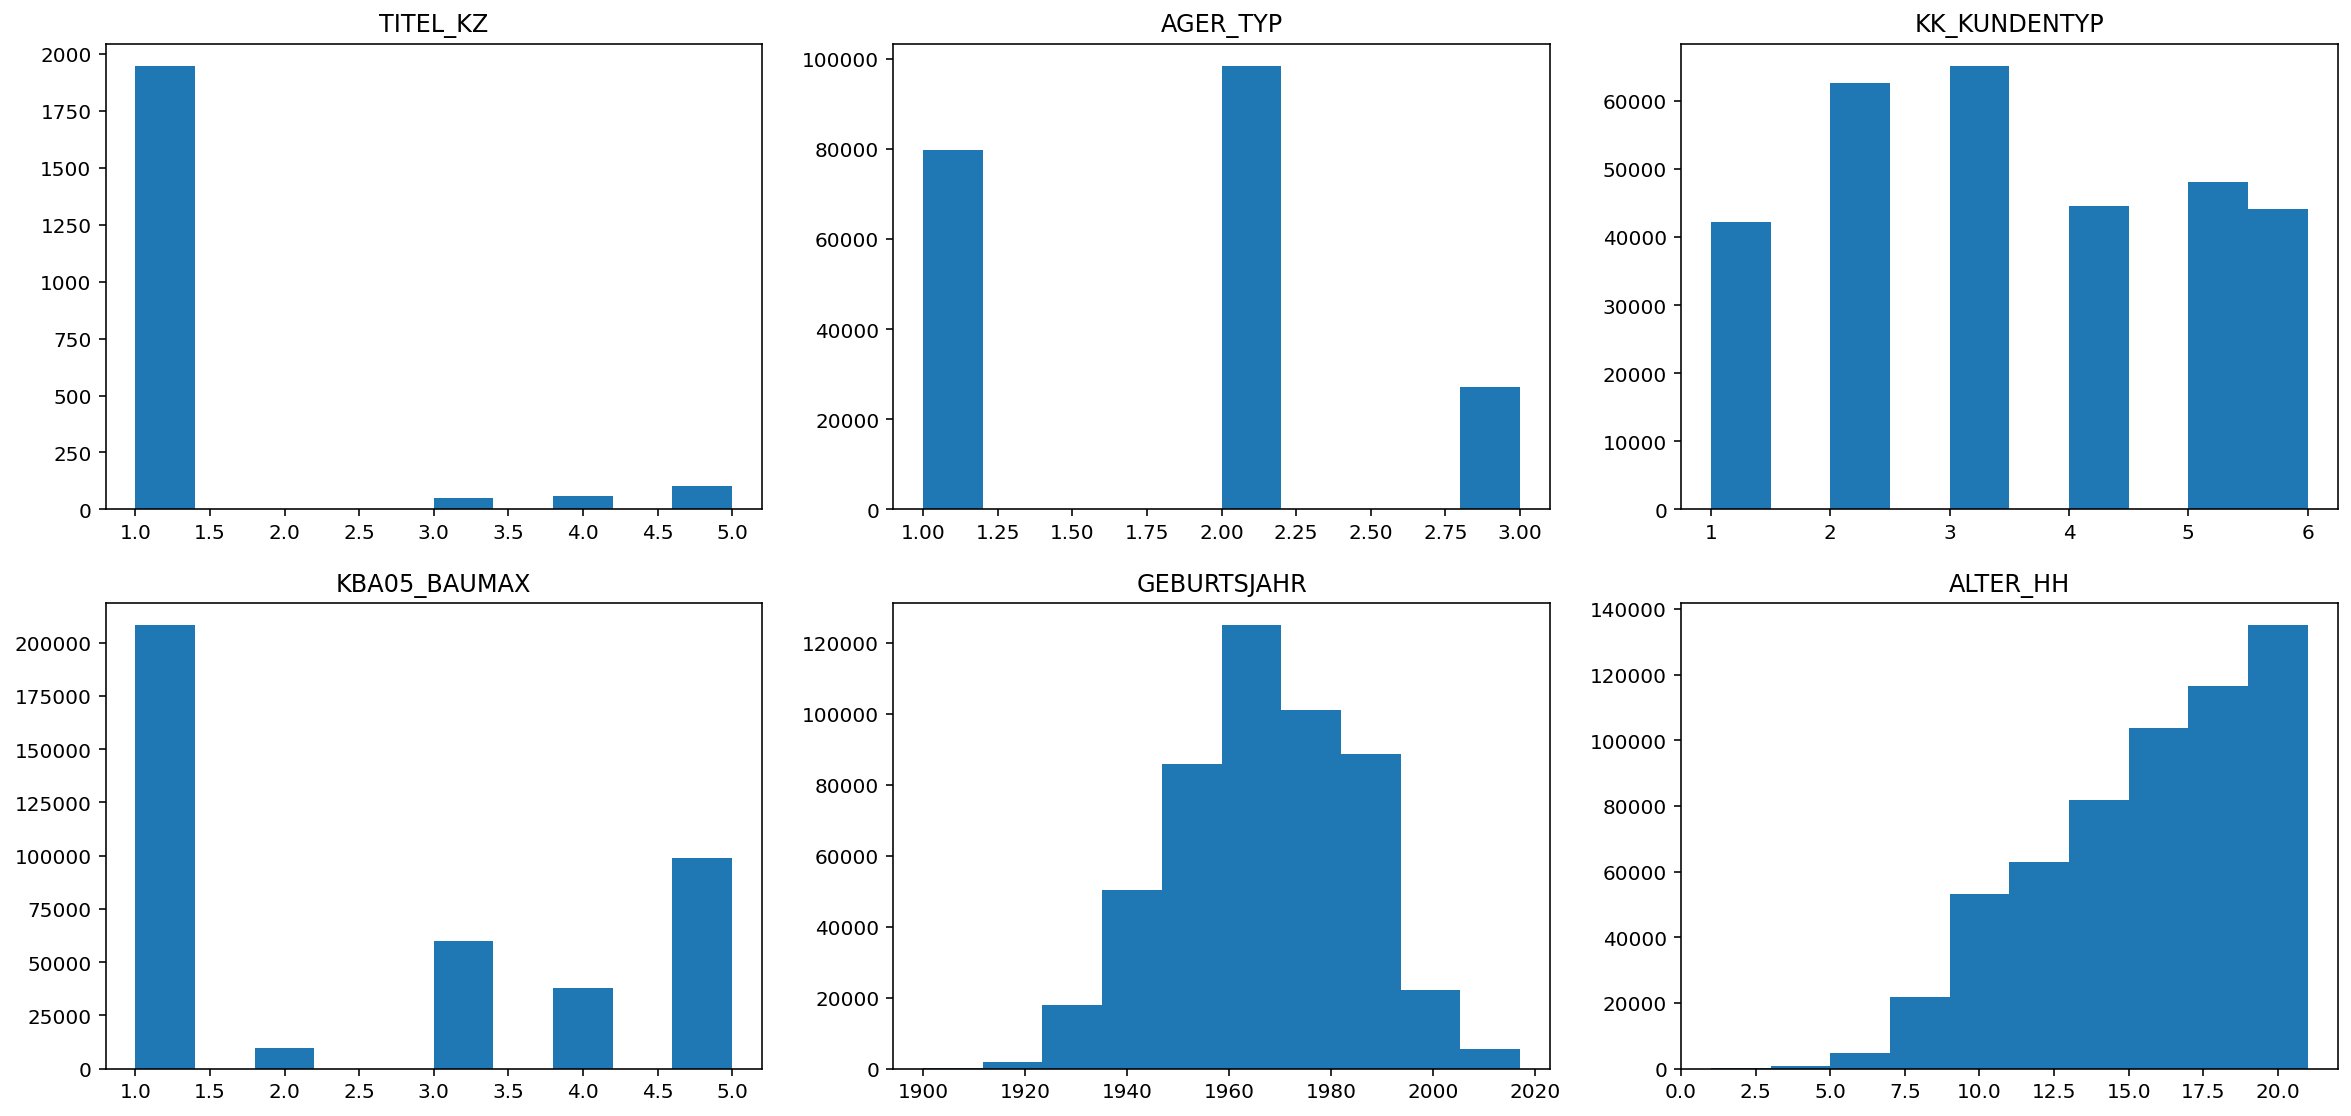

In [24]:
plt.figure(figsize = [20,30])
c = 1
for i in null_columns:
    plt.subplot(len(null_columns), 3, c)
    plt.hist(azdias[i])
    plt.title(i)
    c+=1    
plt.show()

In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(columns = null_columns, inplace = True)
general_demographics_data_columns = azdias.columns

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

> We have accessed each column to find missing data after replacing data that was coded as either missing or unknown with a missing value. The total number of missing(or null) values is calculated as 8,373,929. Each column has a different amount of missing values. We can categorize them into three ranges per the percentage of missing values; (1) 0 ~ 5%, (2) 5 ~ 20%, and (3) 20% ~. Six columns are having more than 20% of missing values. Looking at the pattern of those on the histogram, 'GEBURTSJAHR' forms a symmetric, 'ALTER_HH' forms left-skewed, and the rest forms disconnected patterns over the X-axis. Considering the high portion of missing values, we have removed the aforementioned six columns having more than 20% percent of missing values. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?

# check the percentage of missing values per row
from tqdm.notebook import tqdm
missing_check_by_rows = {}
for i in tqdm(range(azdias.shape[0])):
    total = len(azdias.iloc[i].values.tolist())
    try:
        null_value = np.isnan(azdias.iloc[i].values.tolist()).sum()
        null_percent = null_value/total*100
    except:
        null_value = 0        
        null_percent = 0
    missing_check_by_rows[i] = null_percent    
missing_check_by_rows = pd.DataFrame([missing_check_by_rows]).T.rename(columns = {0:'null_percent'})
missing_check_by_rows.sort_values('null_percent', ascending = False, inplace = True)

  0%|          | 0/891221 [00:00<?, ?it/s]

In [27]:
missing_check_by_rows.head()

null_percent
643174     62.025316
732775     62.025316
472919     60.759494
66515      59.493671
494043     59.493671

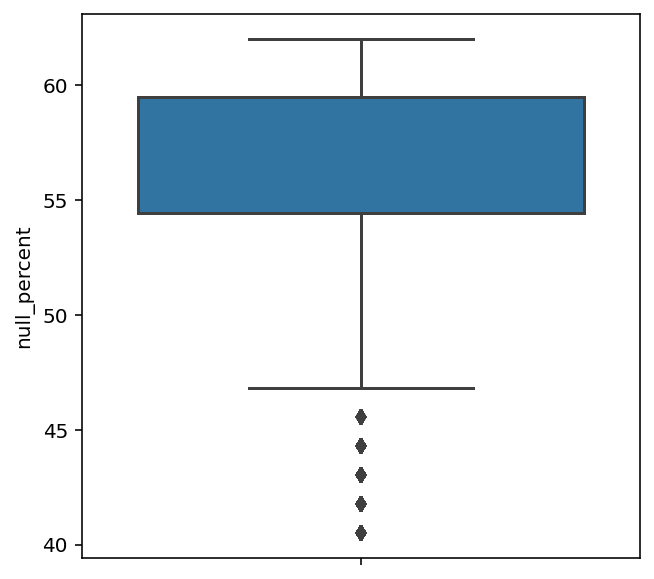

In [28]:
missing_data_plot = missing_check_by_rows[missing_check_by_rows['null_percent'] != 0]
plt.figure(figsize = (5,5))
sb.boxplot(data = missing_data_plot, y = 'null_percent')
plt.show()

Null Percentage Threshold: 50 %
Total Record Verification: True


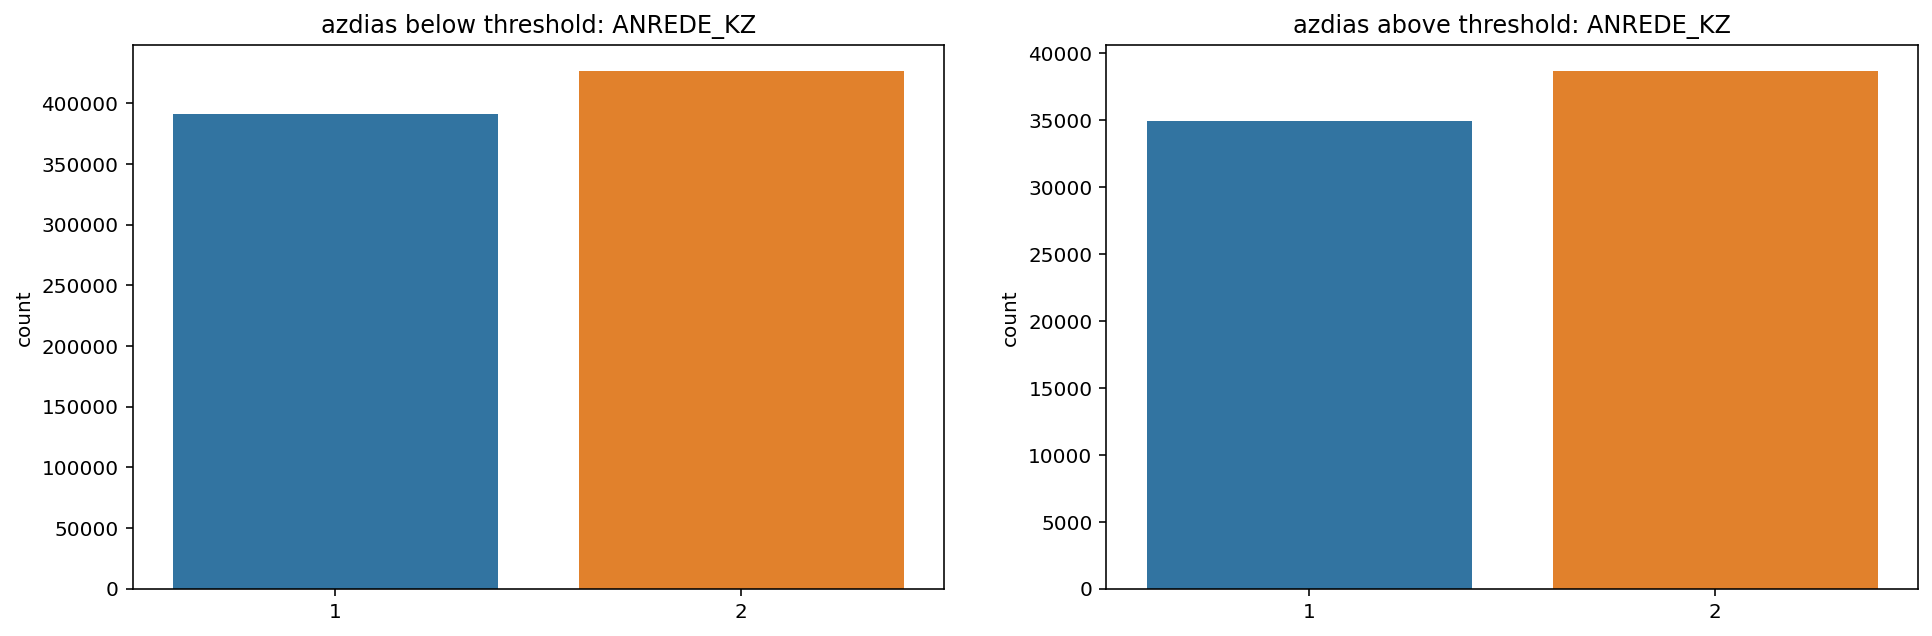

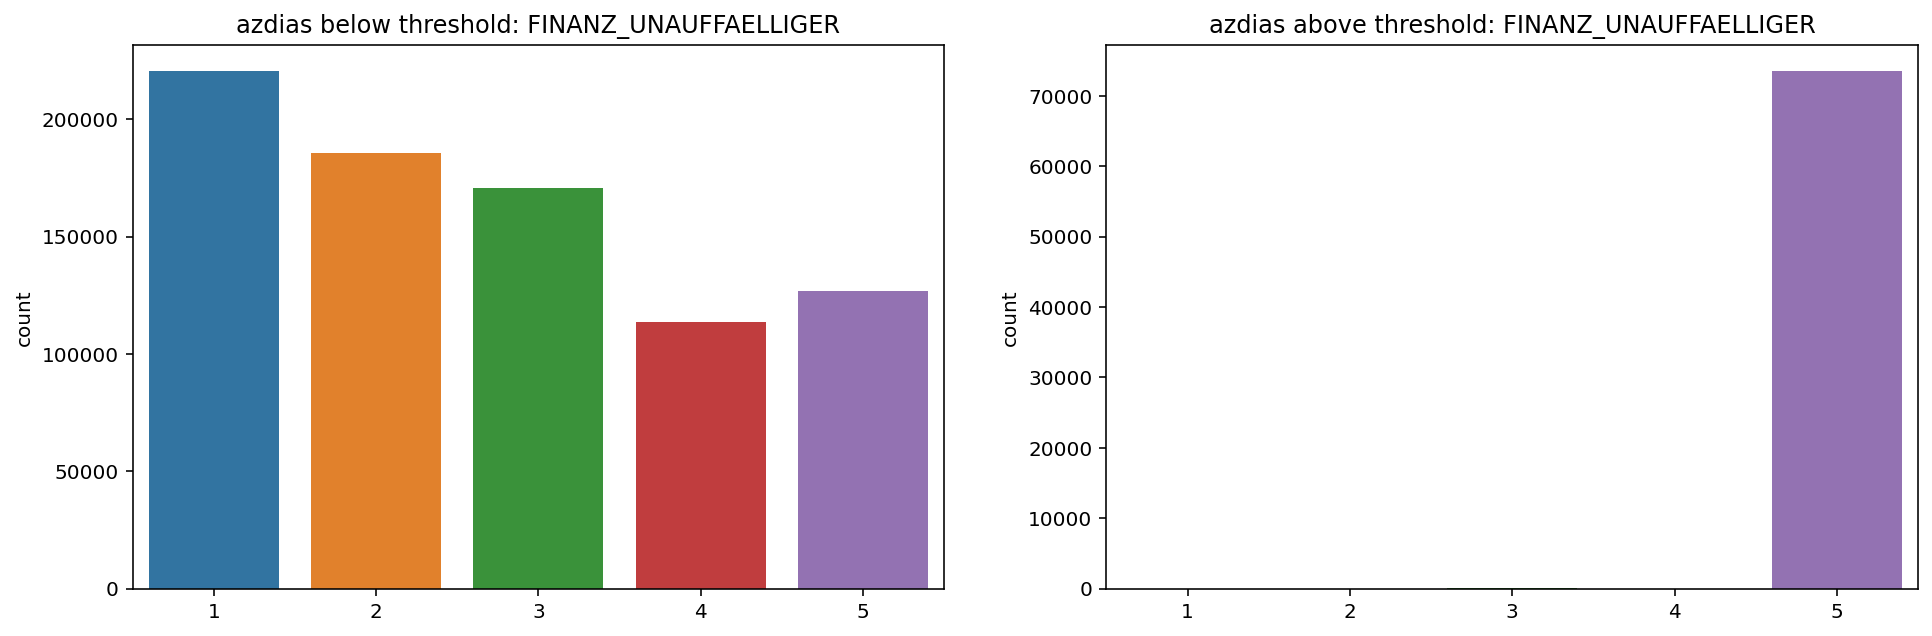

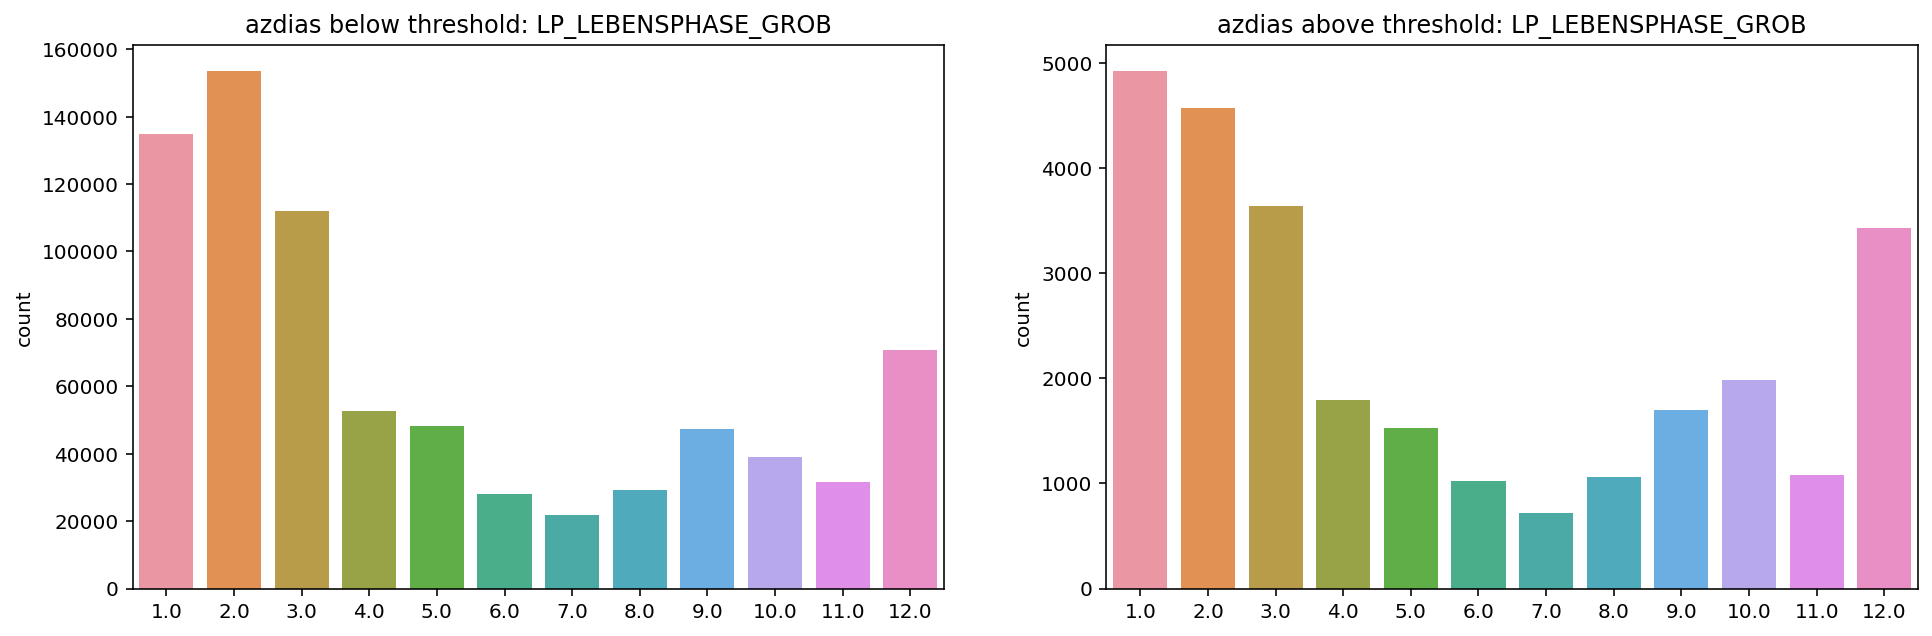

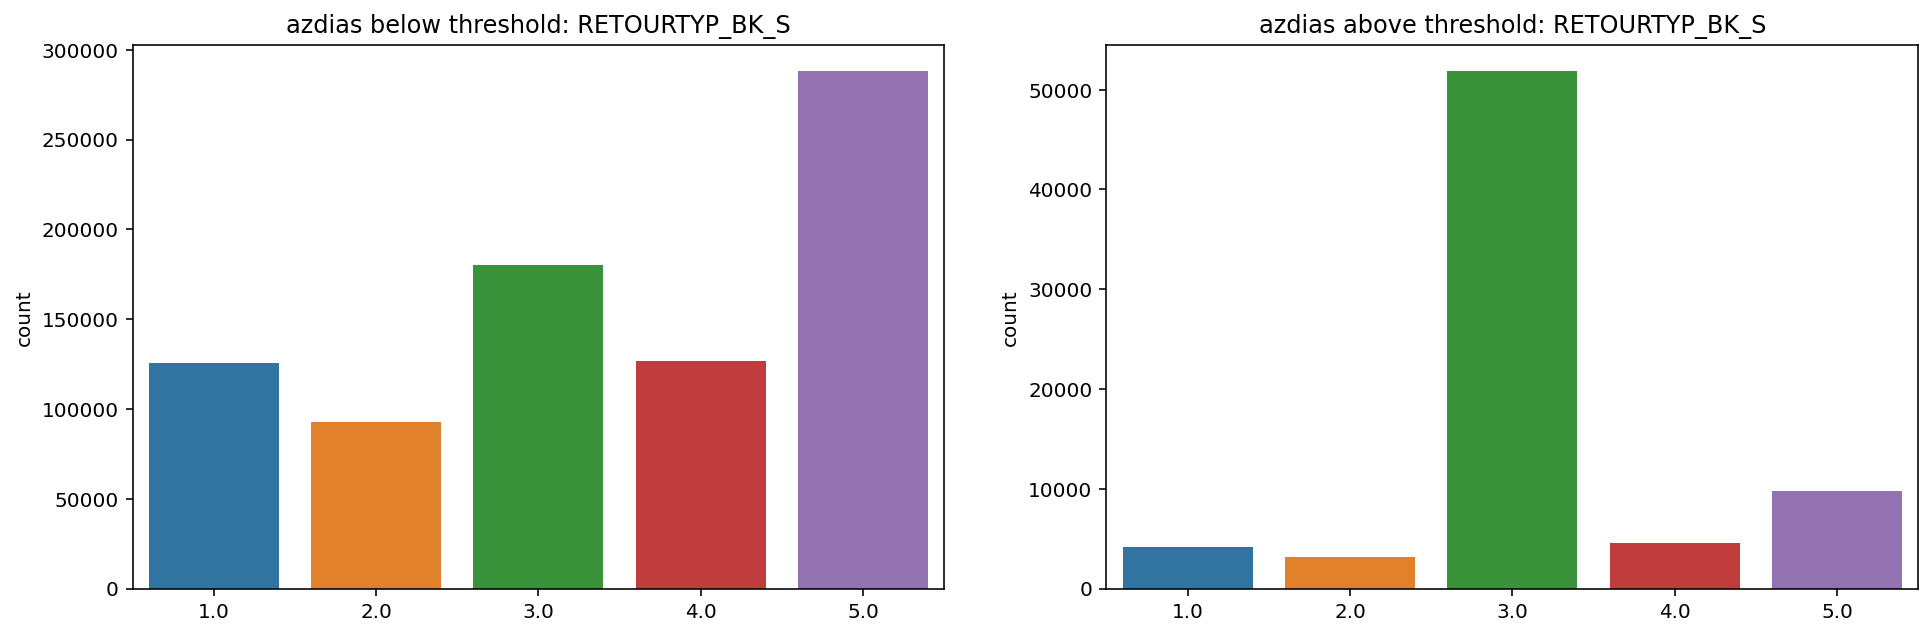

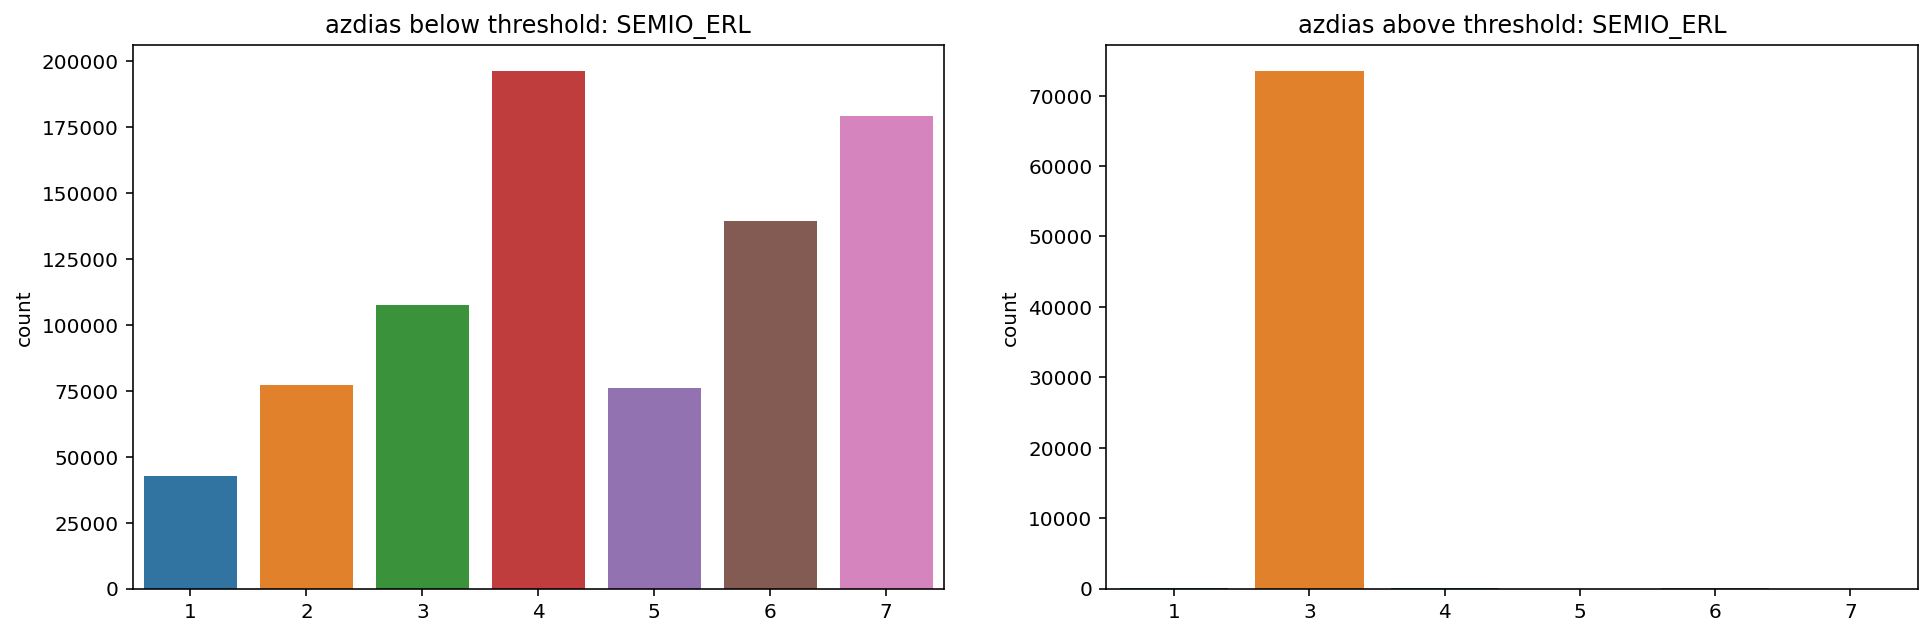




Null Percentage Threshold: 40 %
Total Record Verification: True


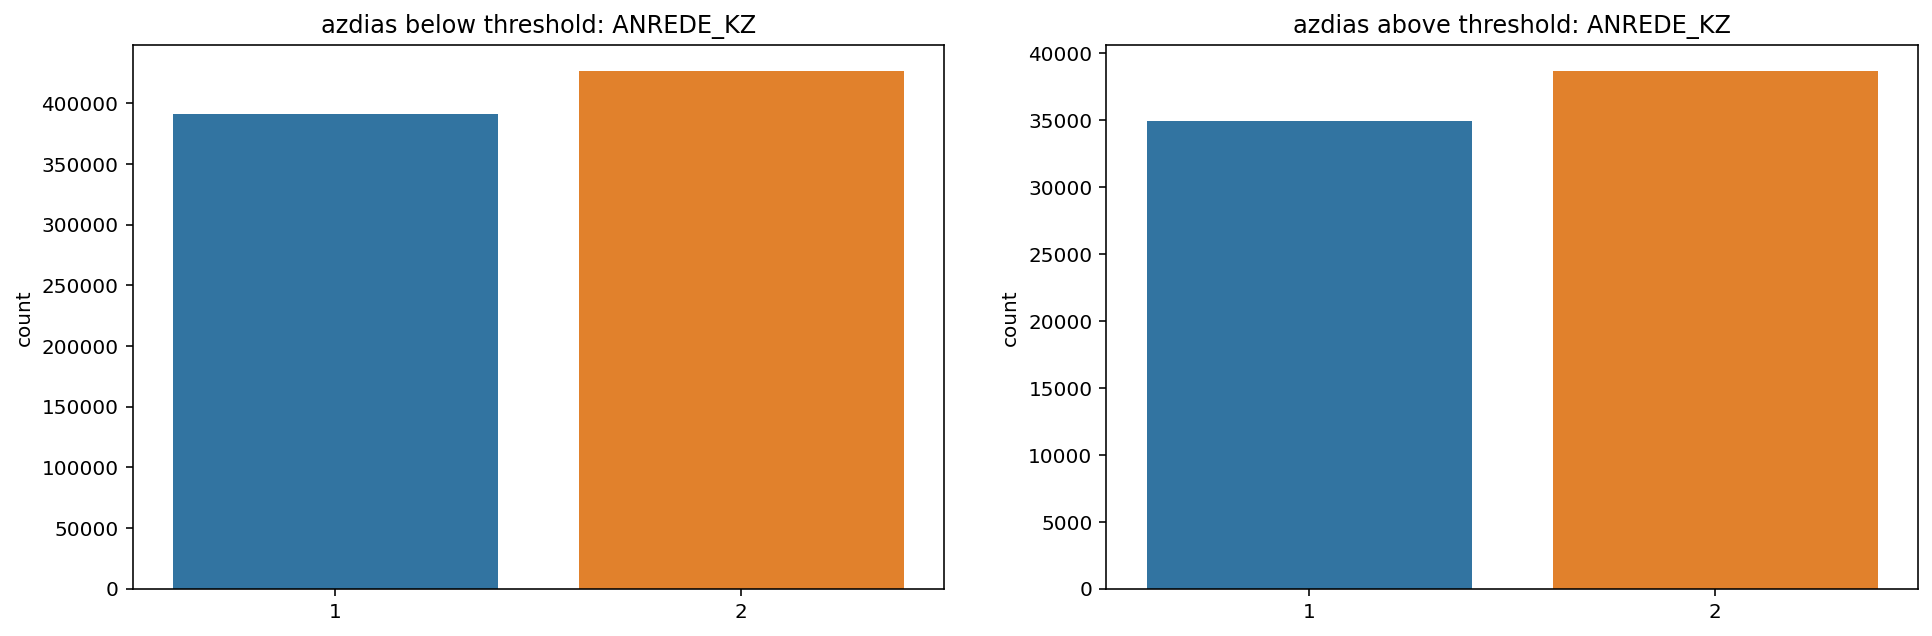

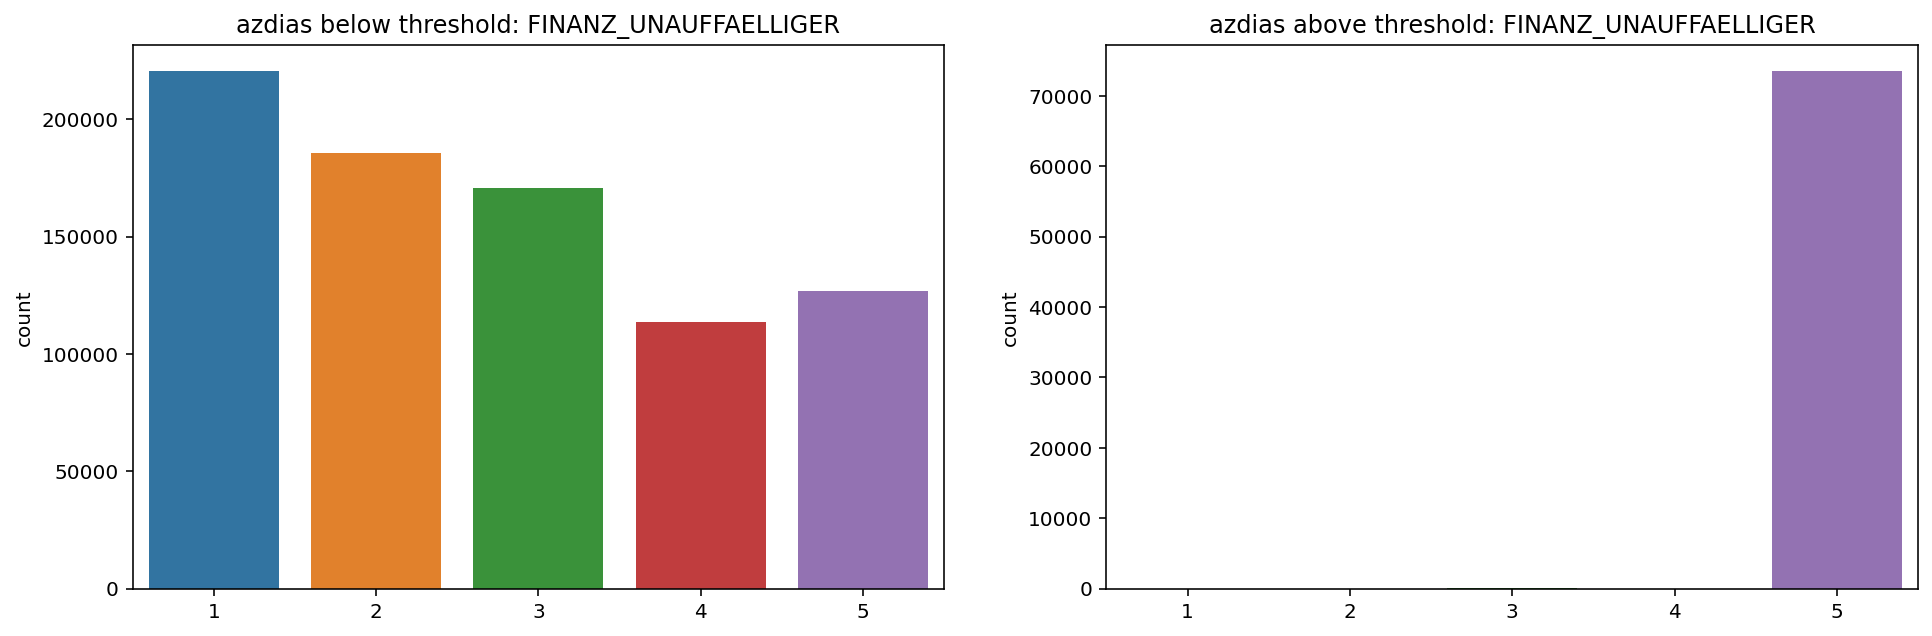

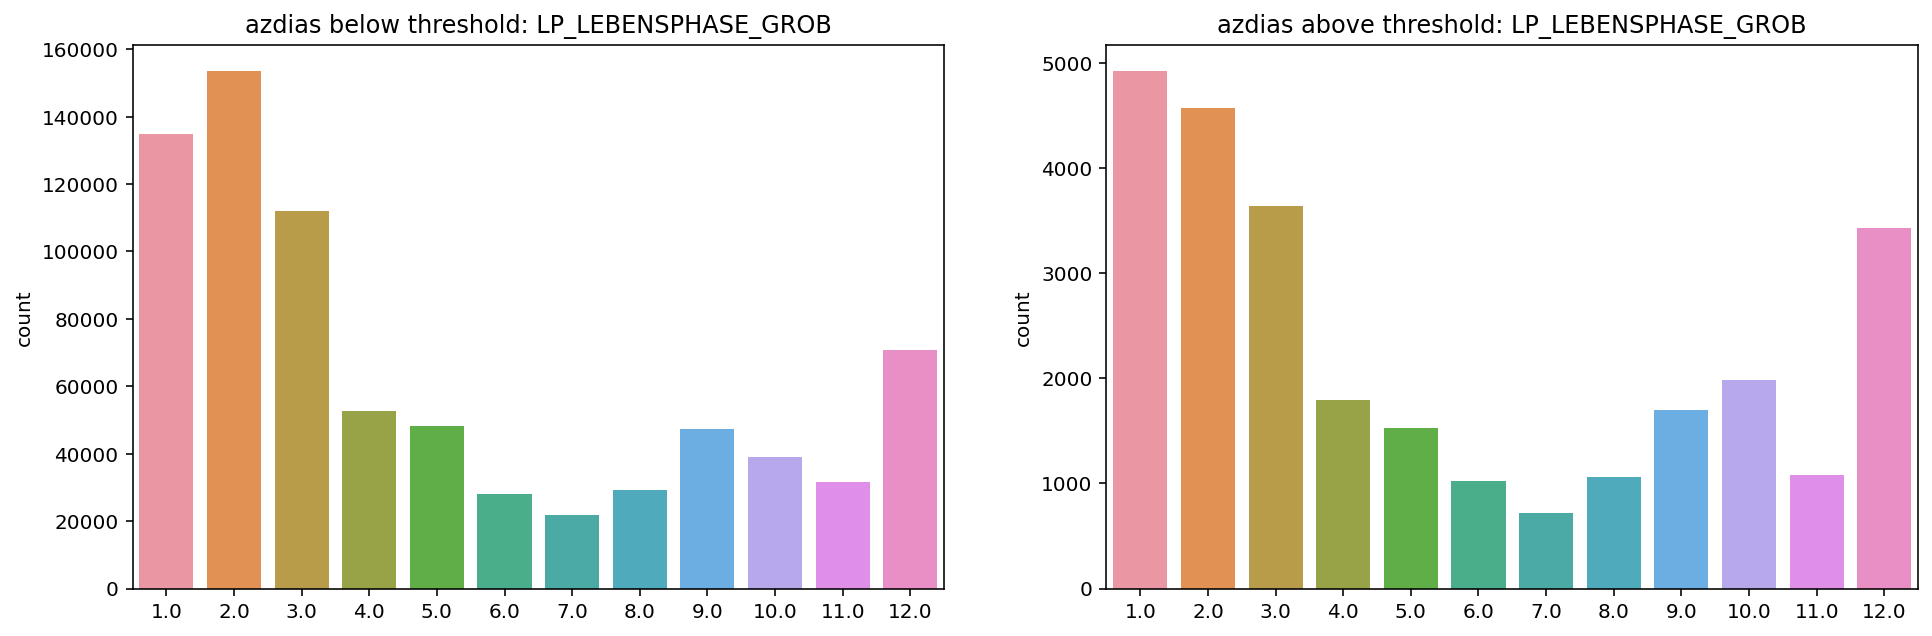

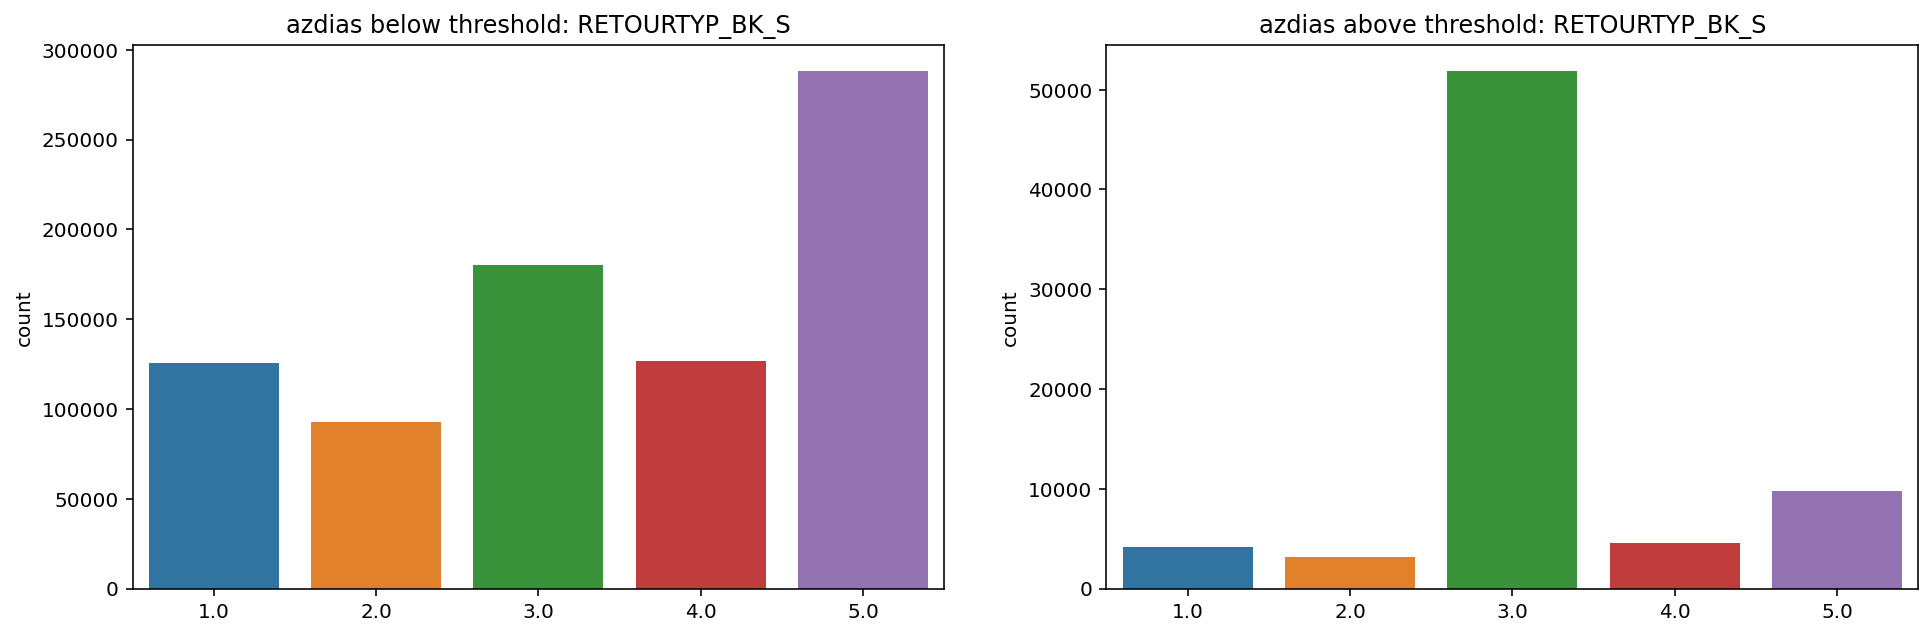

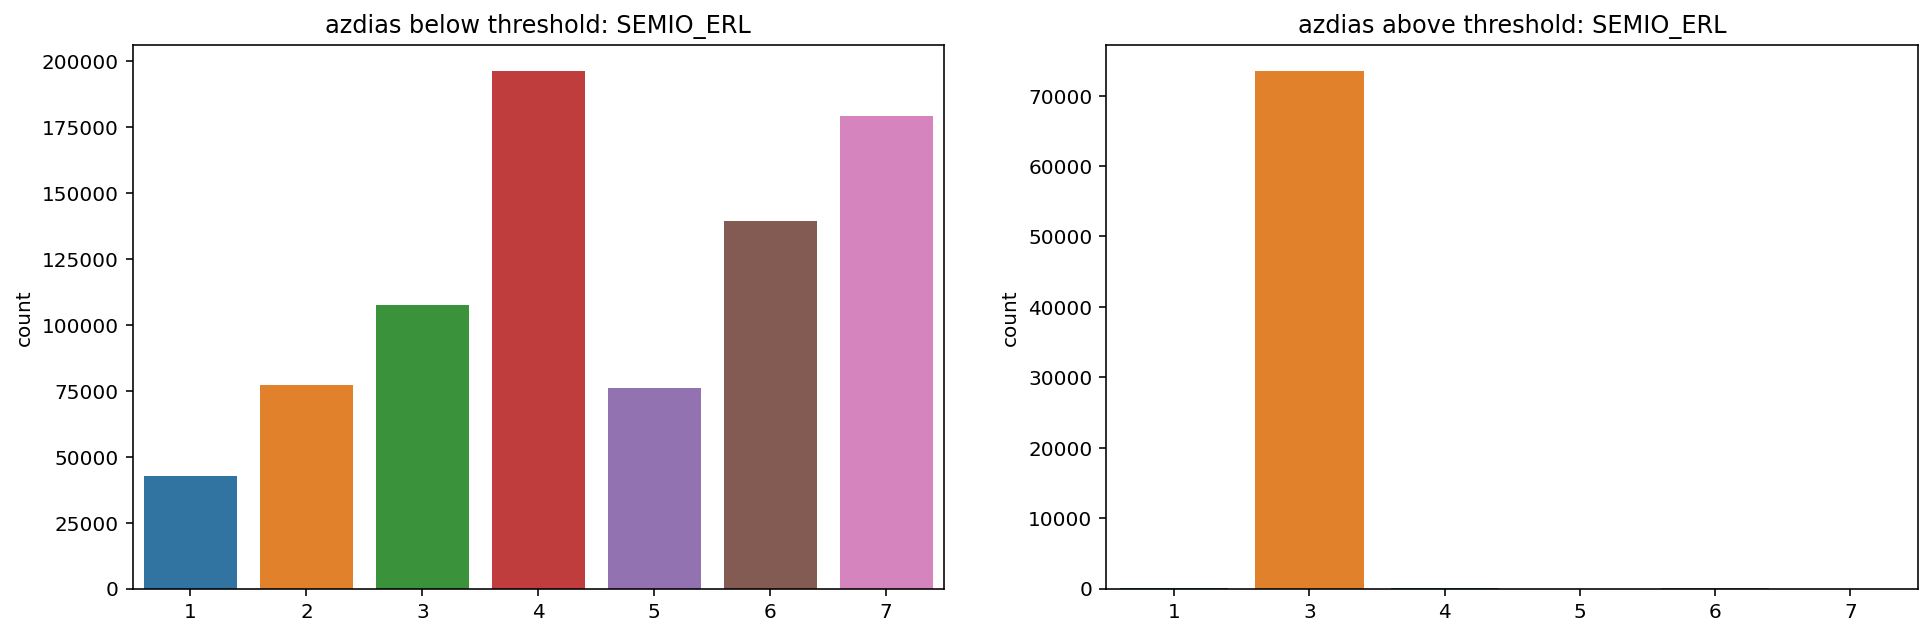




Null Percentage Threshold: 30 %
Total Record Verification: True


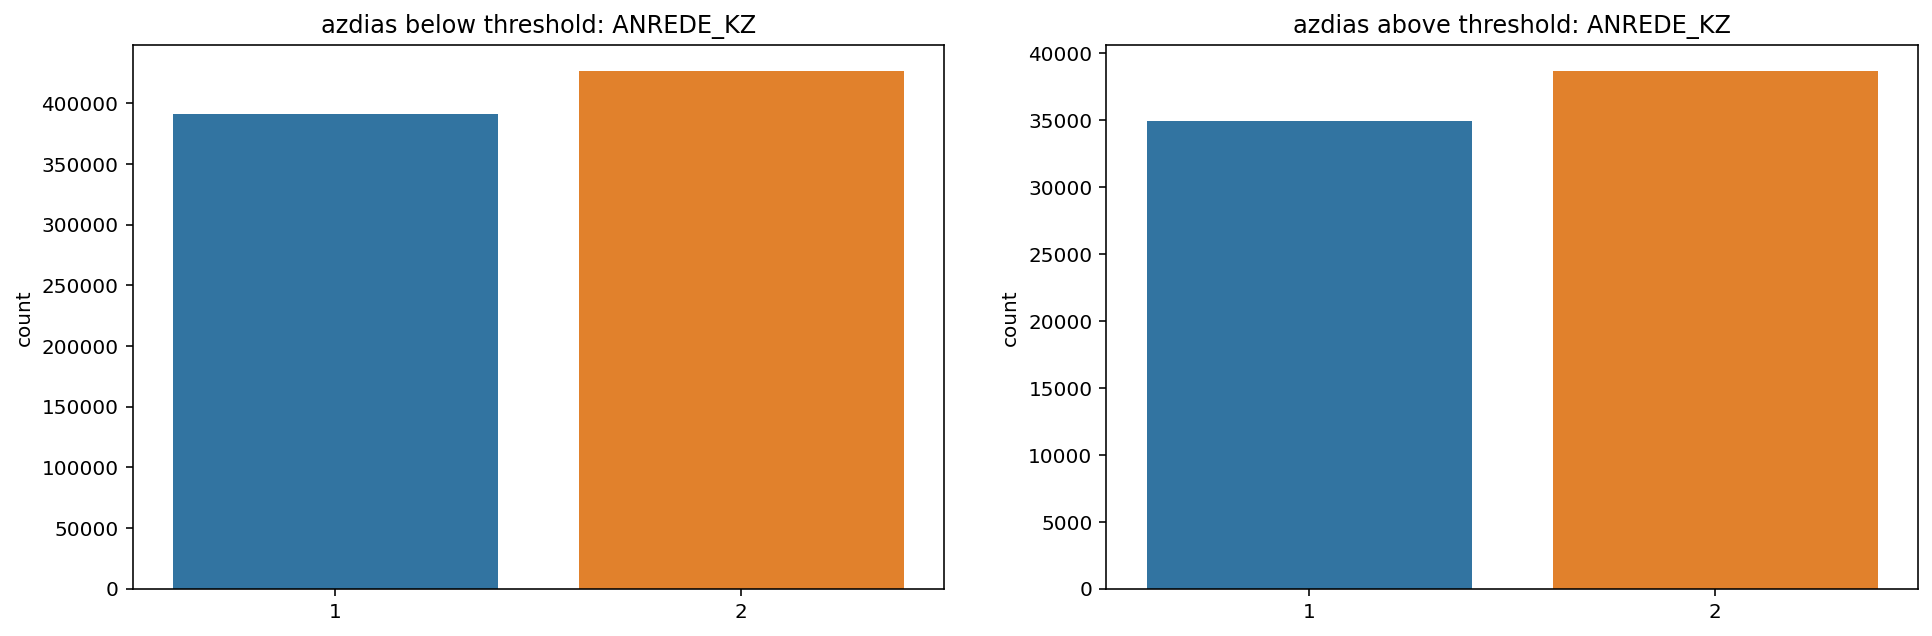

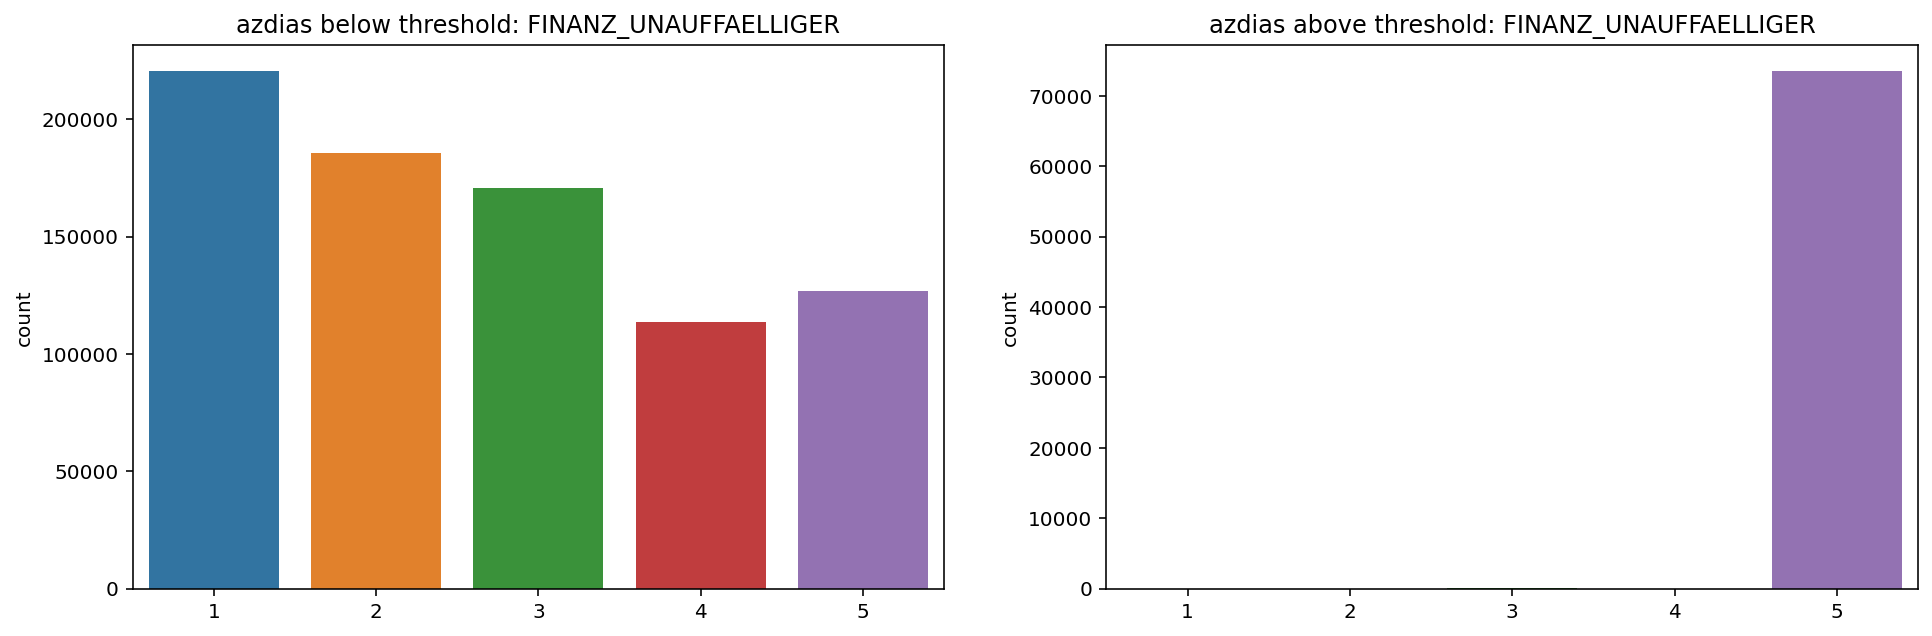

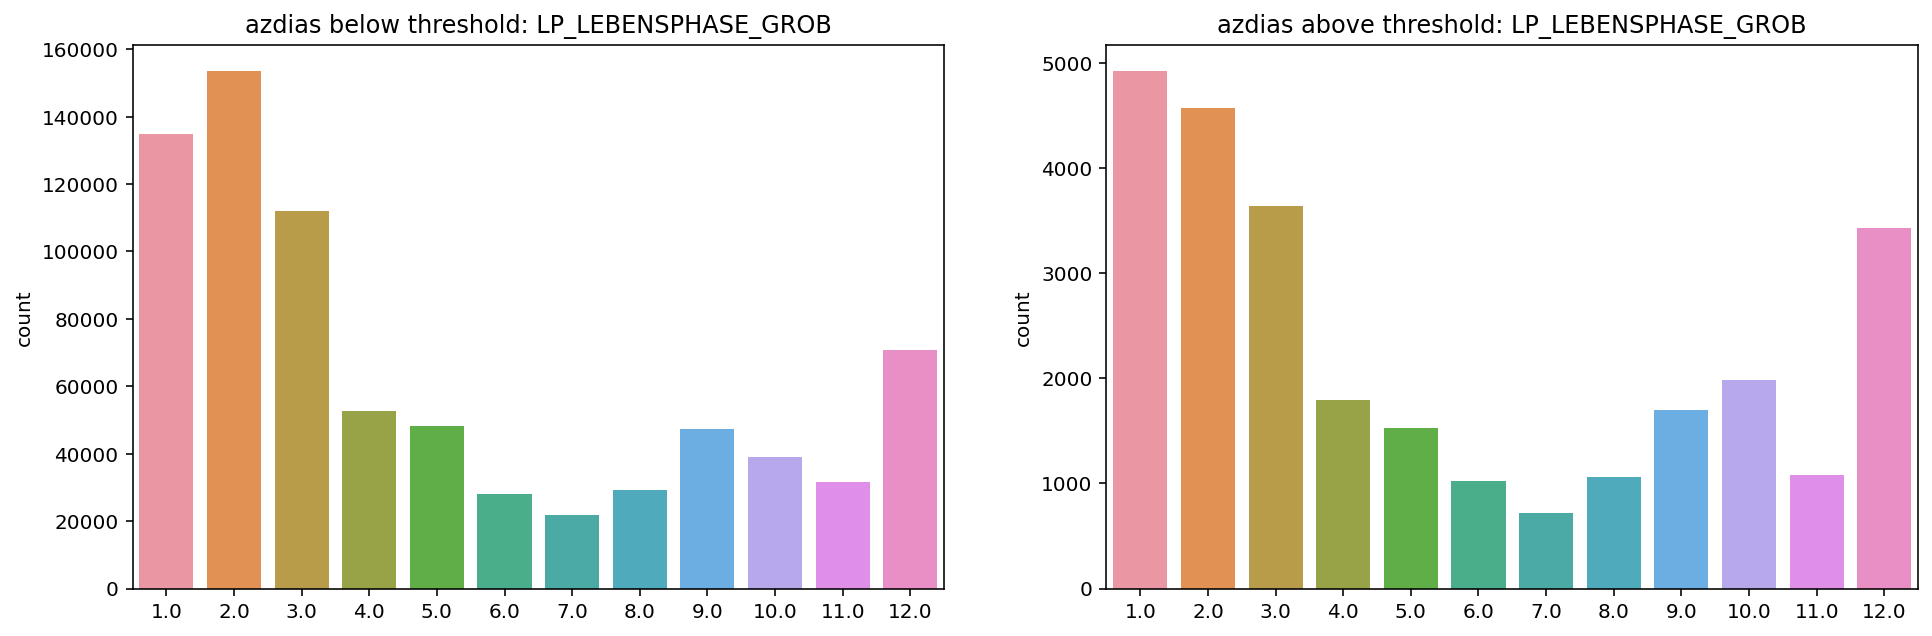

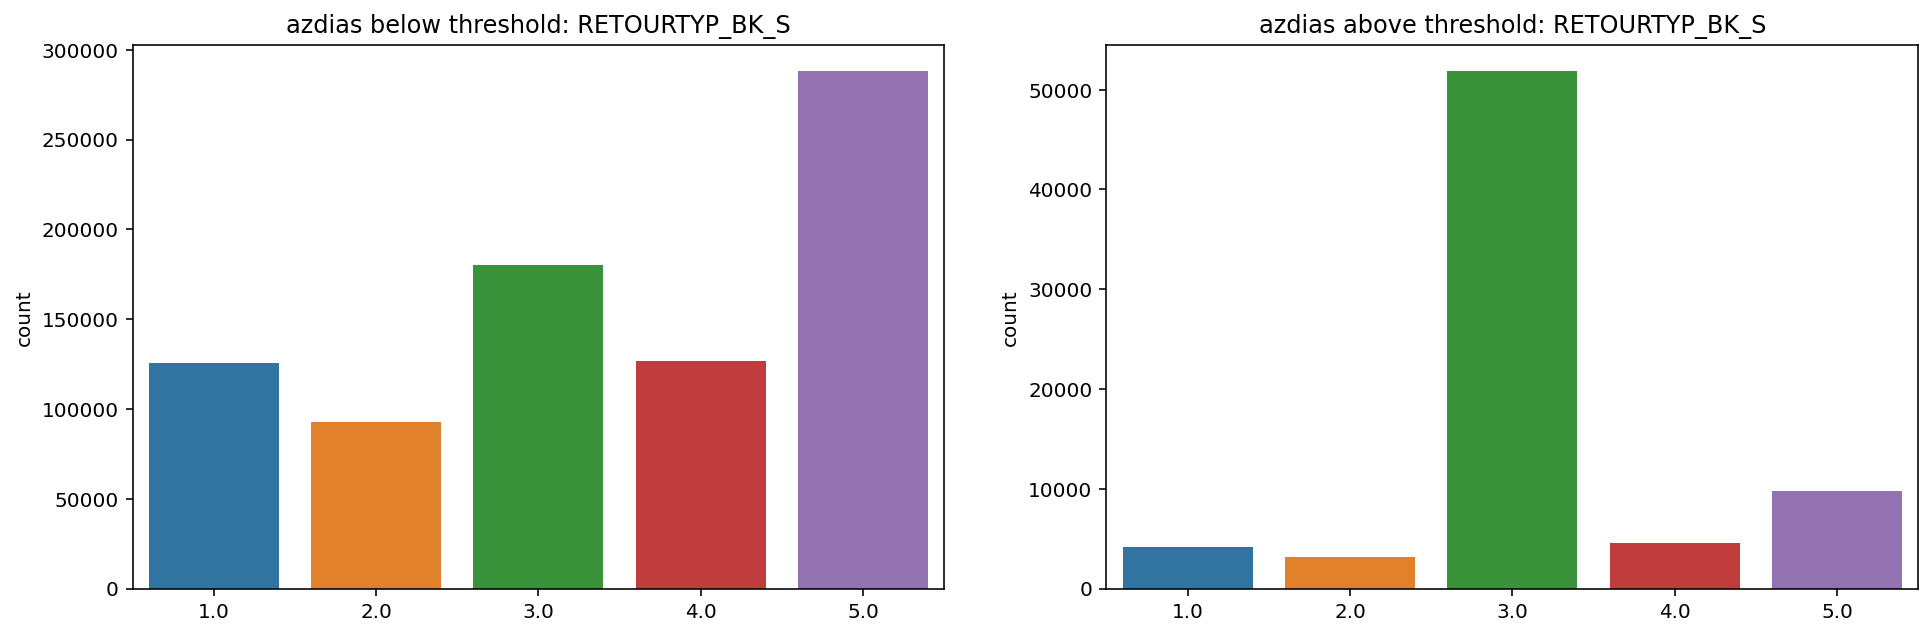

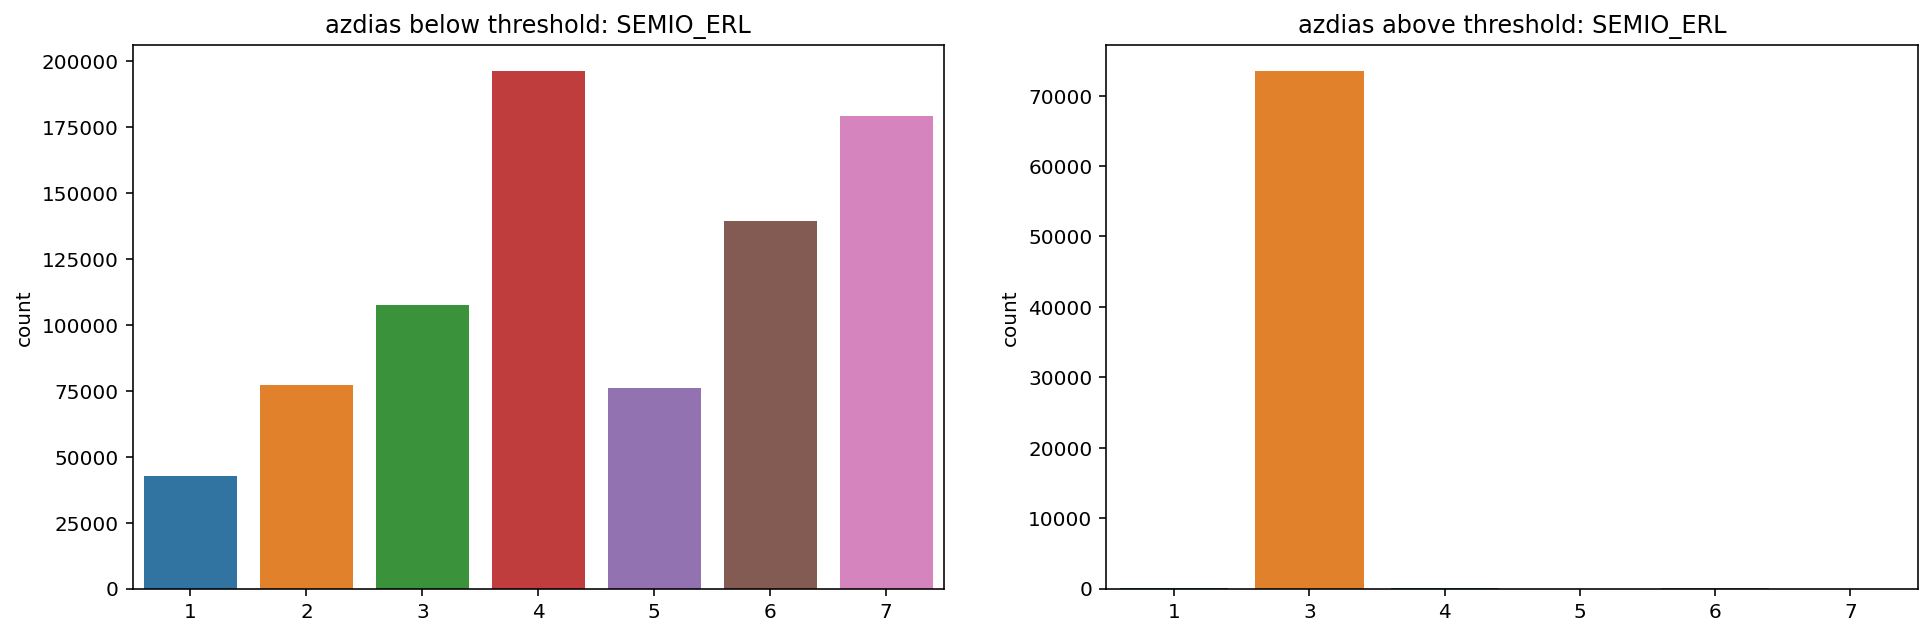




Null Percentage Threshold: 20 %
Total Record Verification: True


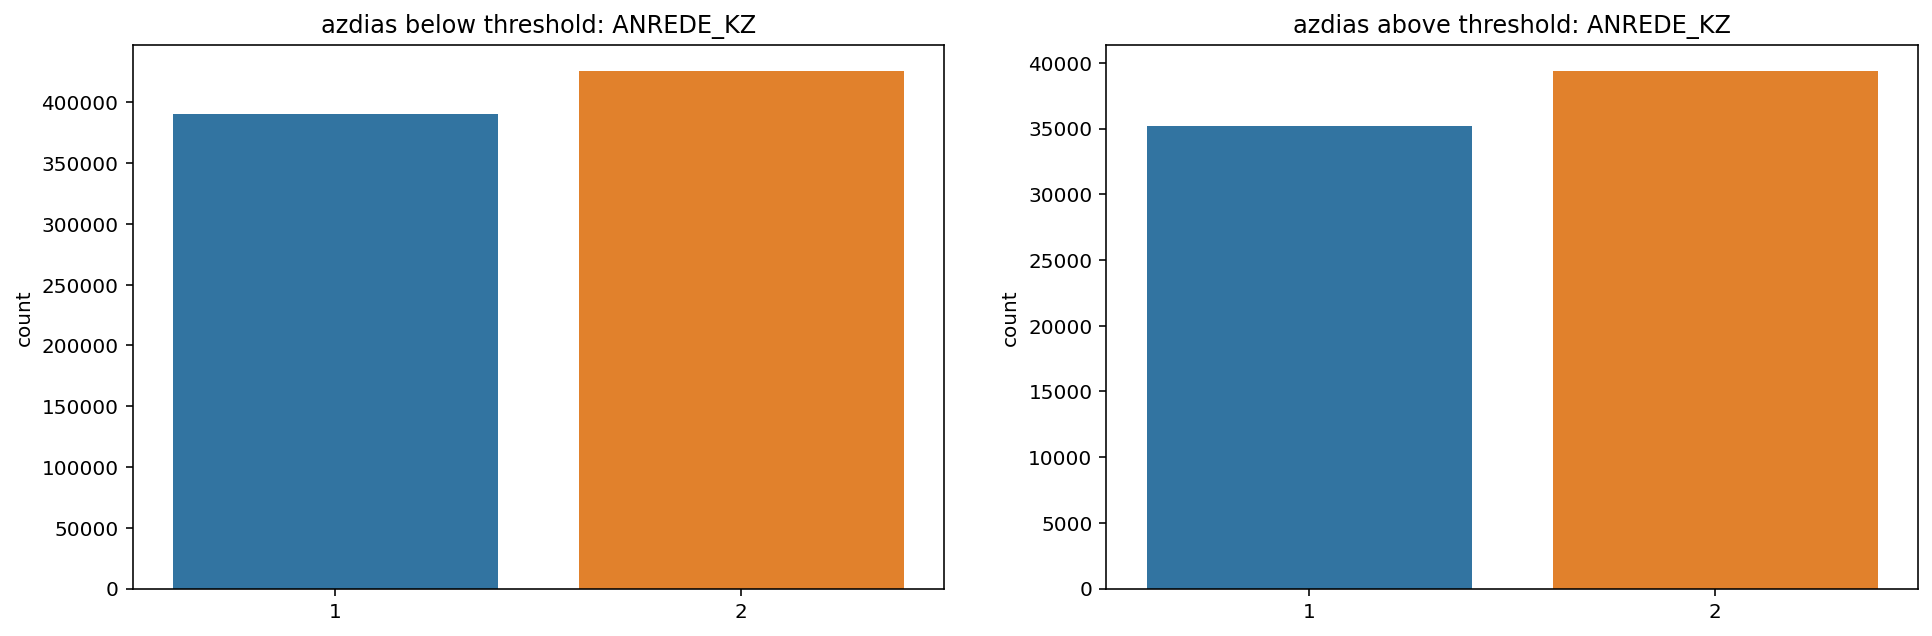

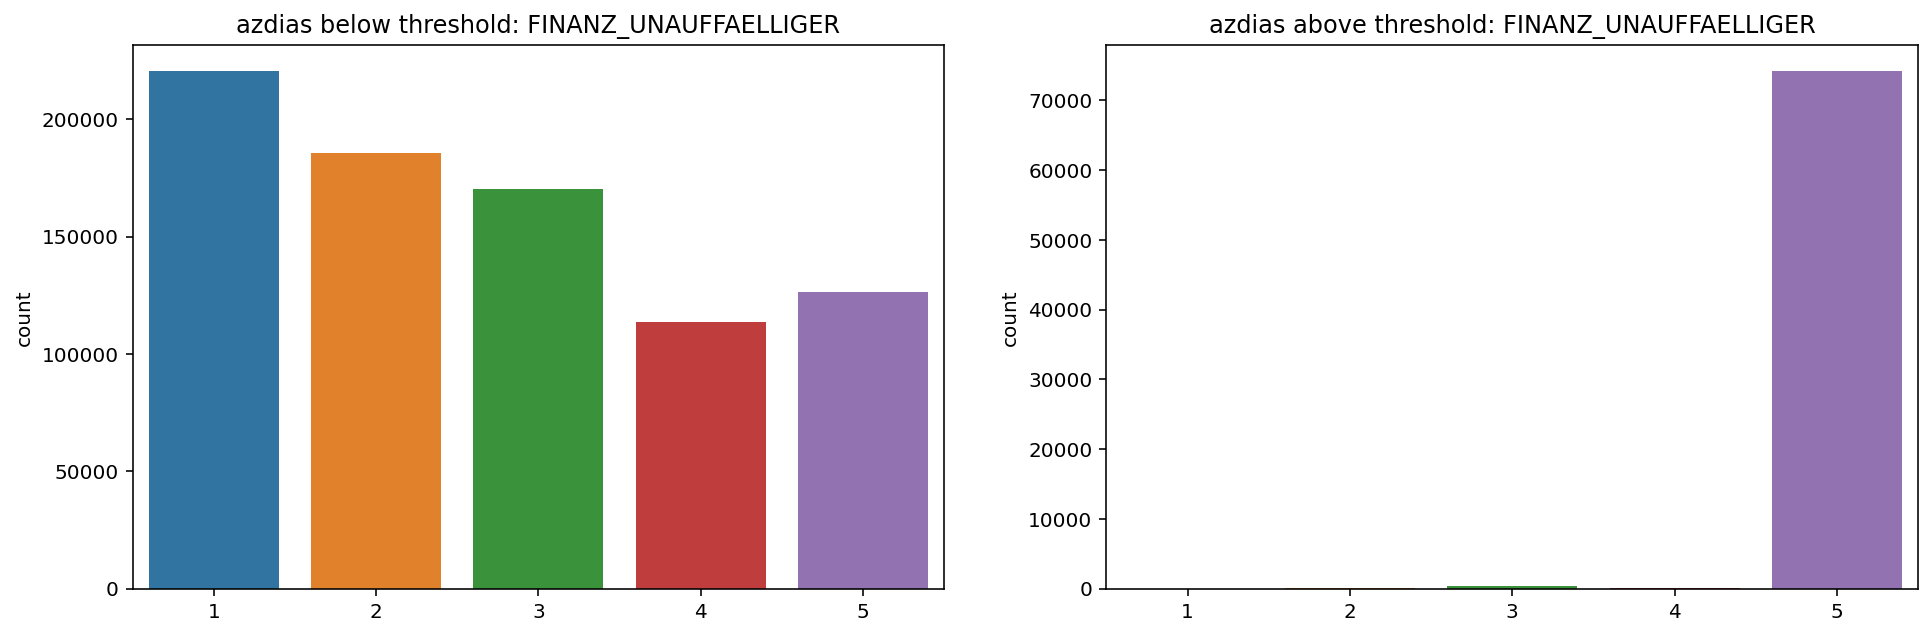

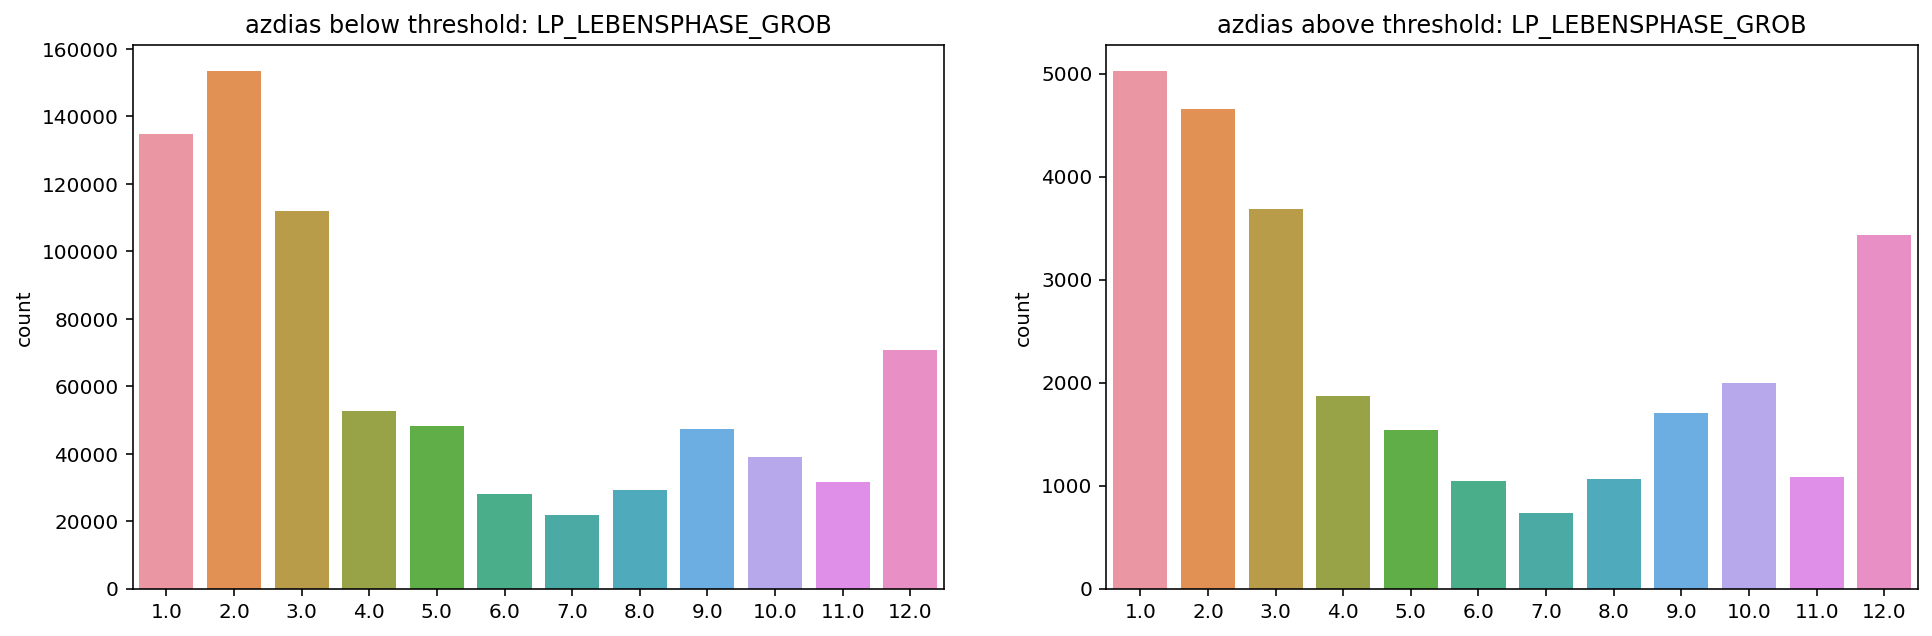

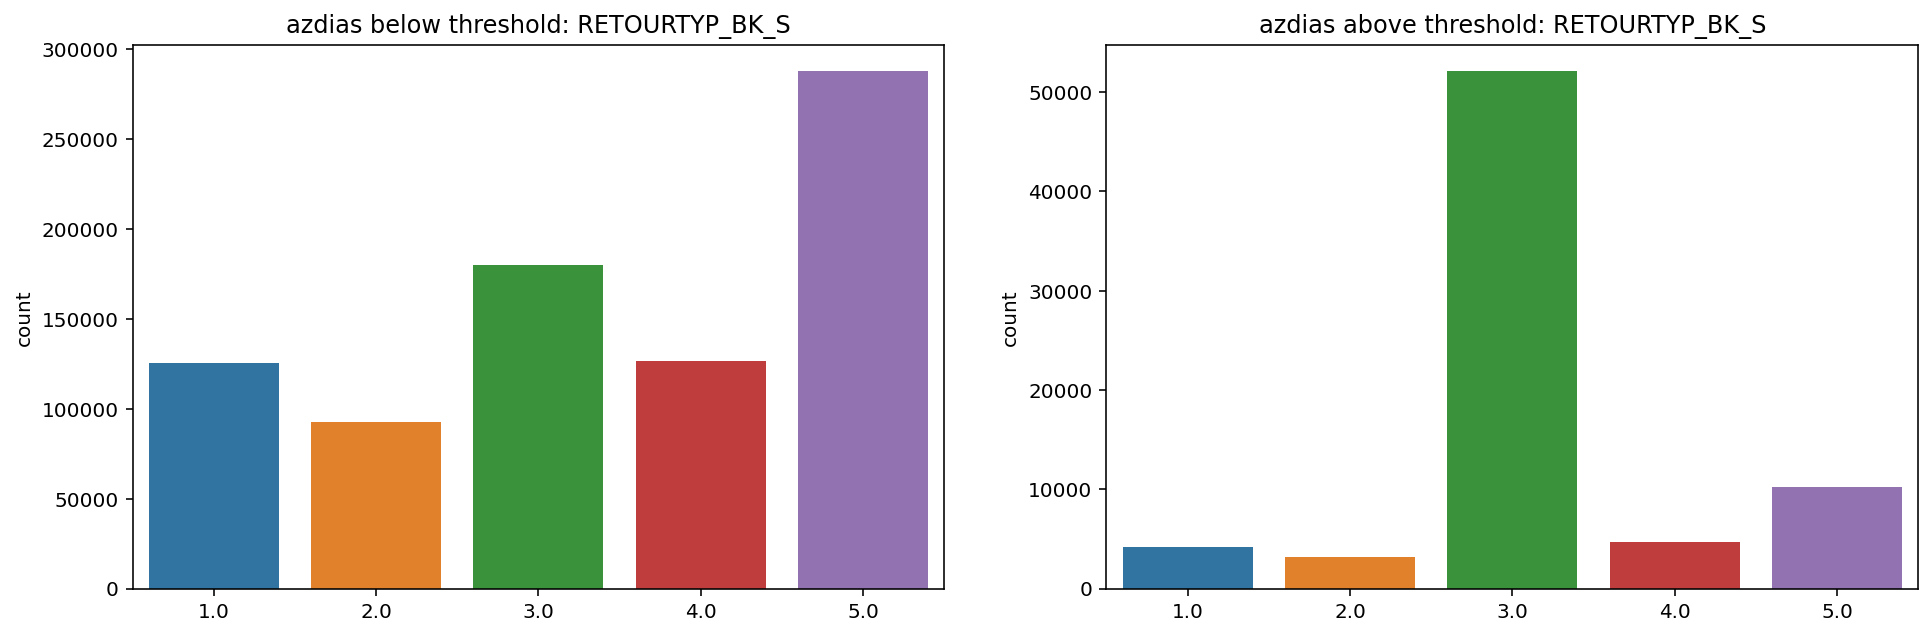

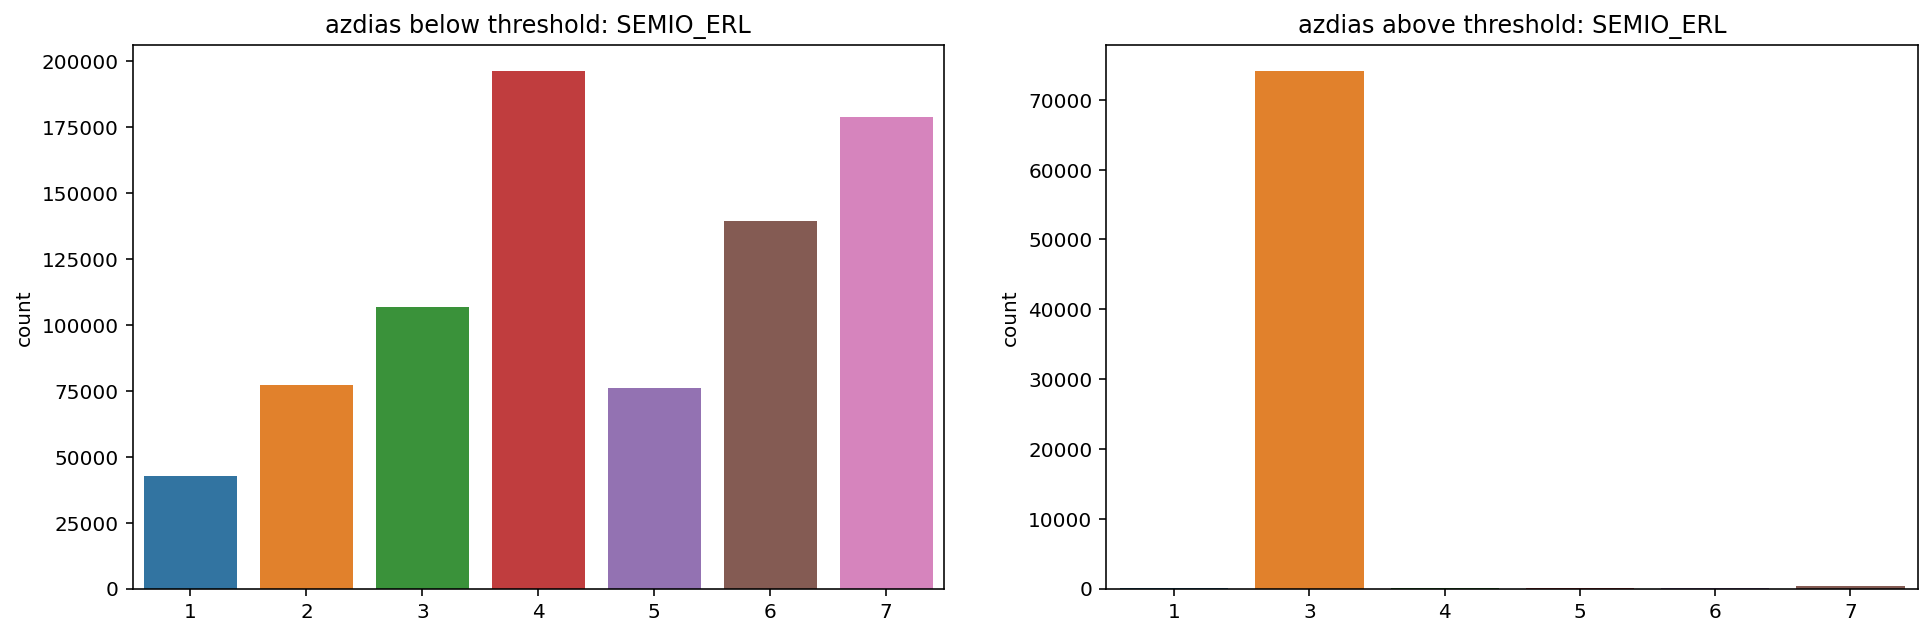




Null Percentage Threshold: 10 %
Total Record Verification: True


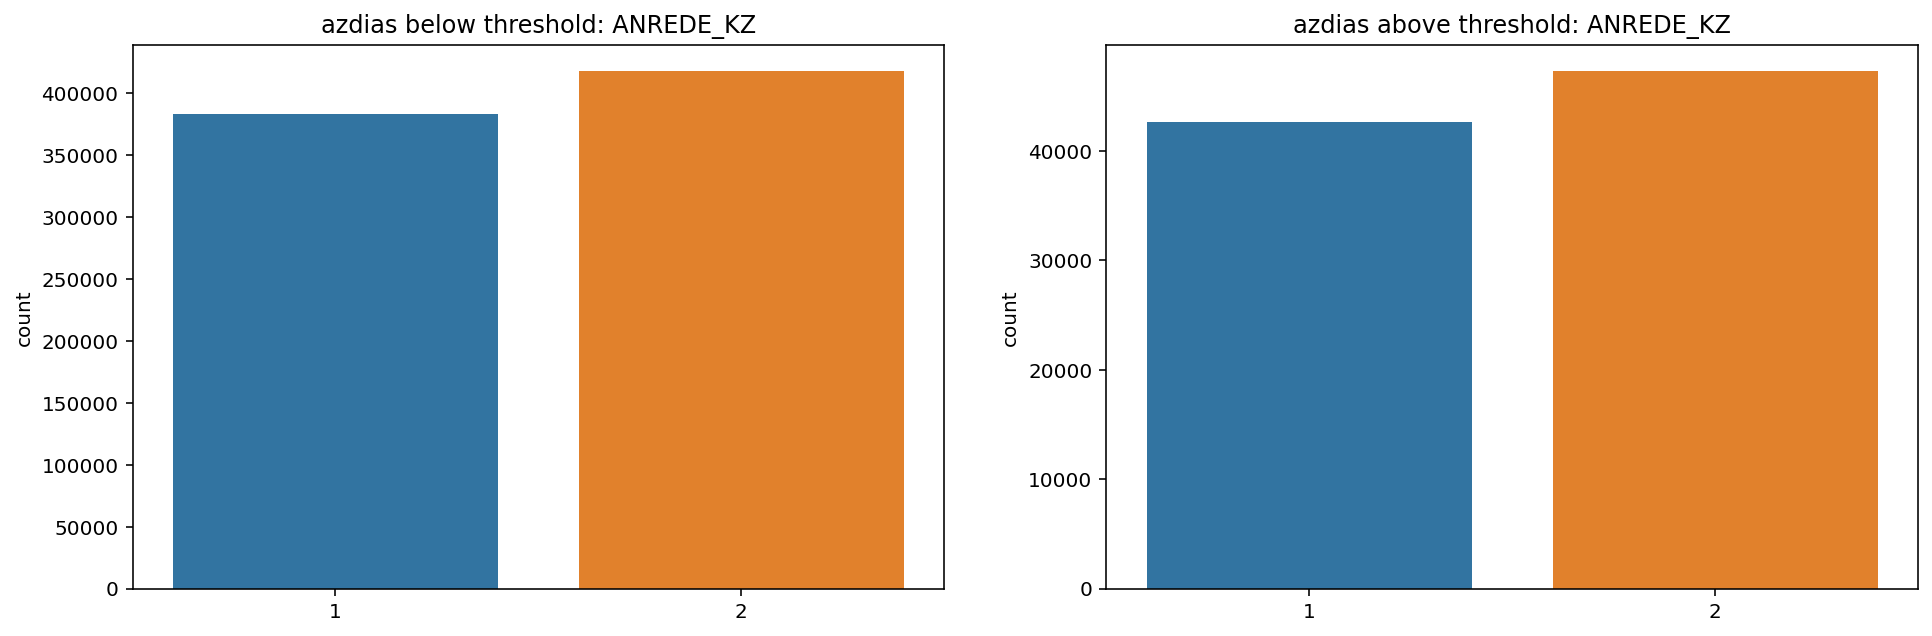

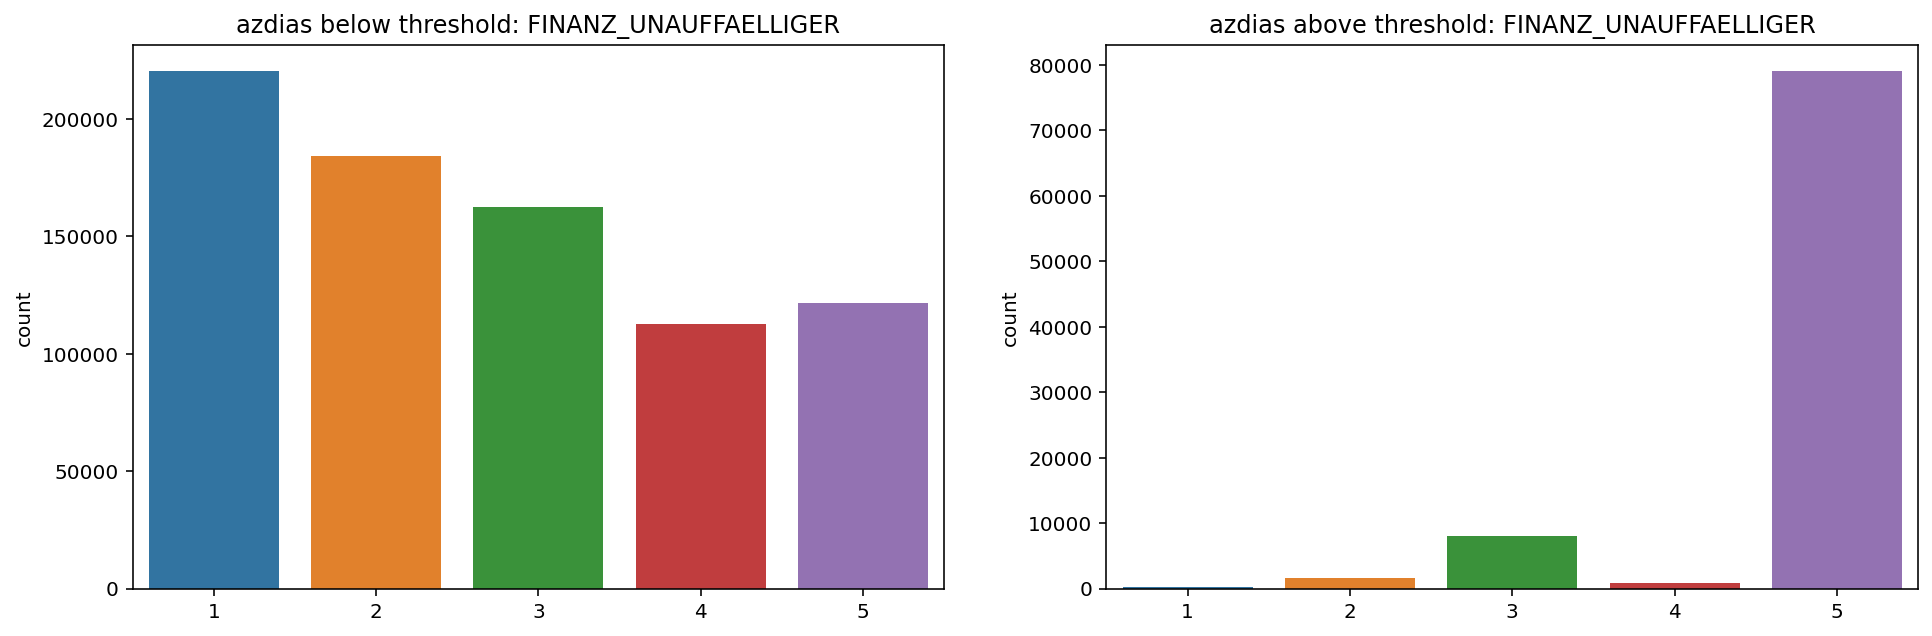

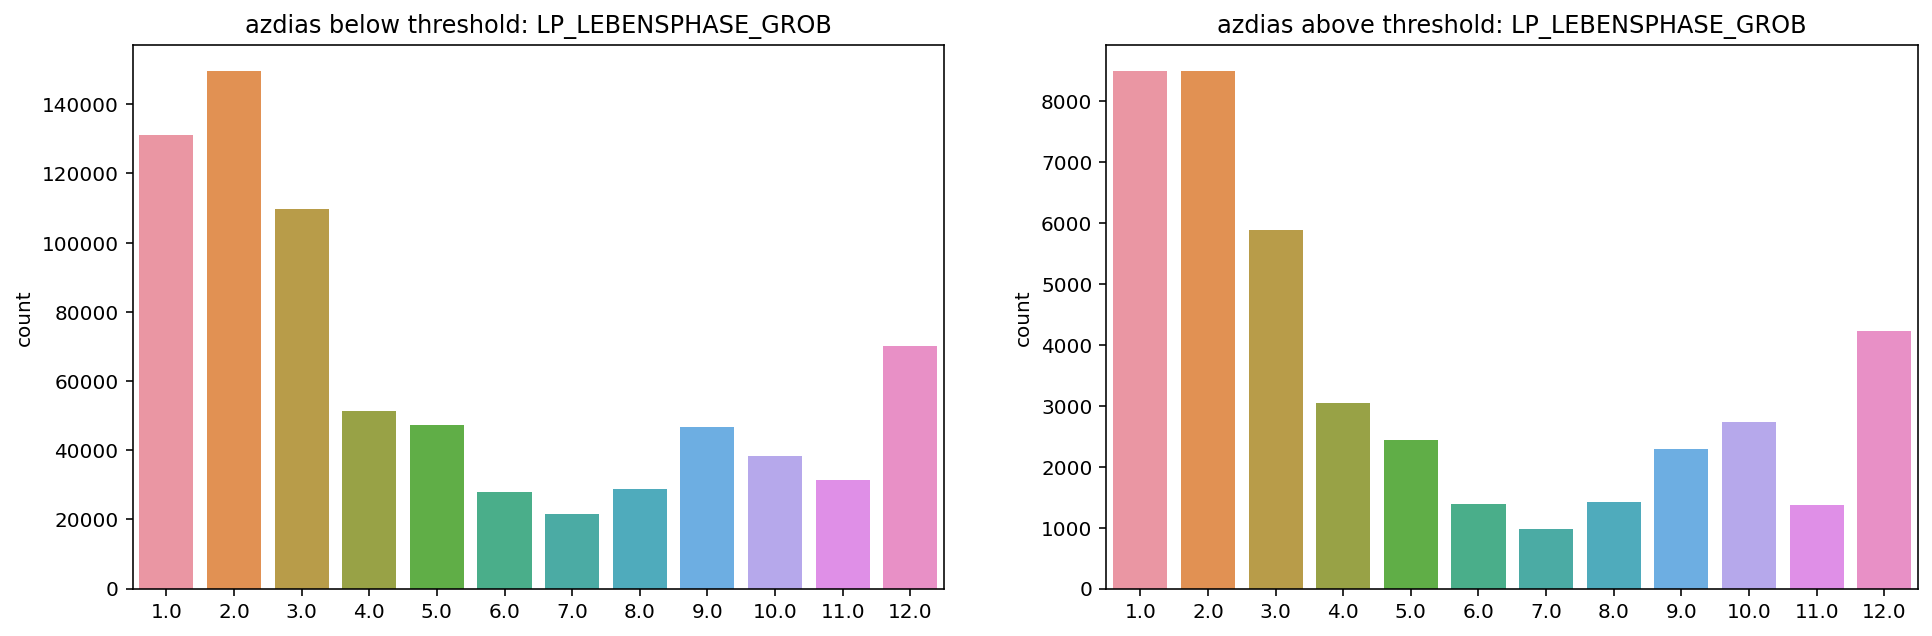

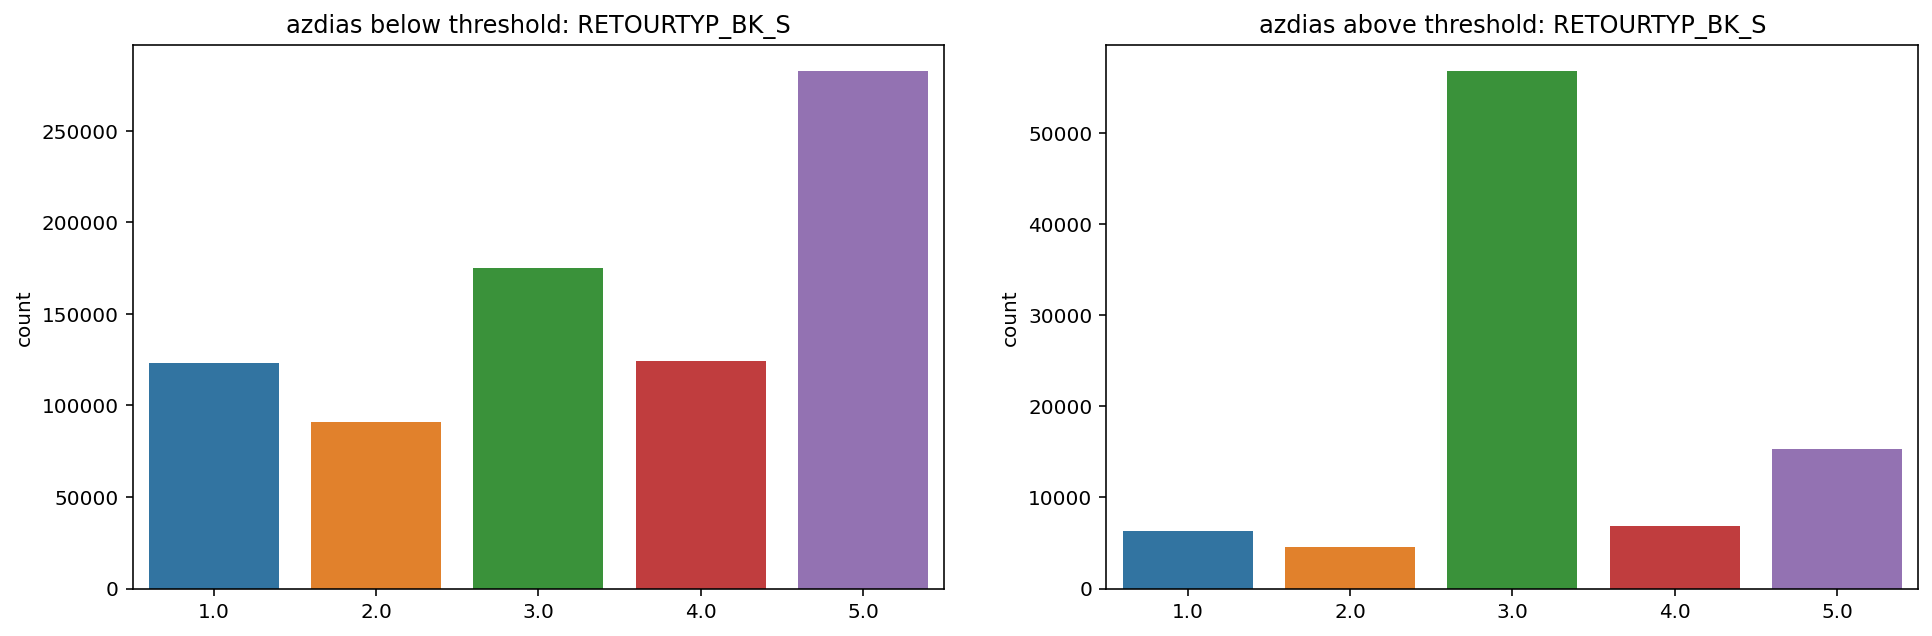

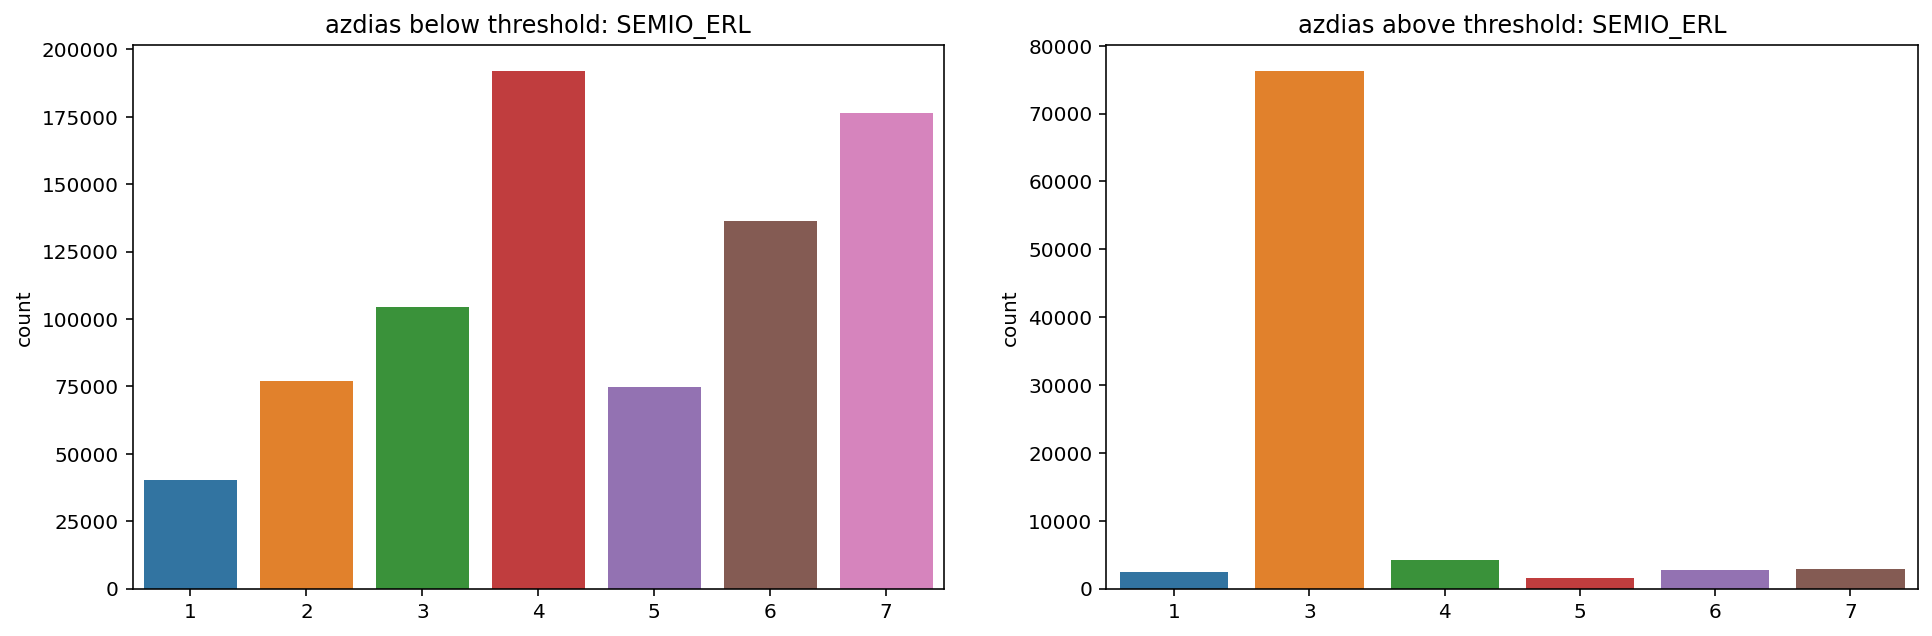







____________________________________________________________________________________________________________



Null Percentage Threshold: 5 %
Total Record Verification: True


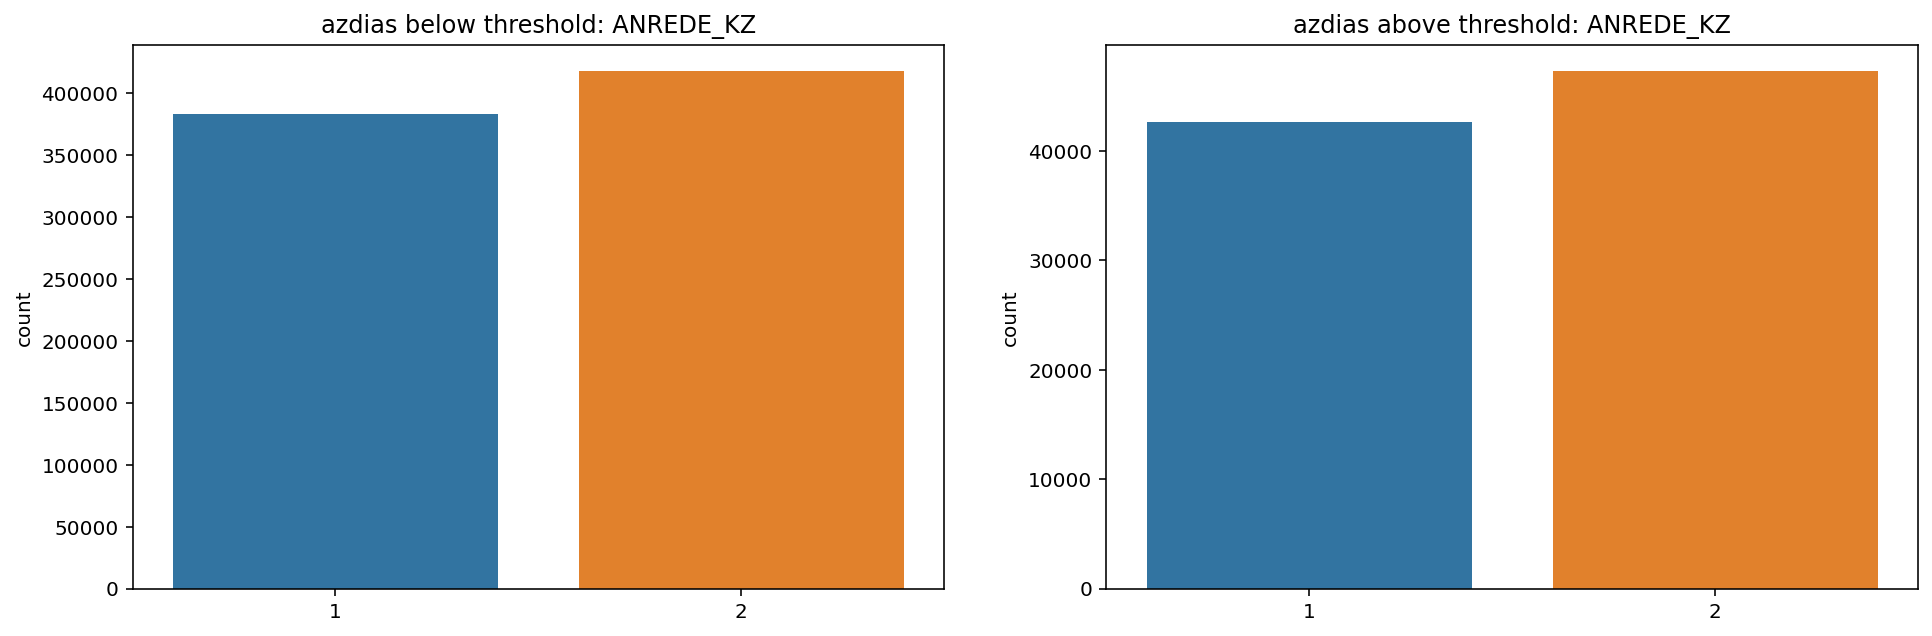

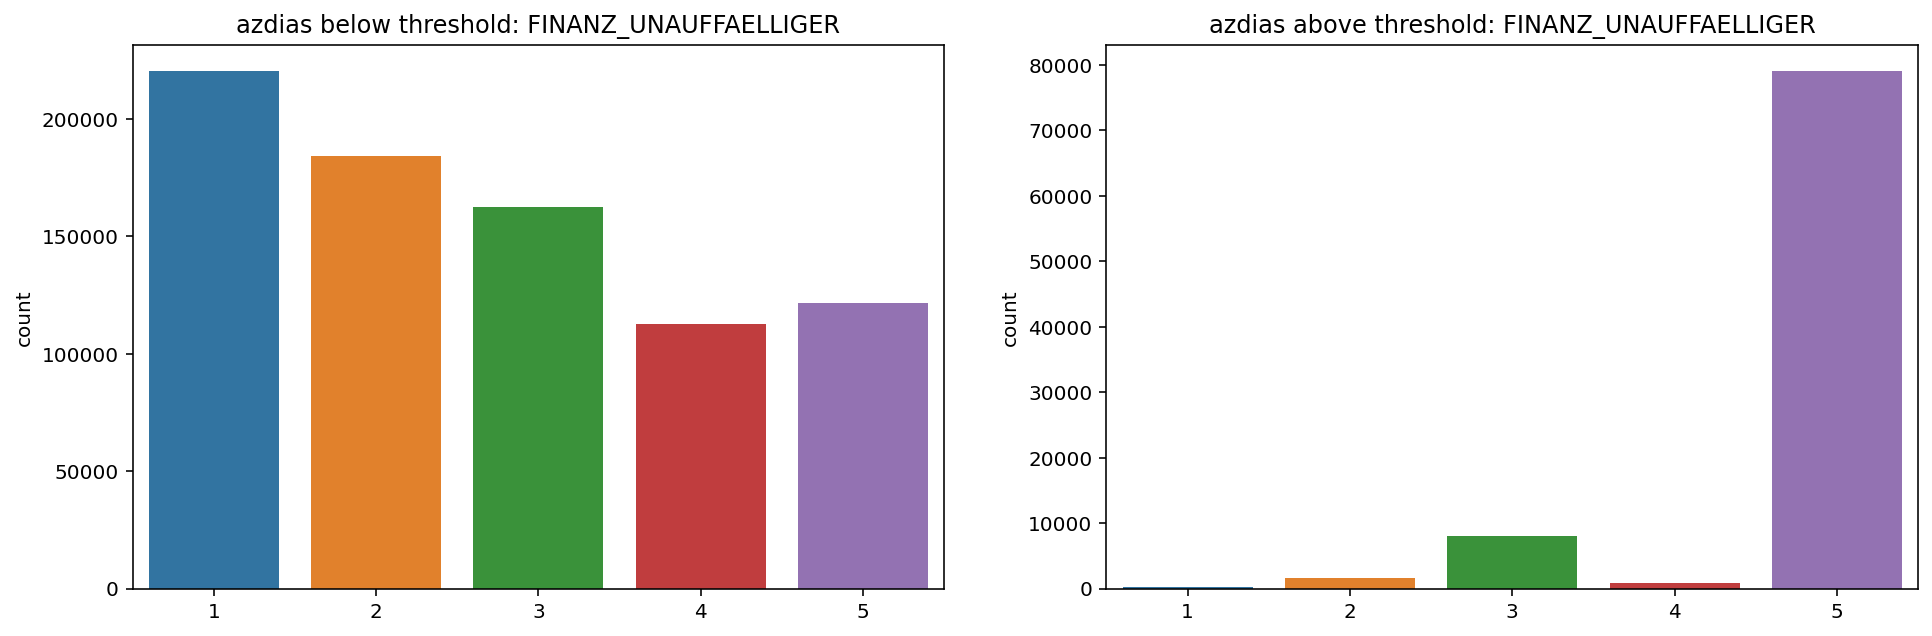

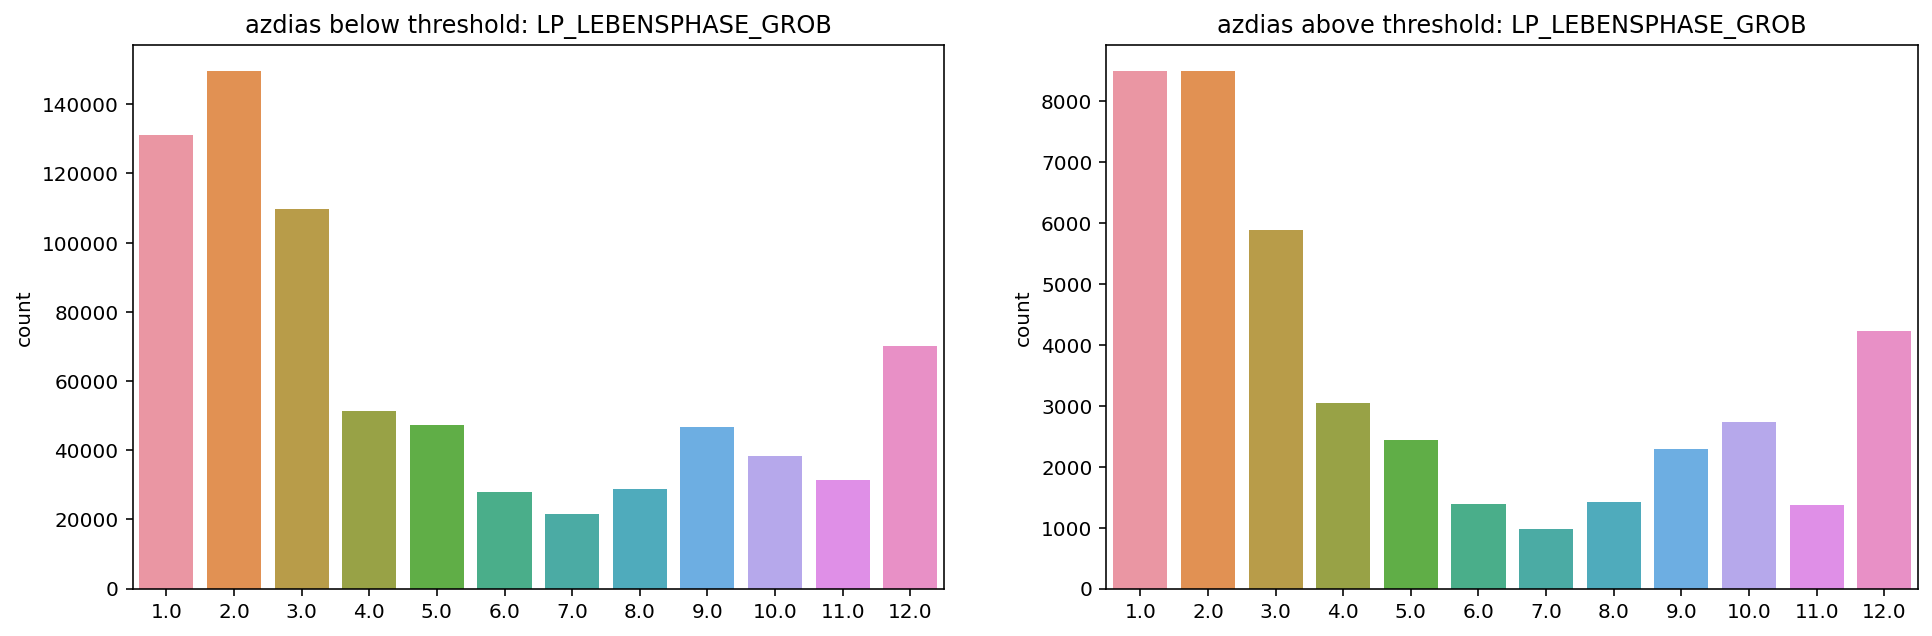

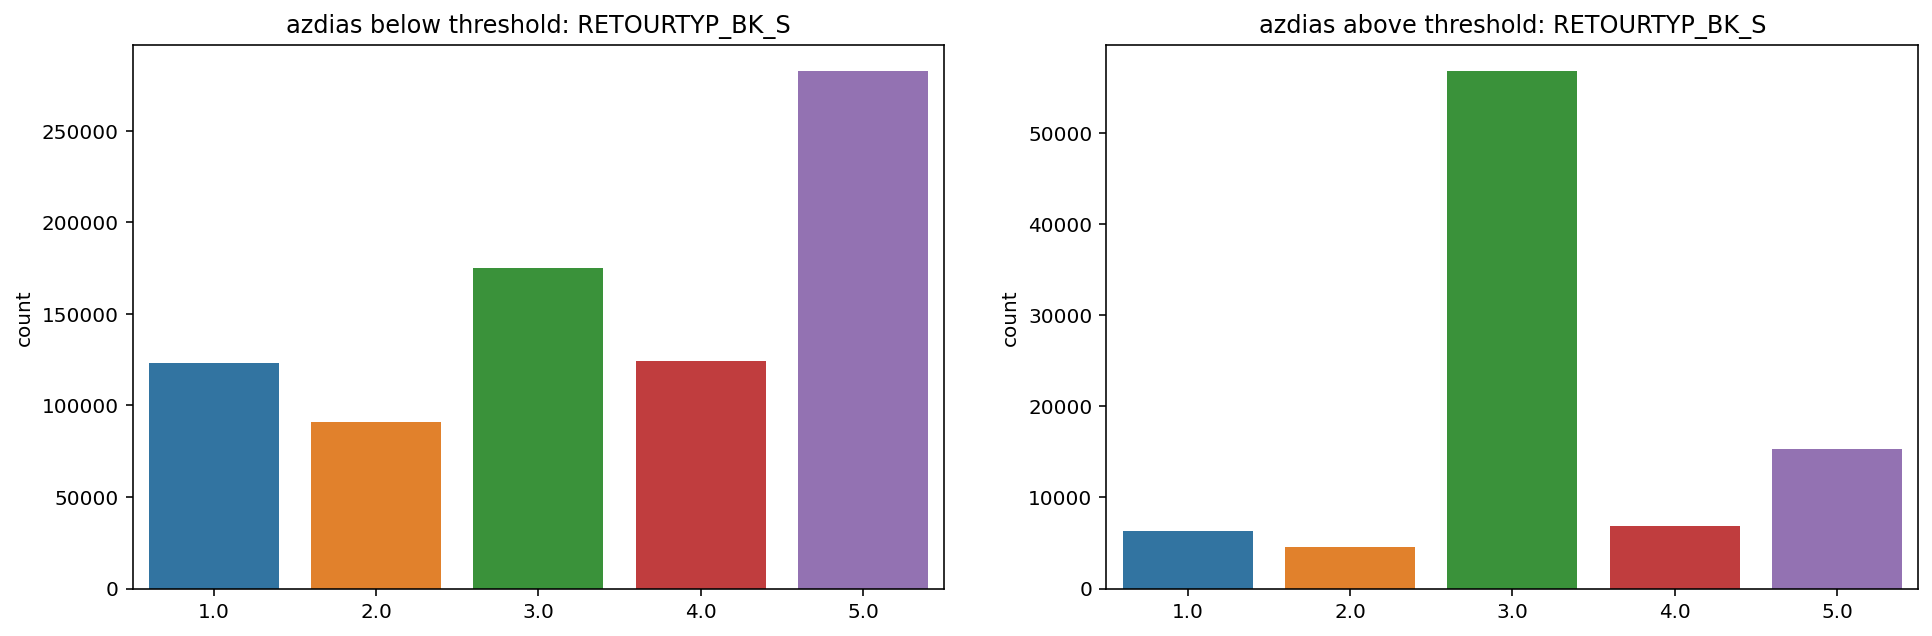

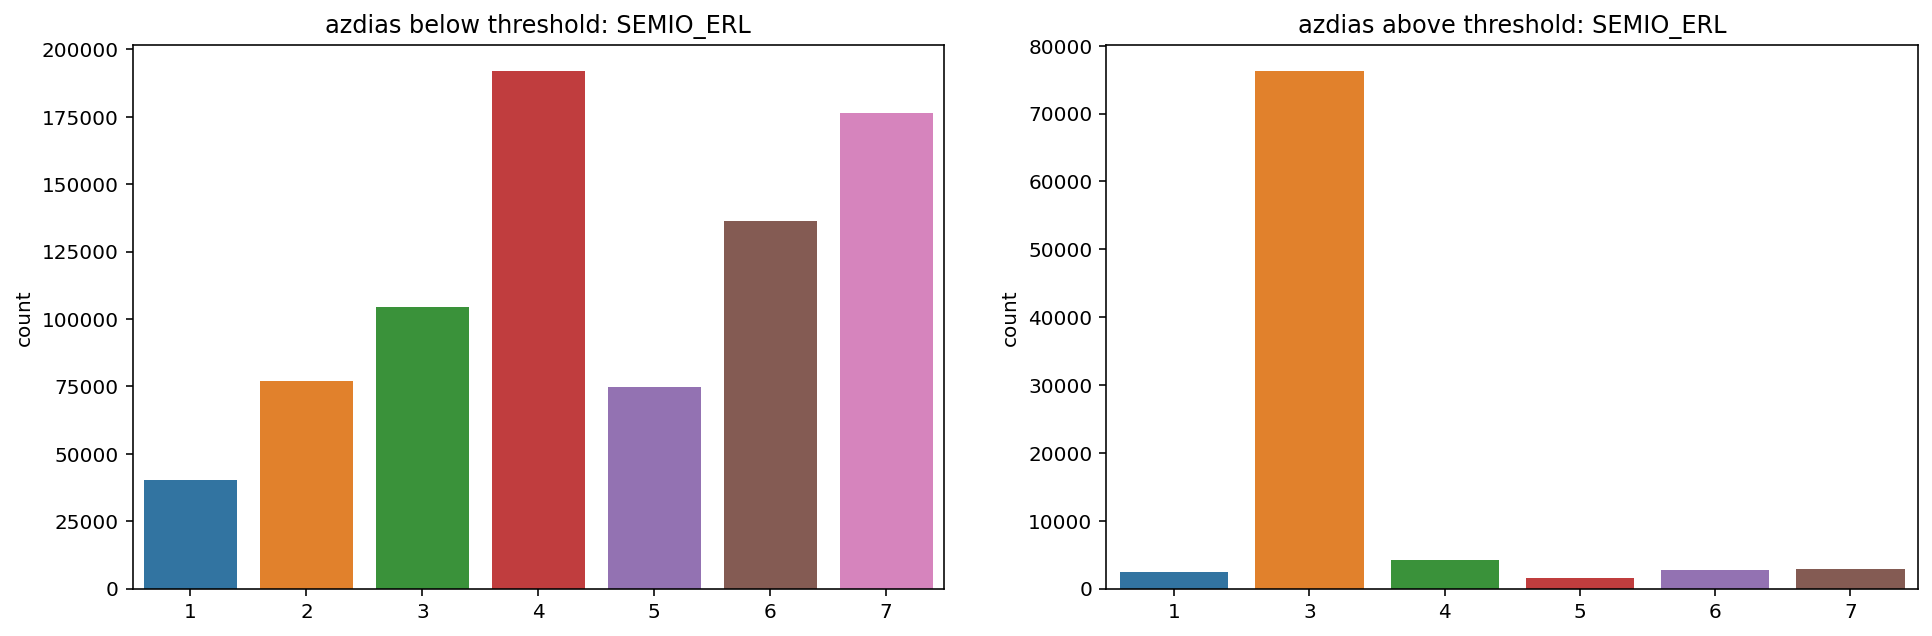




Null Percentage Threshold: 4 %
Total Record Verification: True


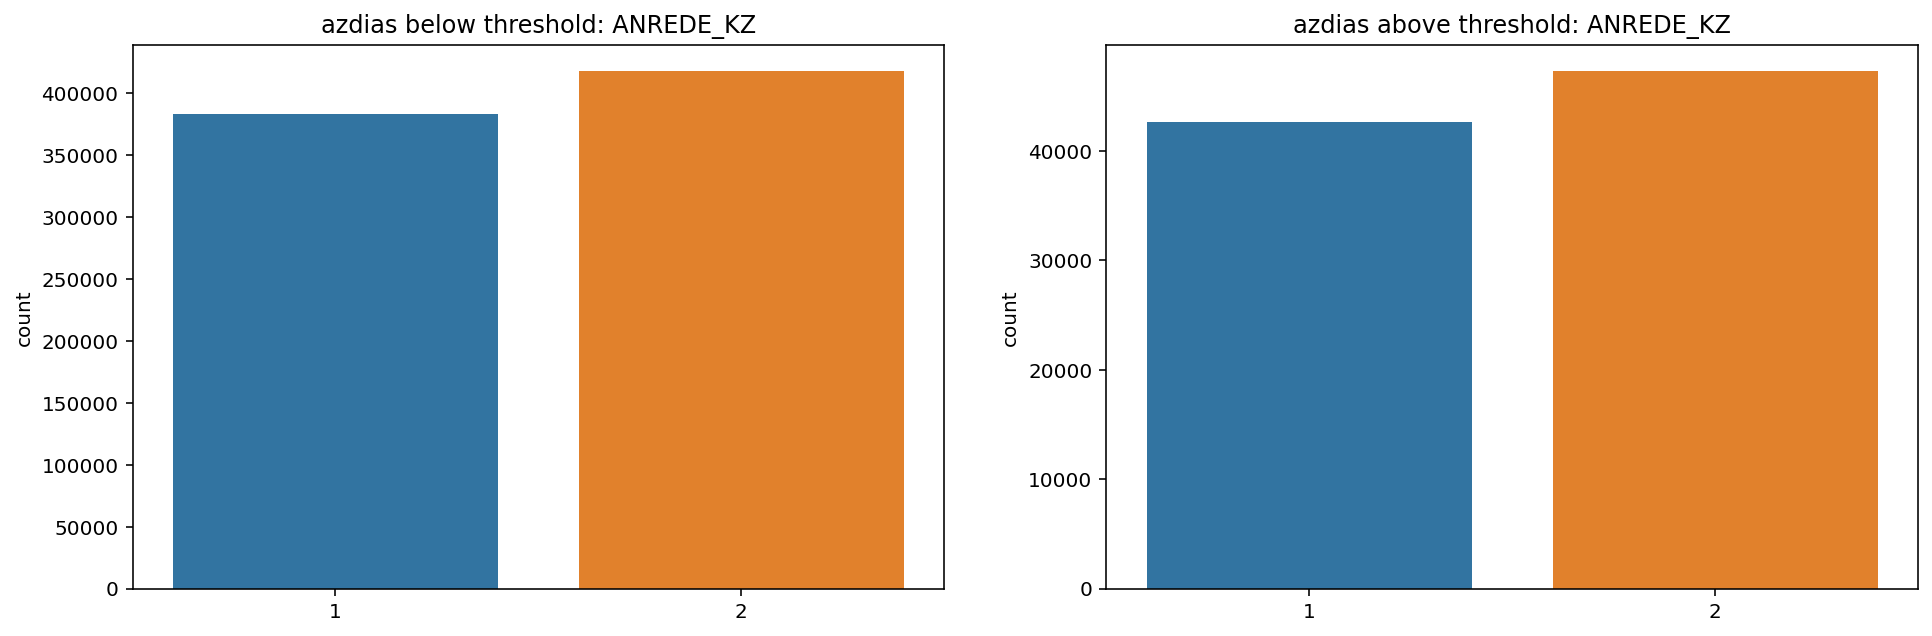

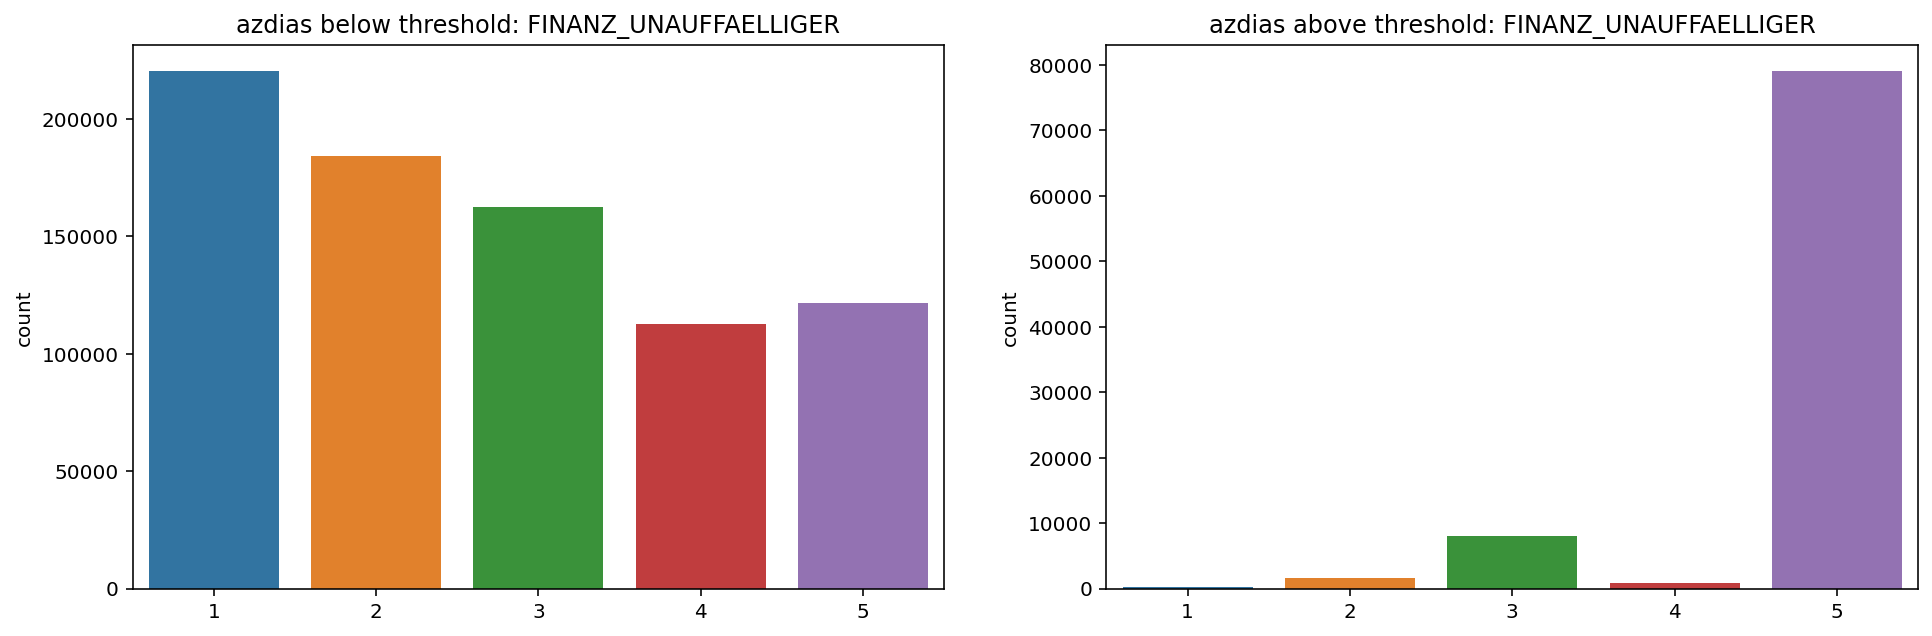

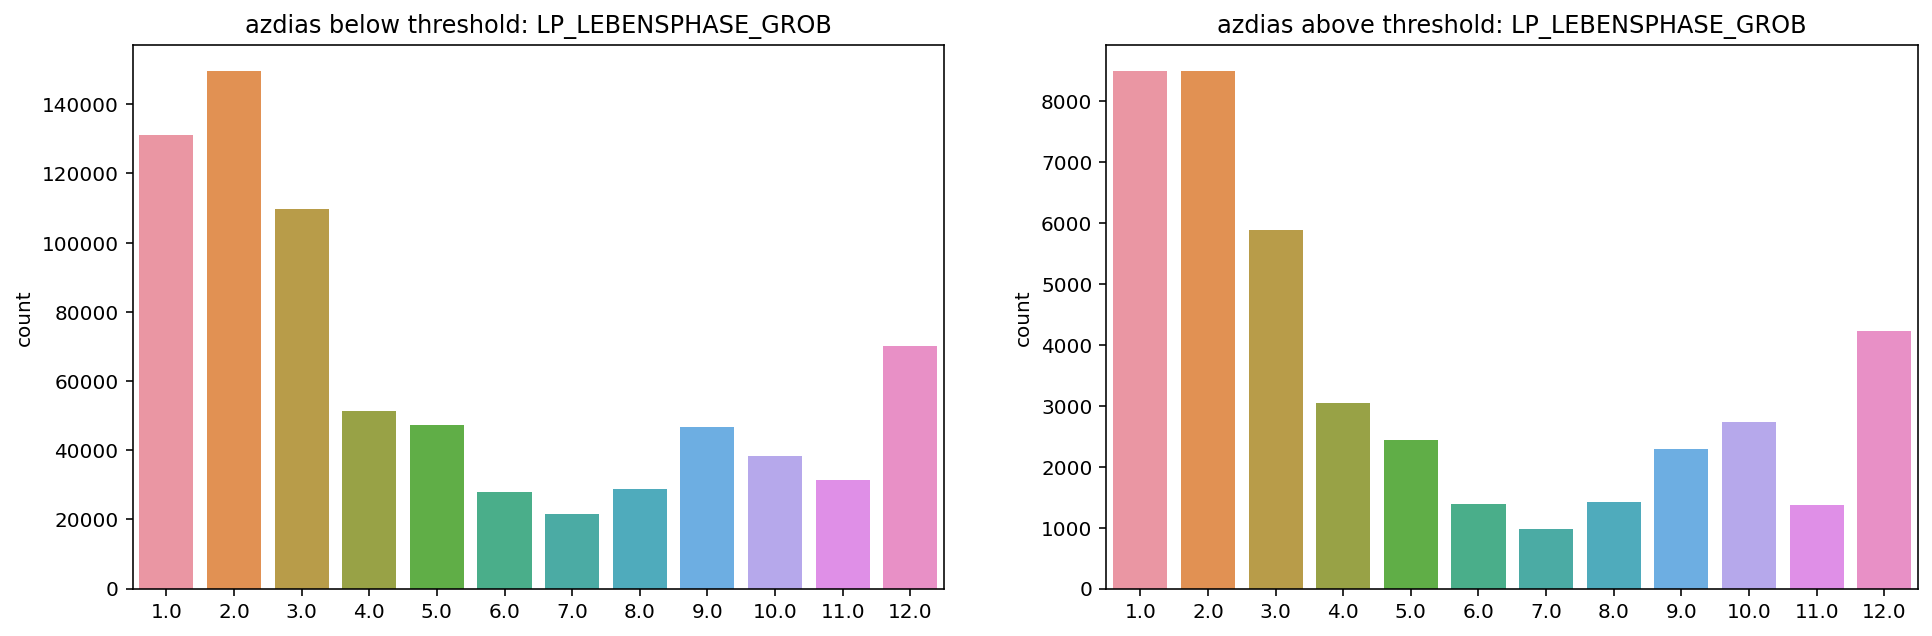

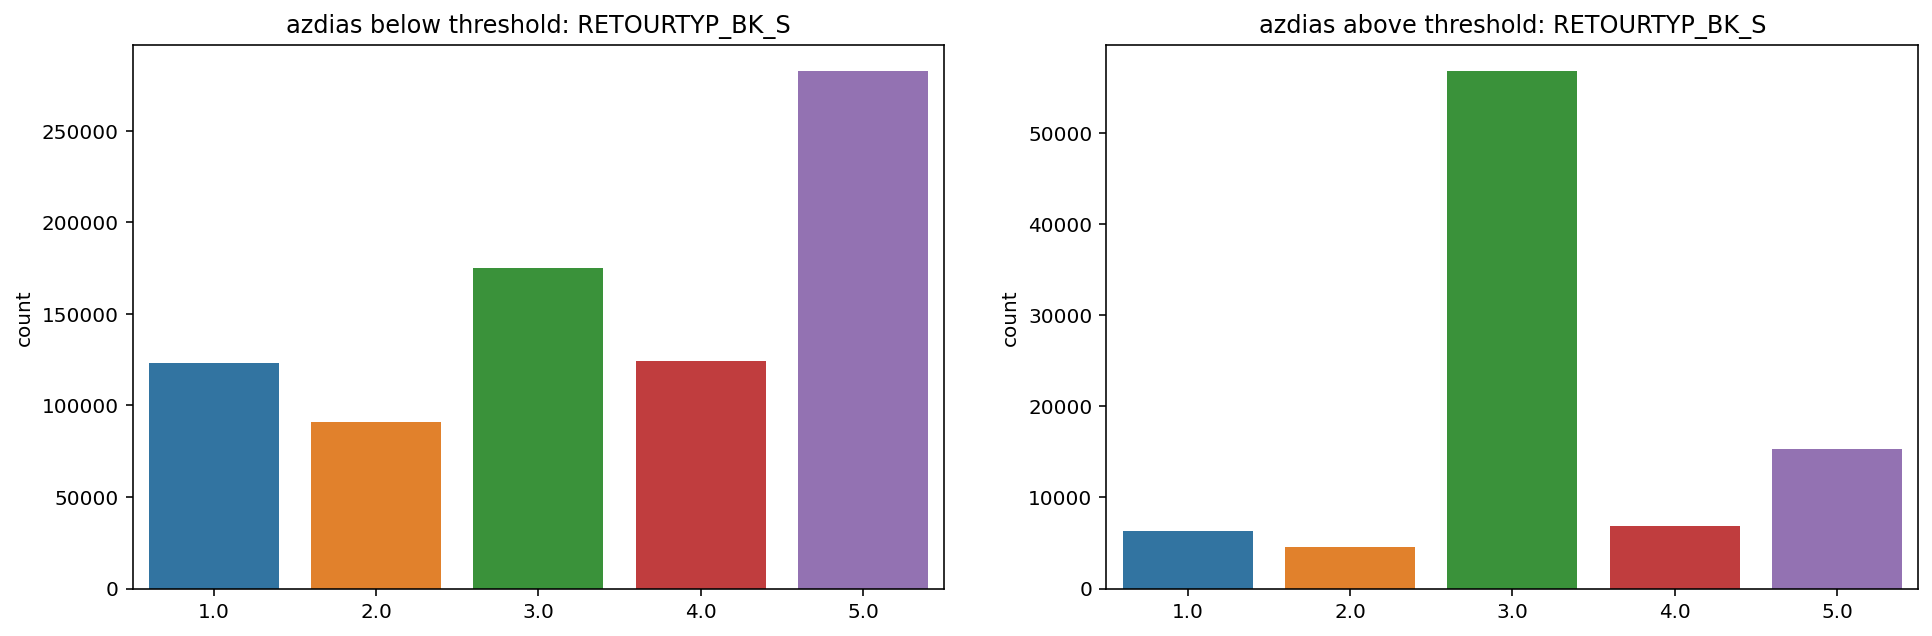

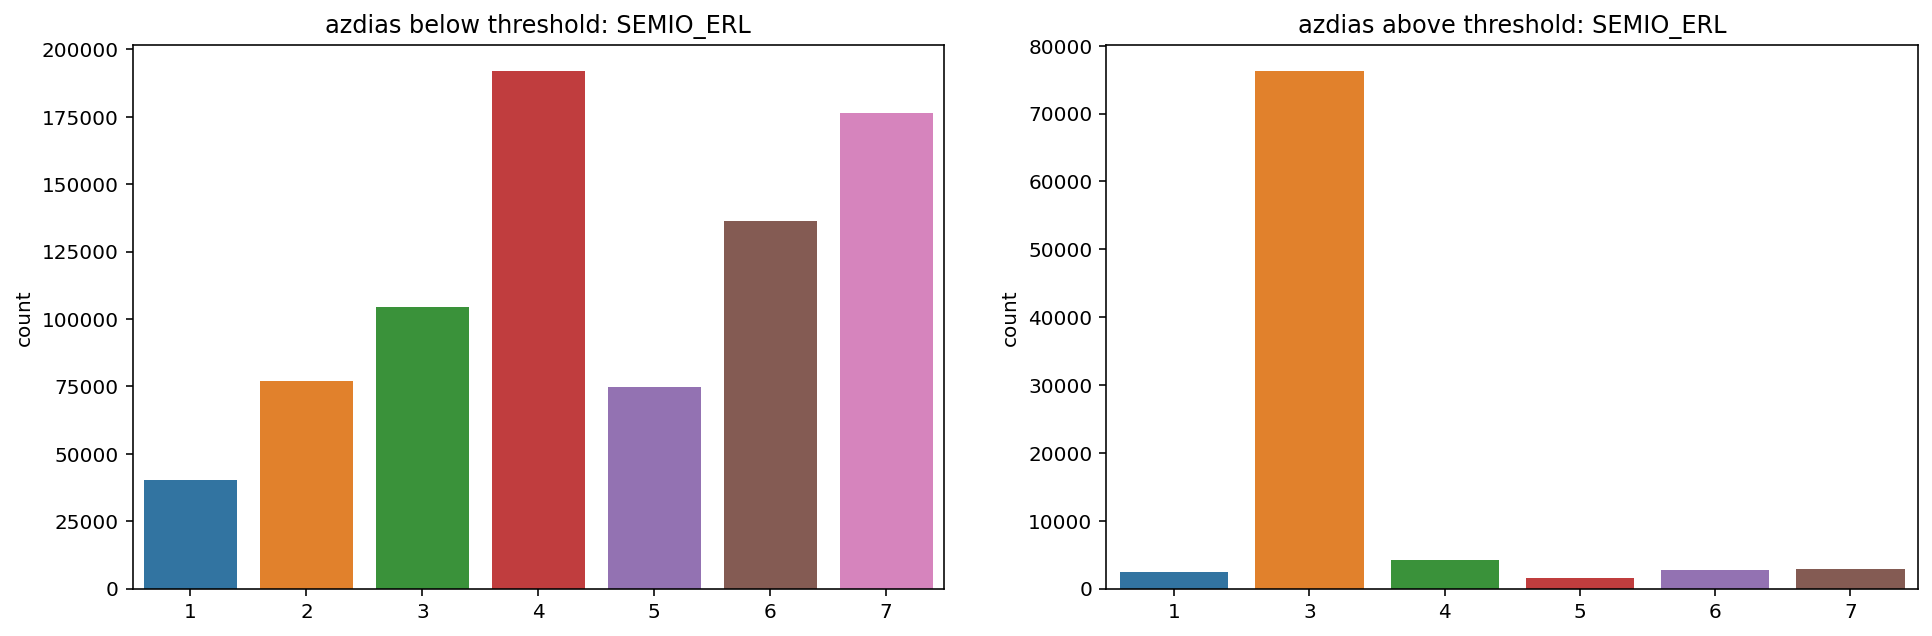




Null Percentage Threshold: 3 %
Total Record Verification: True


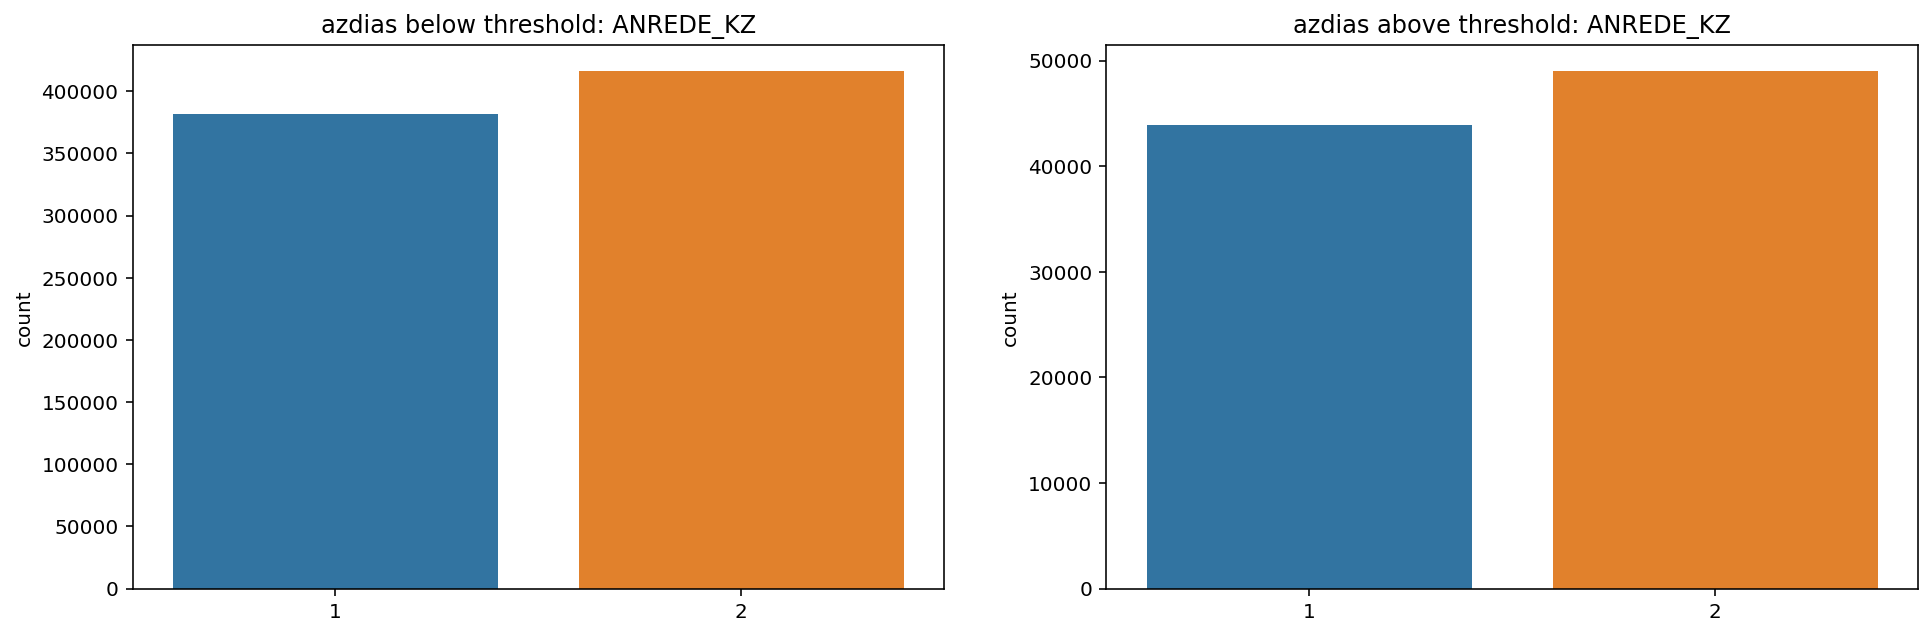

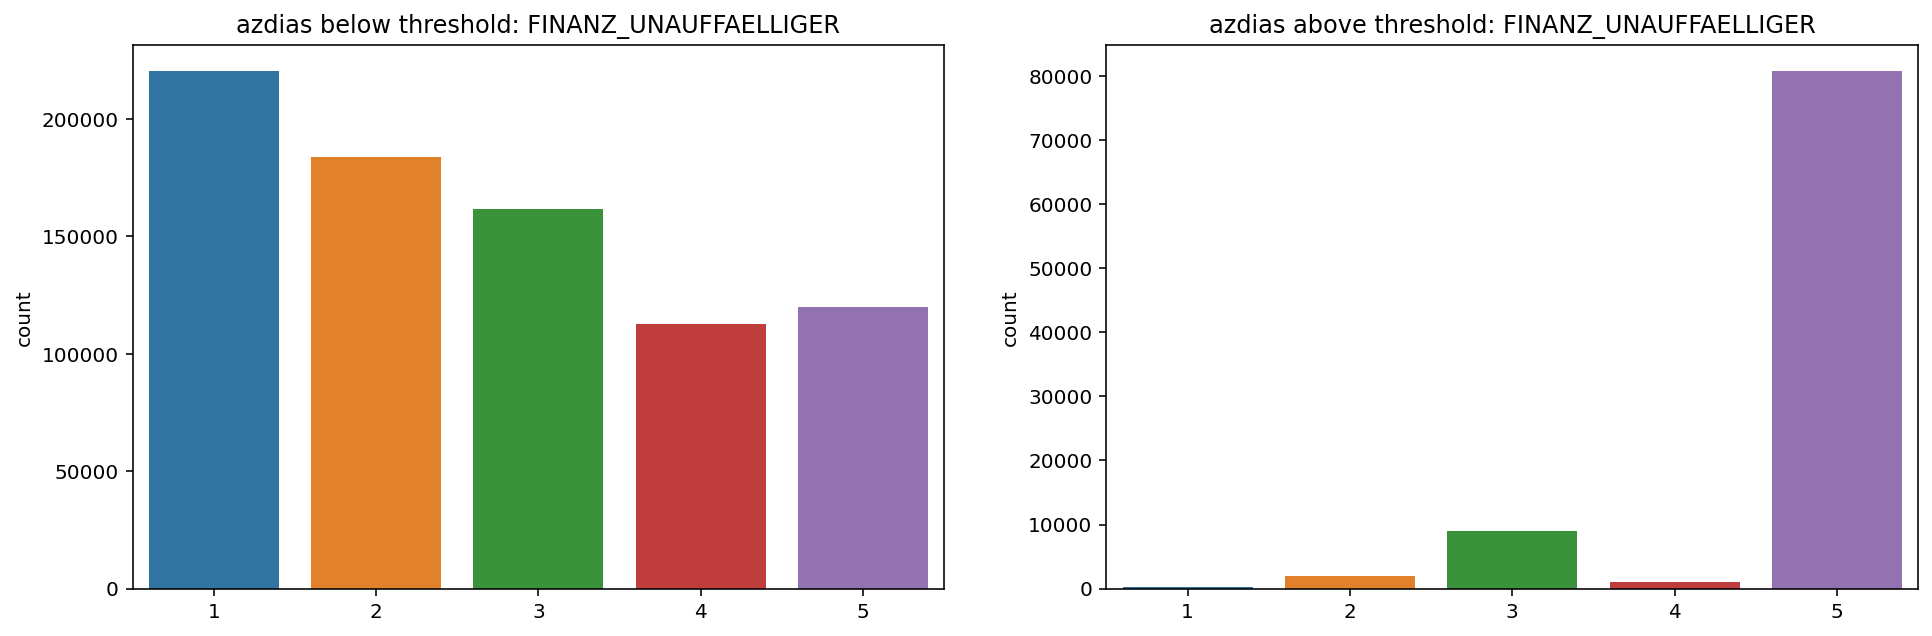

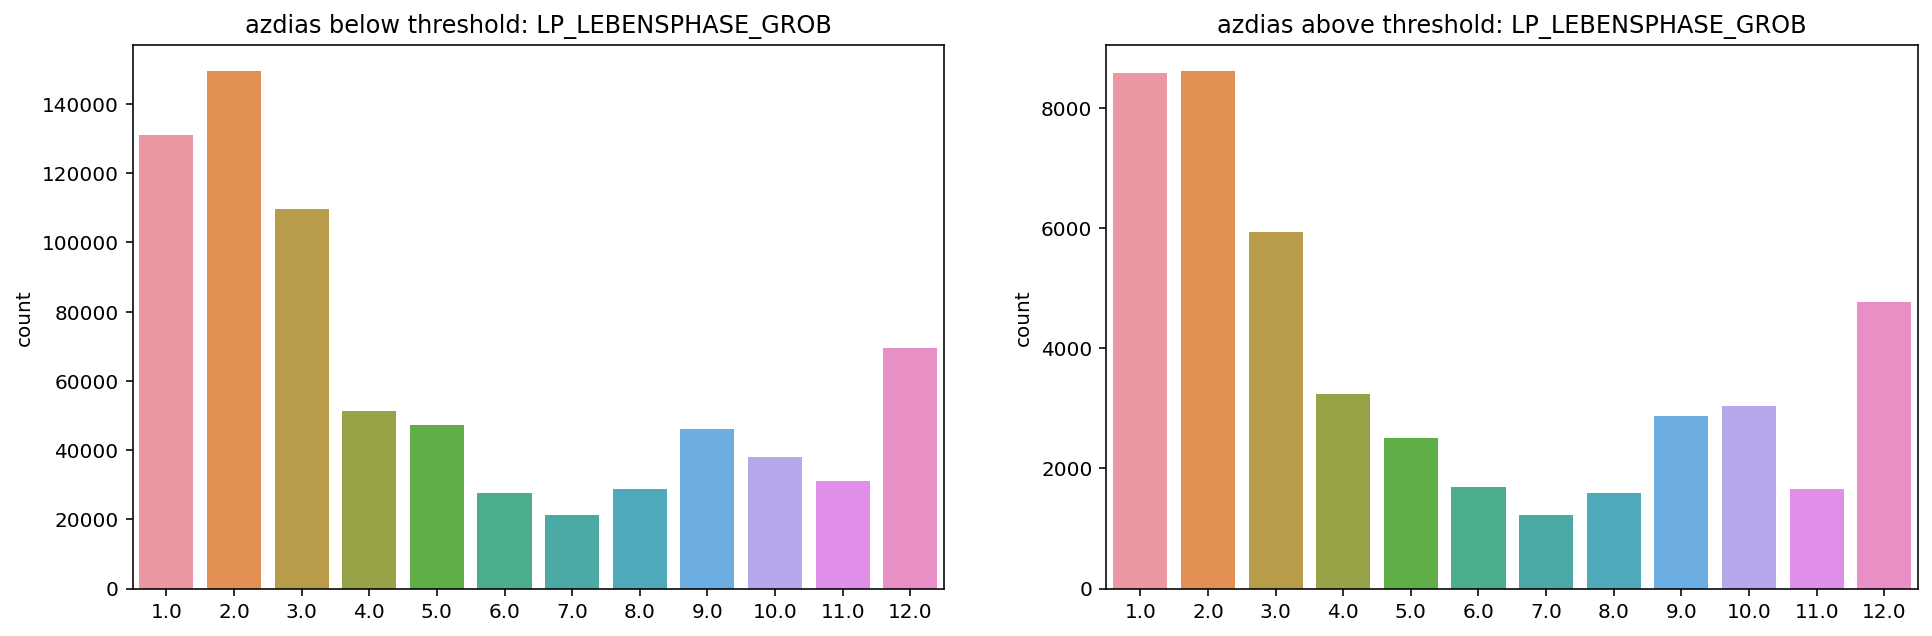

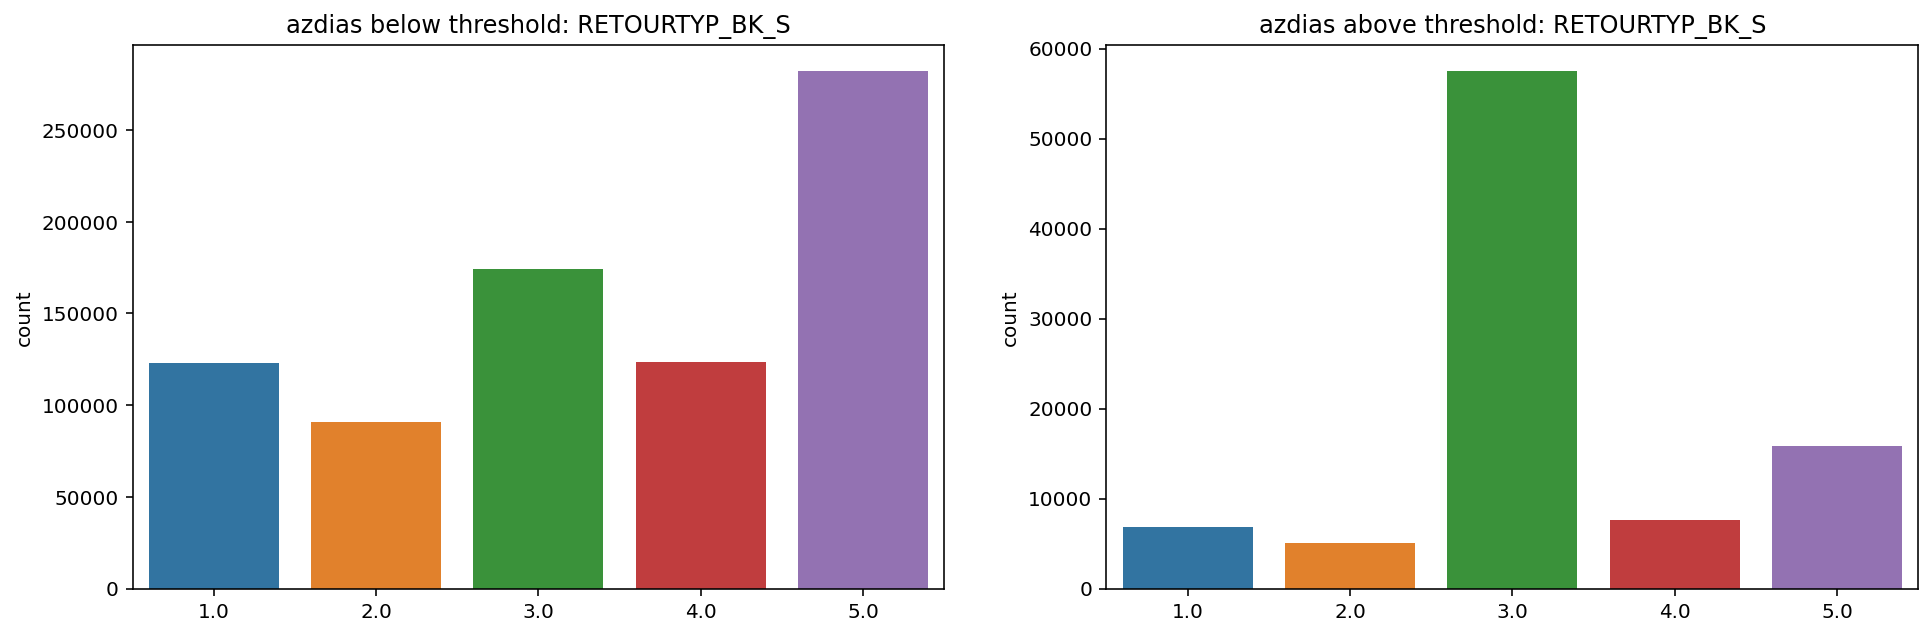

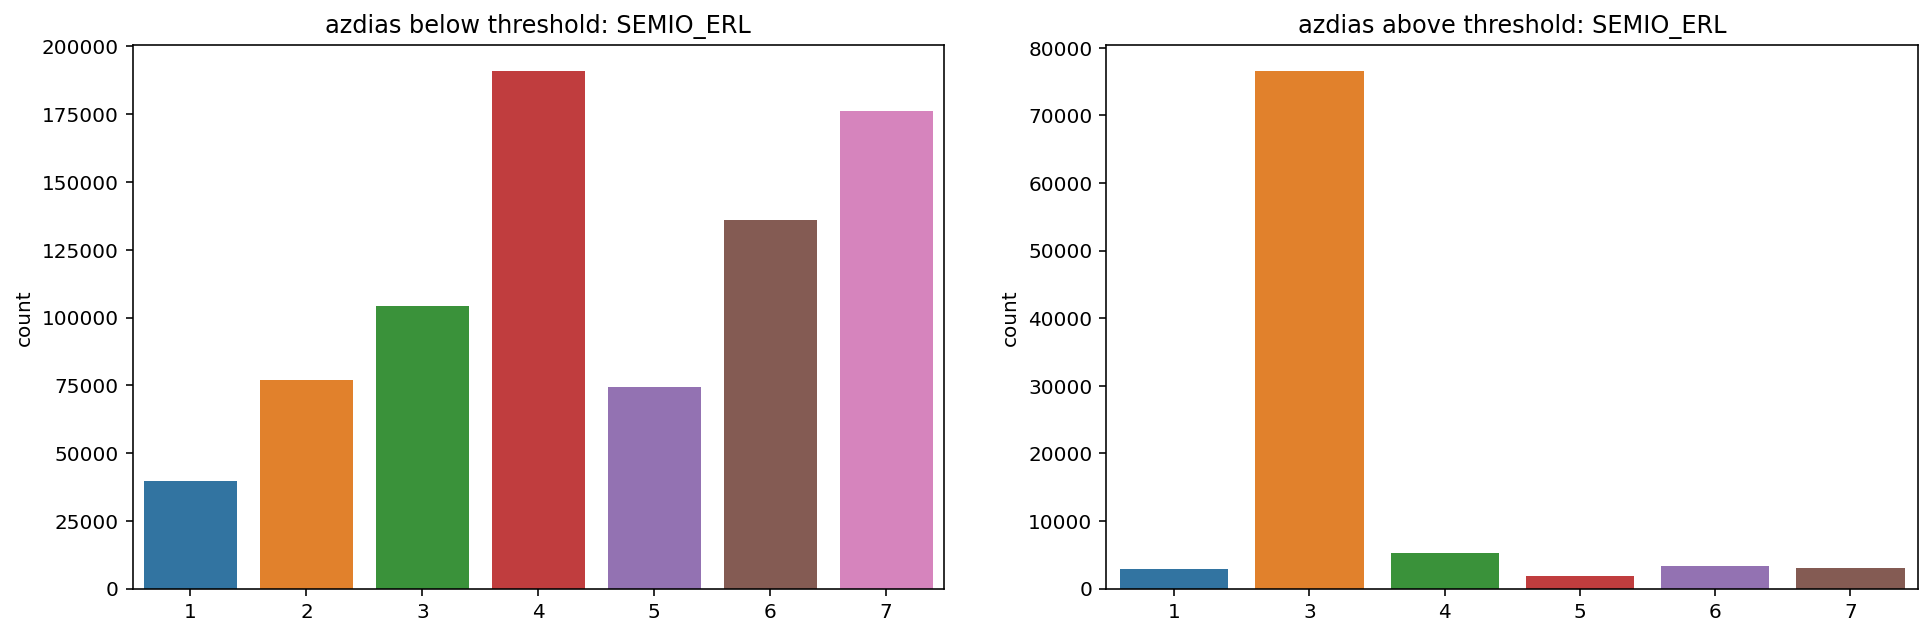




Null Percentage Threshold: 2 %
Total Record Verification: True


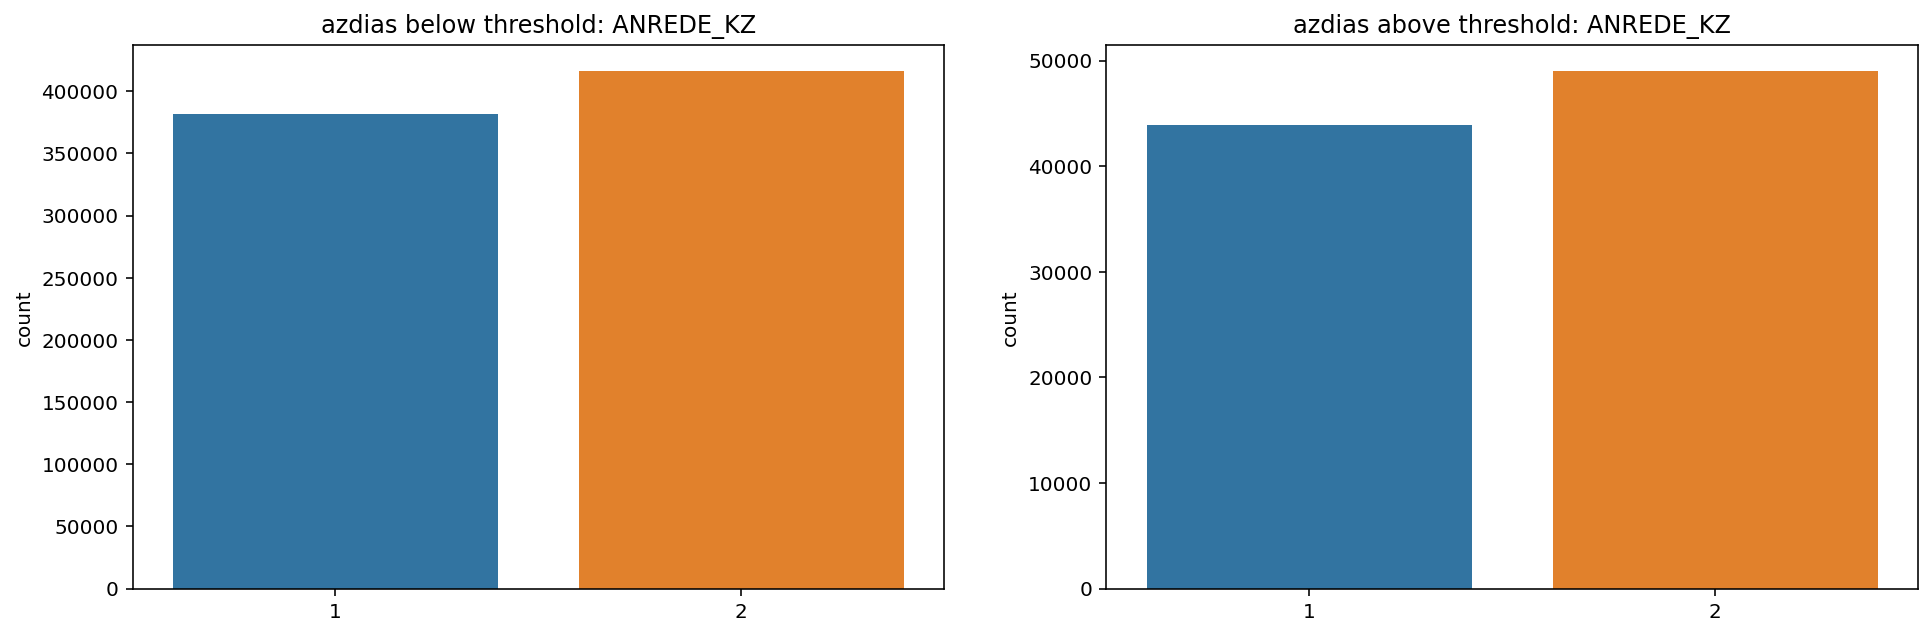

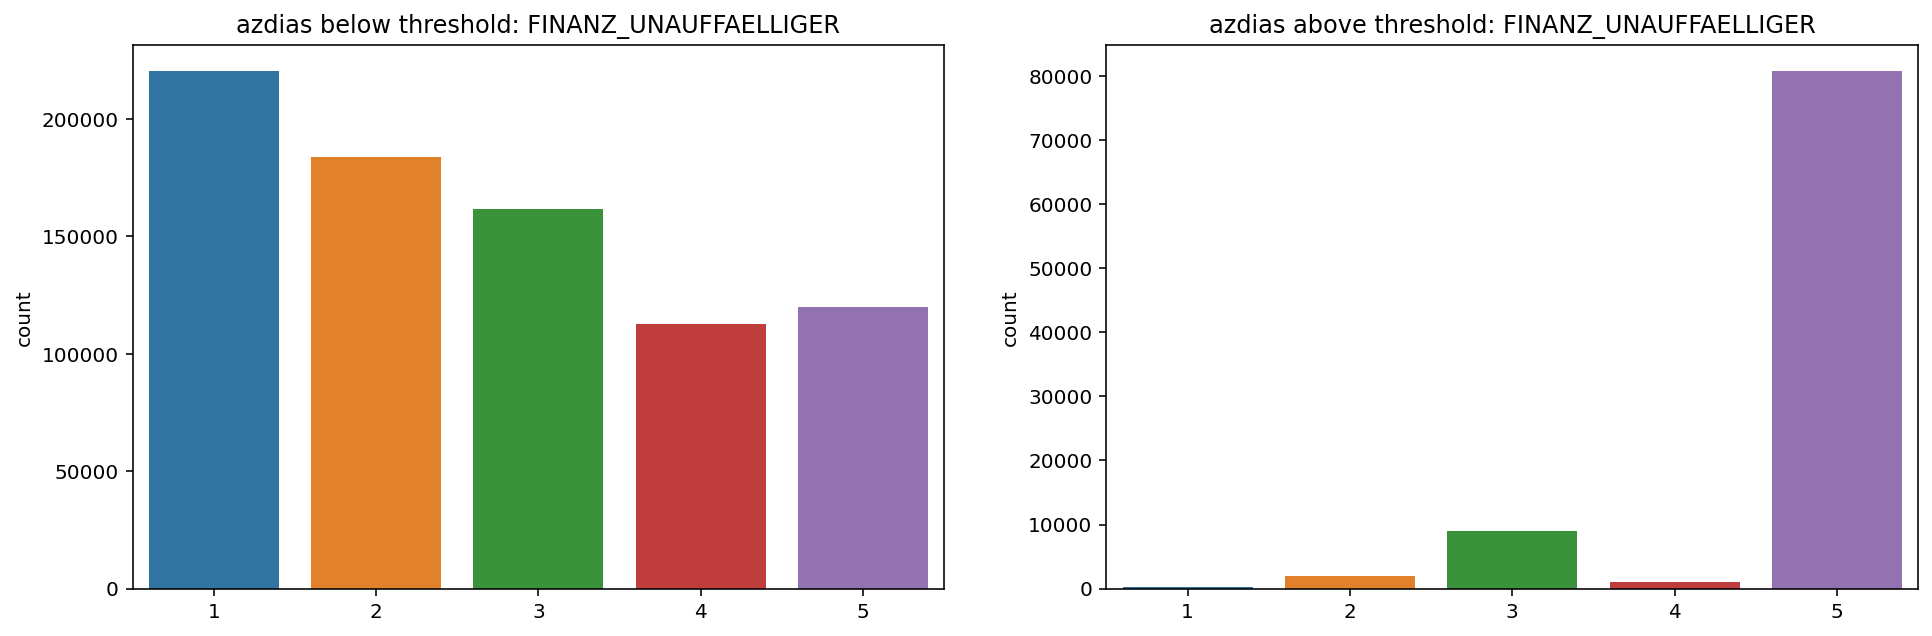

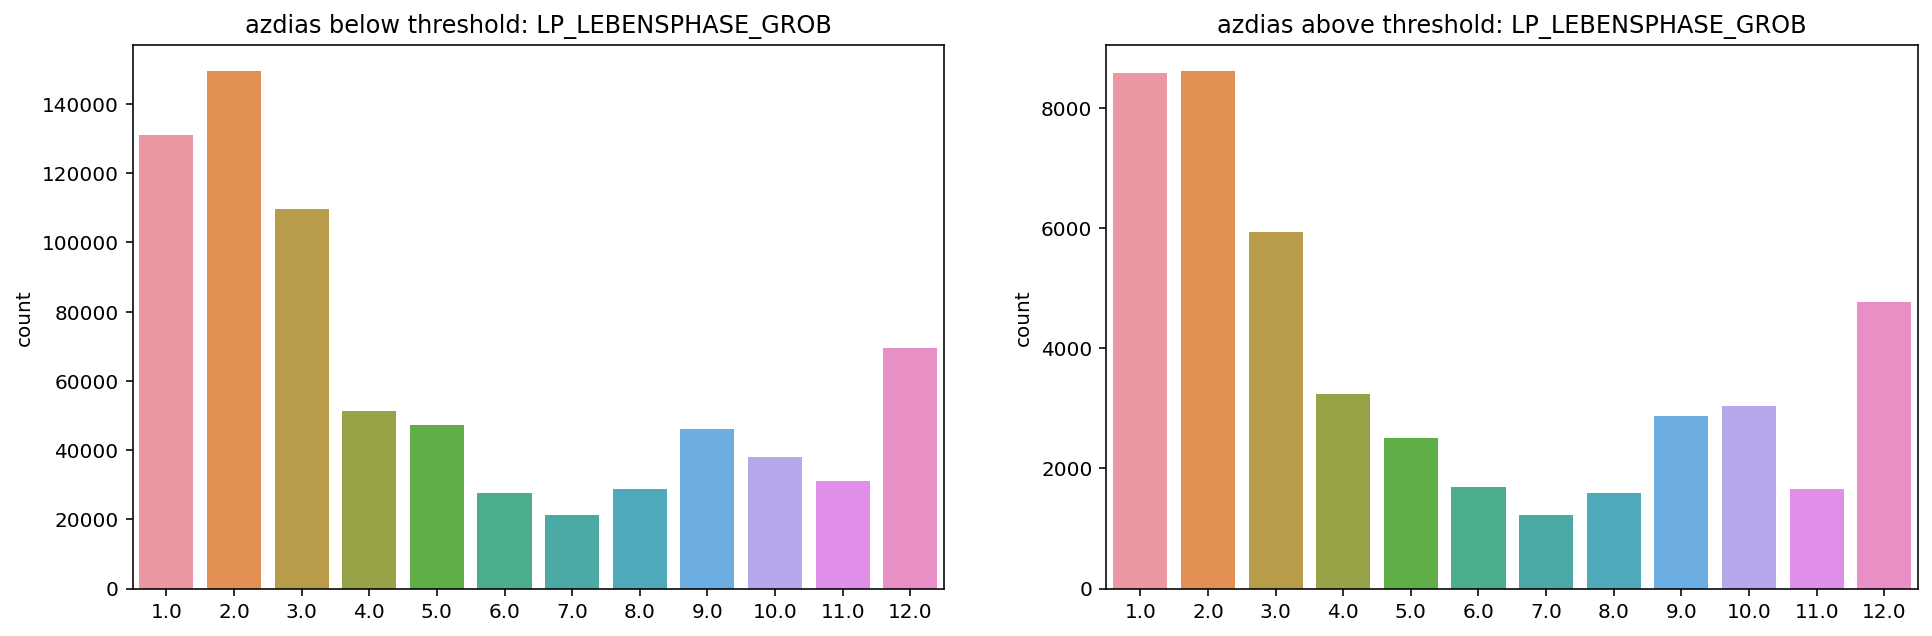

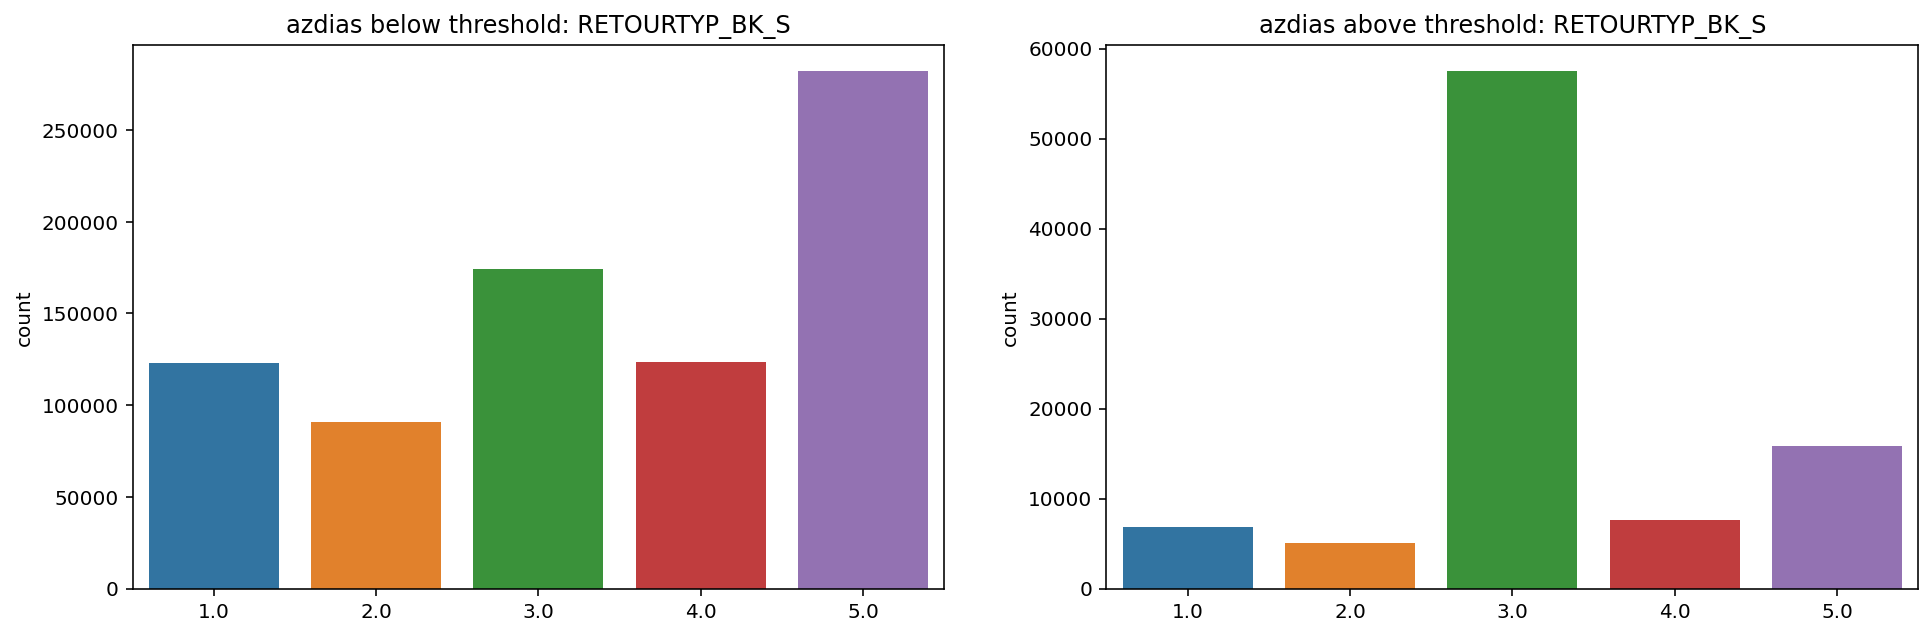

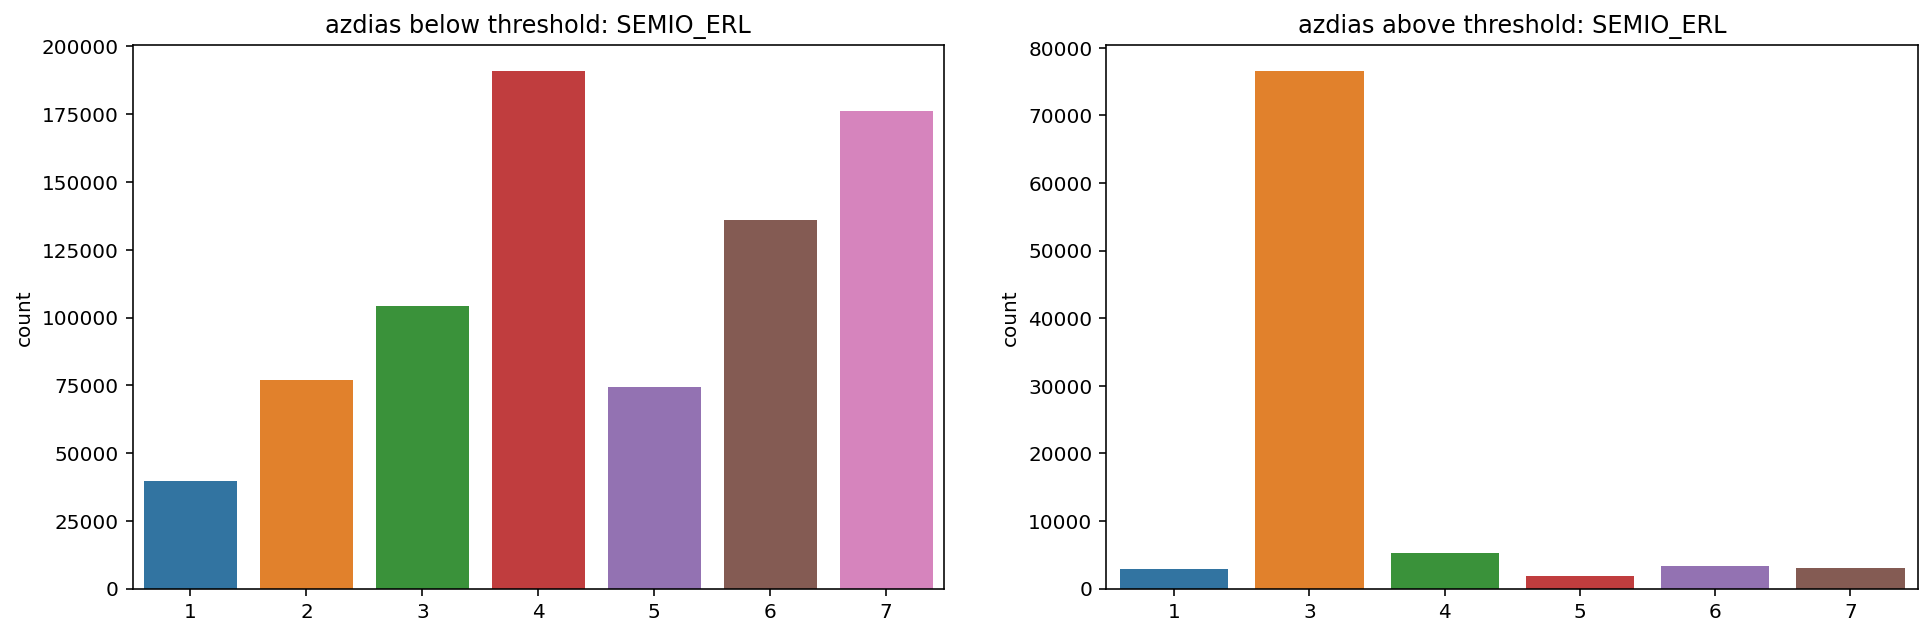




Null Percentage Threshold: 1 %
Total Record Verification: True


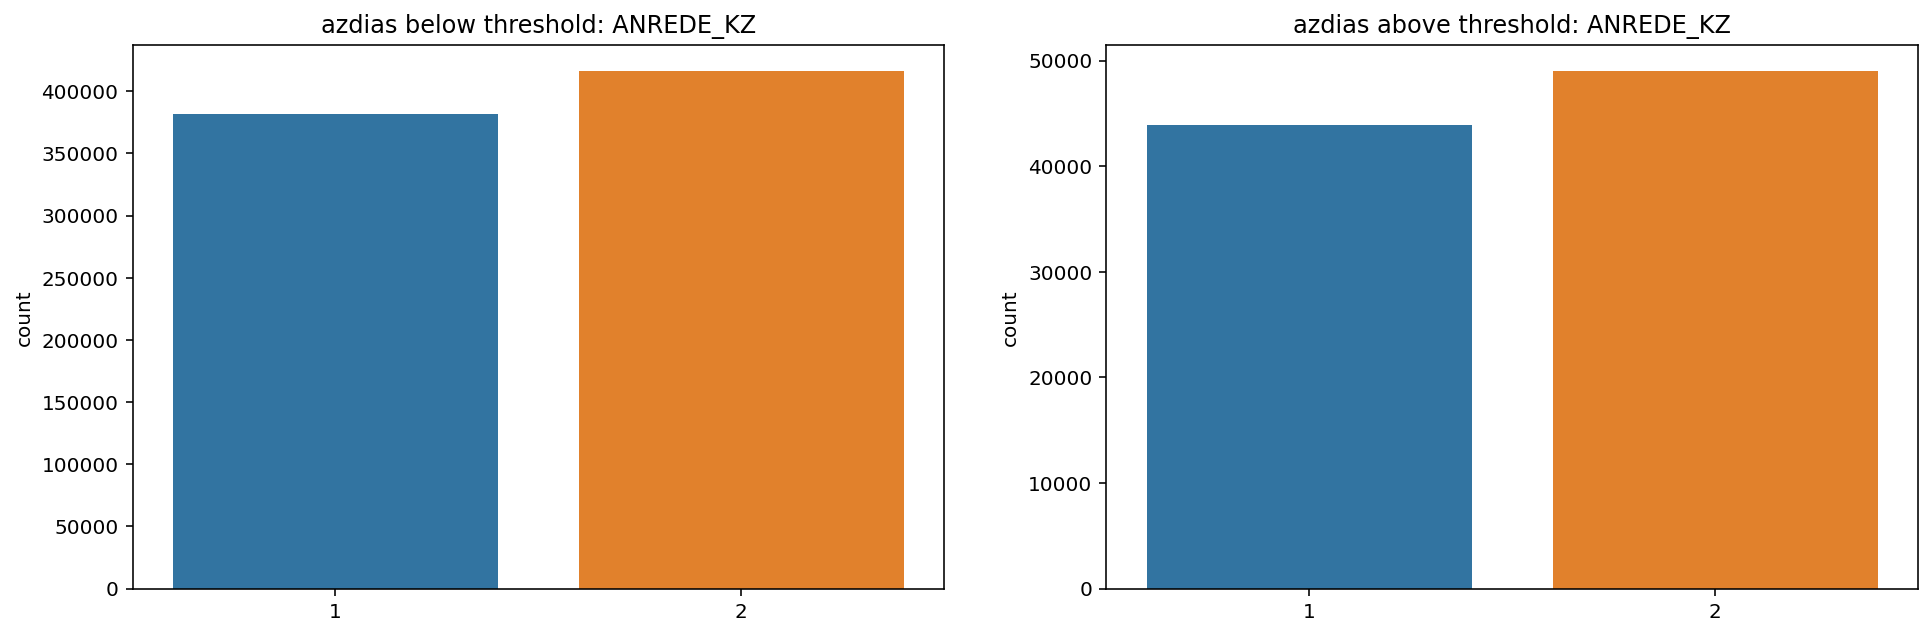

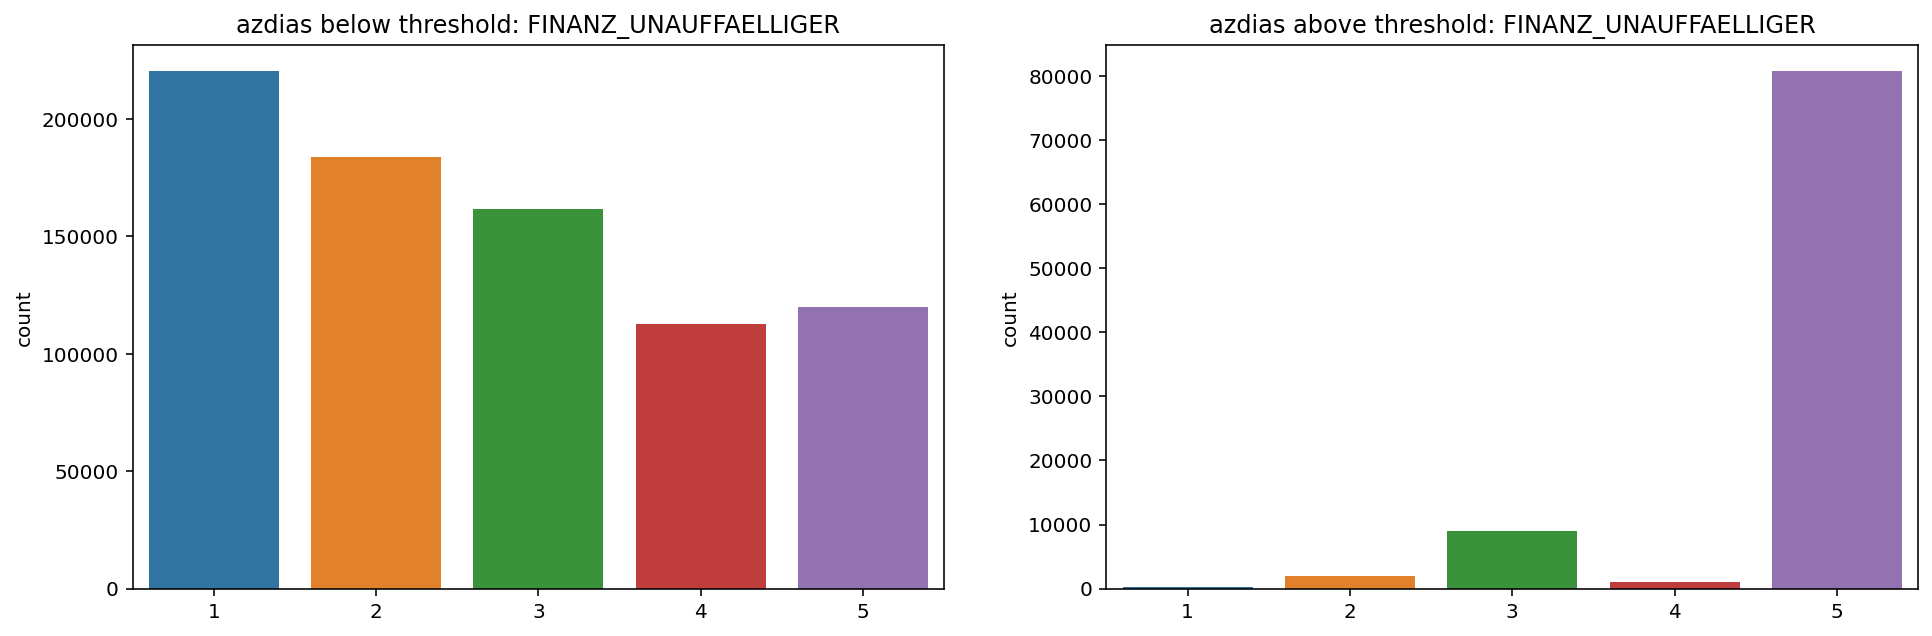

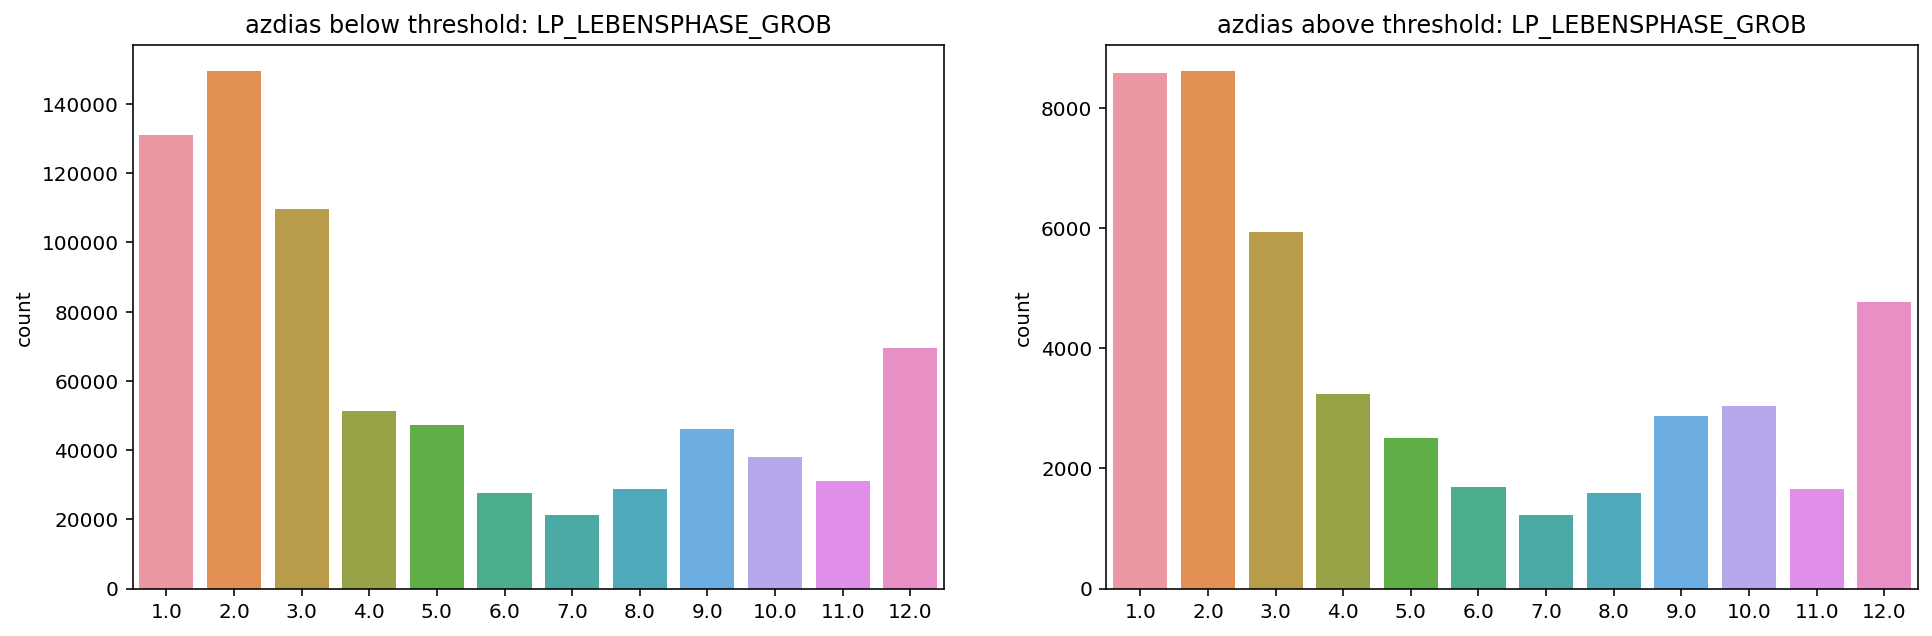

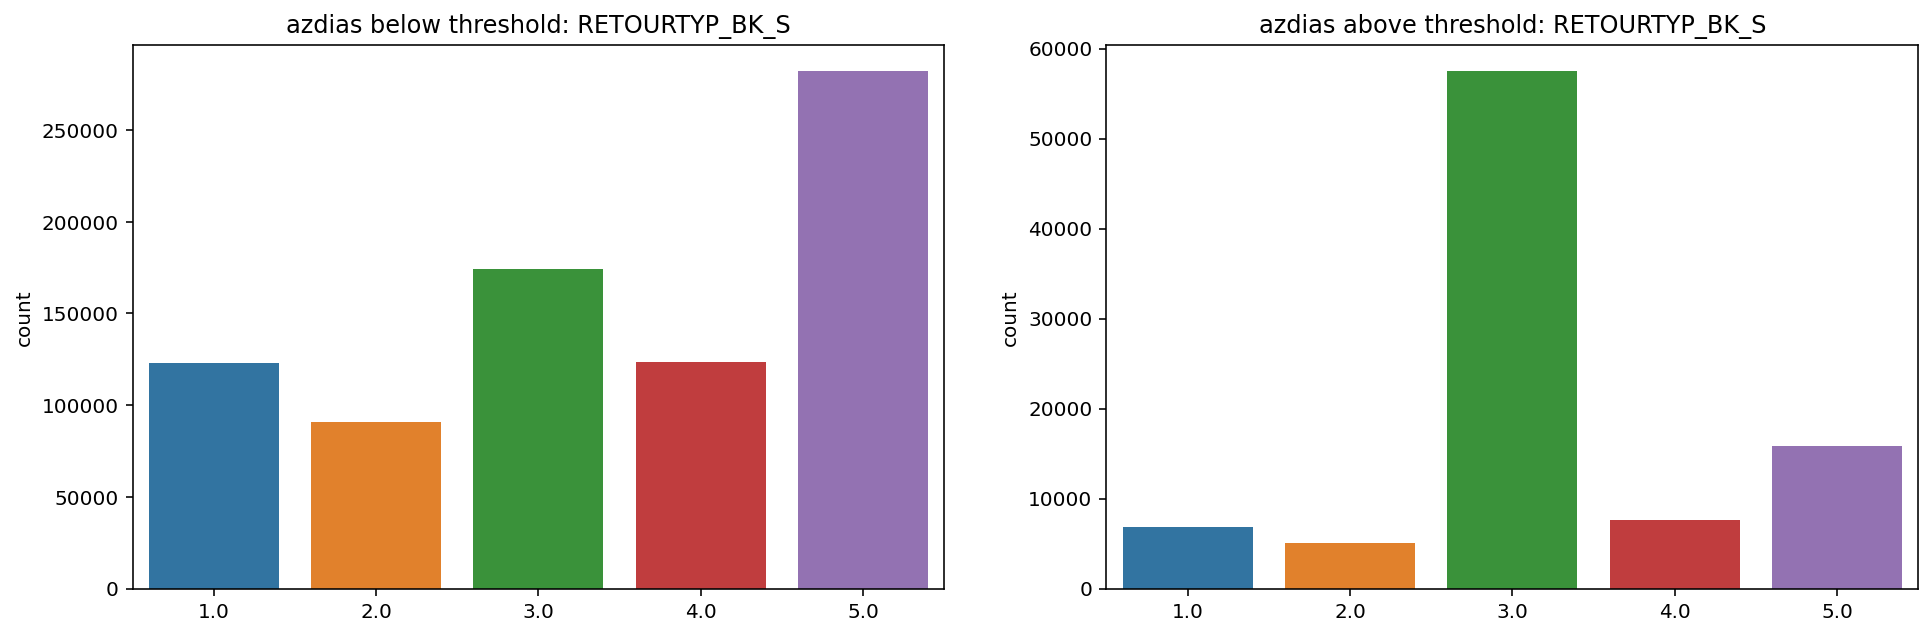

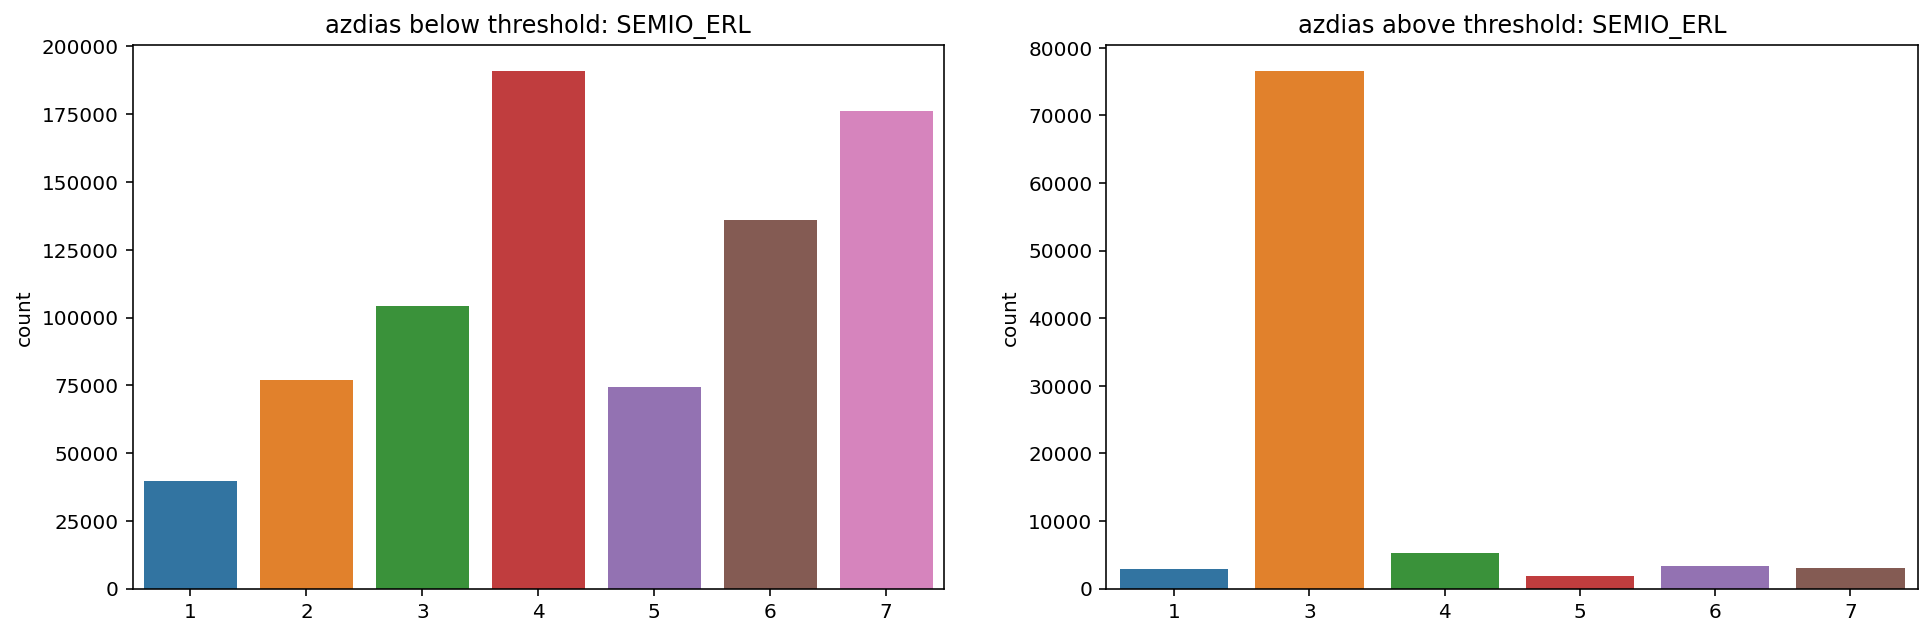

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
    
def two_df(i):
    print(f'Null Percentage Threshold: {i} %')
    above_thrd_df = missing_check_by_rows[missing_check_by_rows['null_percent'] >= np.percentile(missing_data_plot, thrd)]
    below_thrd_df = missing_check_by_rows[missing_check_by_rows['null_percent'] < np.percentile(missing_data_plot, thrd)]
    print(f'Total Record Verification: {(above_thrd_df.shape[0] + below_thrd_df.shape[0] == missing_check_by_rows.shape[0])}')
  
    # divide df per null percentage into two
    azdias_above = azdias.loc[above_thrd_df.index]
    azdias_below = azdias.loc[below_thrd_df.index]
    return azdias_above, azdias_below


# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_display(column_num, azdias_above, azdias_below):
    plt.figure(figsize = (16,5))
    plt.subplot(1,2,1)
    sb.countplot(azdias_below[azdias_below.columns[column_num]].values.tolist())
    plt.title(f'azdias below threshold: {azdias_below.columns[column_num]}')
    plt.subplot(1,2,2)
    sb.countplot(azdias_above[azdias_above.columns[column_num]].values.tolist())
    plt.title(f'azdias above threshold: {azdias_above.columns[column_num]}')
    plt.show()
    print('\n\n')

    
# Null percentage threshold range b/w 50% ~ 10%
for i in range(50, 0, -10):
    thrd = i # null value percentage
    azdias_above, azdias_below = two_df(i)    
    column_nums = [1, 7, 14, 21, 28]    
    for column_num in column_nums:    
        plot_display(column_num, azdias_above, azdias_below) 
        
print('\n\n\n____________________________________________________________________________________________________________\n\n\n')

# Null percentage threshold range b/w 5% ~ 1%
for i in range(5, 0, -1):
    thrd = i # null value percentage
    azdias_above, azdias_below = two_df(i)    
    column_nums = [1, 7, 14, 21, 28]    
    for column_num in column_nums:    
        plot_display(column_num, azdias_above, azdias_below) 

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

> We have accessed each row to check missing values are qualitatively different from data with few or no missing values. As a first step, we checked each percentage of null variables per row on the box-plot to set the appropriate threshold range and then compared two data sets on a count plot for five columns by each range of the thresholds. In our research, the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

category_columns = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()
category_columns = [i for i in category_columns if i not in null_columns]
category_columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [32]:
# search columns which are binary

binary_columns = []
for i in range(len(category_columns)):
    if azdias[category_columns[i]].value_counts().shape[0] == 2:
        binary_columns.append(category_columns[i])
binary_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [33]:
# search columns which are binary in non-numeric 

binary_obj_columns = []
for i in range(len(category_columns)):
    if azdias[category_columns[i]].value_counts().shape[0] == 2 and azdias[category_columns[i]].dtype == 'object':
        binary_obj_columns.append(category_columns[i])
binary_obj_columns

['OST_WEST_KZ']

In [34]:
multi_lv_columns = [i for i in category_columns if i not in binary_columns]
multi_lv_columns

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [35]:
azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.

# encode(get dummies) for a column which is binary in object type

for column in binary_obj_columns:
    print(column)
    azdias = azdias.join(pd.get_dummies(azdias[column], prefix = column))
    azdias.drop(columns = column, inplace = True)

OST_WEST_KZ


In [37]:
# check distribution of the multi-level categoricals 

for i in range(len(multi_lv_columns)):
    print(i)
    print(azdias[multi_lv_columns[i]].value_counts(), '\n\n')

0
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64 


1
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64 


2
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64 


3
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64 


4
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64 


5
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STATUS_FEIN, dtype: int64 


6
1.0    337511
2.0    226915
4.0    16294

In [38]:
# encode(get dummies) for multi-level categoricals

for column in multi_lv_columns:
    azdias = azdias.join(pd.get_dummies(azdias[column], prefix = column))
    azdias.drop(columns = column, inplace = True)

In [39]:
# remove created columns having extremely low distribution in the value counts

azdias.drop(columns = 'GEBAEUDETYP_5.0', inplace = True)

In [40]:
azdias.shape

(891221, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

> In this process, we wanted to search columns including categorical variables and then re-coded those into numeric variables according to an appropriate decision. First, we got one binary variable, not in numeric format, and created dummy variables because we have limited information about the attribute - 'W' and 'O'. For multi-level categoricals, we kept those by creating dummy variables after checking each distribution in each column and missing value percentage. We will later decide whether to drop those dummy sets. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
mixed_columns = feat_info[feat_info['type'] == 'mixed'].attribute.tolist()
mixed_columns = [i for i in mixed_columns if i not in null_columns]
mixed_columns

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def to_decade_dic(x):
    if x%1 != 0:
        return x
    else:
        decade_dic = {1: 40, 
                      2: 40, 
                      3: 50,
                      4: 50, 
                      5: 60, 
                      6: 60, 
                      7: 60, 
                      8: 70, 
                      9: 70, 
                     10: 80, 
                     11: 80, 
                     12: 80, 
                     13: 80, 
                     14: 90, 
                     15: 90}
        return decade_dic[x]

def to_movement_dic(x):
    if x%1 != 0:
        return x
    else:
        movement_dic = {1: 1, 
                        2: 0, 
                        3: 1,
                        4: 0, 
                        5: 1, 
                        6: 0, 
                        7: 0, 
                        8: 1, 
                        9: 0, 
                       10: 1, 
                       11: 0, 
                       12: 1, 
                       13: 0, 
                       14: 1, 
                       15: 0}
        return movement_dic[x]

azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(to_decade_dic)
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(to_movement_dic)
azdias.drop(columns = 'PRAEGENDE_JUGENDJAHRE', inplace = True)

In [43]:
print(azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].head())
print(azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head())

0     NaN
1    90.0
2    90.0
3    70.0
4    70.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64
0    NaN
1    1.0
2    0.0
3    1.0
4    1.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
import math

def to_wealth(x):    
    if type(x) == str:
        return int(str(int(x))[:1])    
    elif math.isnan(x):
        return x

def to_life(x):
    if type(x) == str:
        return int(str(int(x))[1:])
    elif math.isnan(x):
        return x

azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(to_wealth)
azdias['CAMEO_INTL_2015_LIFE'] = azdias['CAMEO_INTL_2015'].apply(to_life)
azdias.drop(columns = 'CAMEO_INTL_2015', inplace = True)

In [45]:
print(azdias['CAMEO_INTL_2015_WEALTH'].head())
print(azdias['CAMEO_INTL_2015_LIFE'].head())

0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64
0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
Name: CAMEO_INTL_2015_LIFE, dtype: float64


In [46]:
other_mixed_column = ['LP_LEBENSPHASE_FEIN',
                      'LP_LEBENSPHASE_GROB',
                      'WOHNLAGE',
                      'PLZ8_BAUMAX']

def null_cal(column):
    return azdias[column].isna().sum() / azdias[column].shape[0] * 100

for column in other_mixed_column:
    print(f'Null% of {column}: {null_cal(column)}')

Null% of LP_LEBENSPHASE_FEIN: 10.954858559212585
Null% of LP_LEBENSPHASE_GROB: 10.611509378706293
Null% of WOHNLAGE: 10.451728583594866
Null% of PLZ8_BAUMAX: 13.073637178657146


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

> There were six features in mixed-type in the original dataset. As per the instruction, for 'PRAEGENDE_JUGENDJAHRE' and ''CAMEO_INTL_2015', we engineered new features by parsing or converting the original value per each meaning by referring to `Data_Dictionary.md`, and for the rests - 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', we decided to keep them all since each of the features contains distinctive information with less than 20% of null values

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.shape

(891221, 196)

=> Total records: 891221
=> Null values: 4463309
=> Number of Duplicated values: 52551


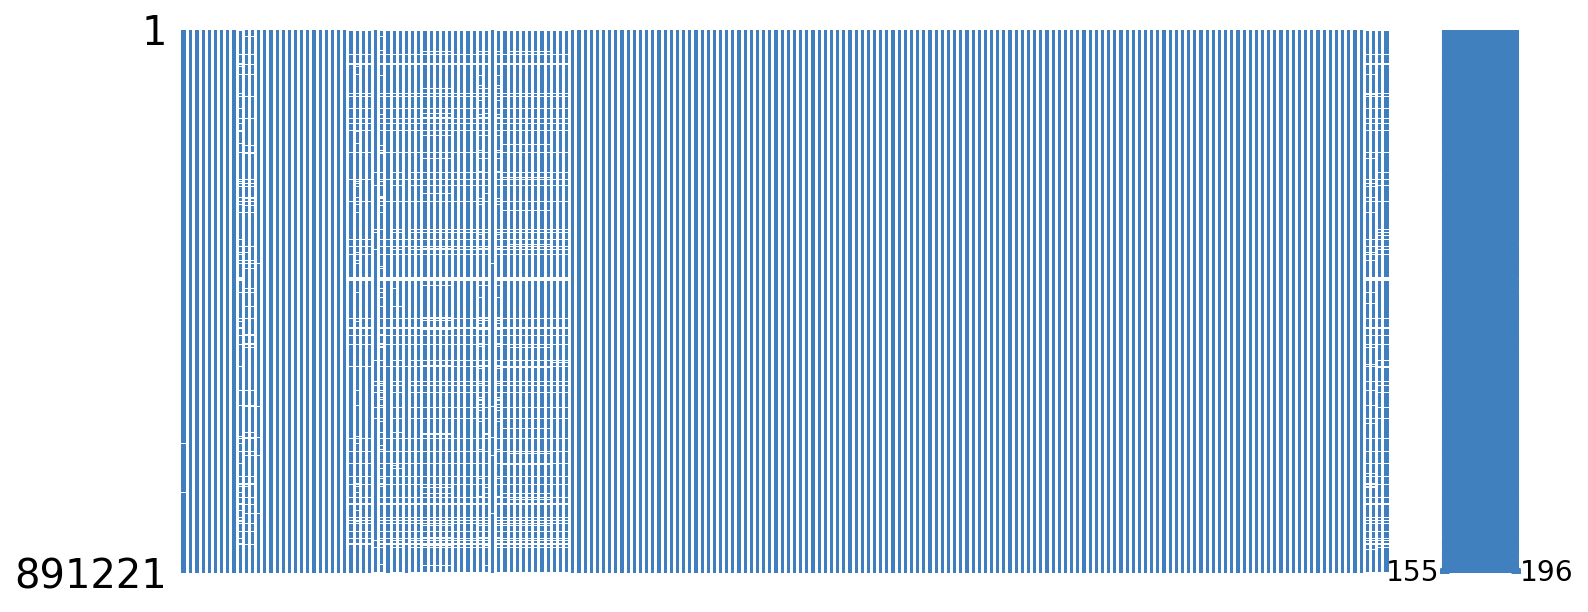

In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# check missing and duplicated data
df = azdias
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"=> Total records: {df.shape[0]}")
print(f"=> Null values: {df.isna().sum().sum()}")
print(f"=> Number of Duplicated values: {df.duplicated().sum()}")

In [49]:
# create a dataframe to gather information about each column
data_profiling_df = pd.DataFrame(columns = ["column_name",
                                            "column_type",
                                            "unique_values",
                                            "duplicate_values",
                                            "null_values",
                                            "non_null_values",
                                            "percent_null"])

# loop through each column to add rows to the data_profiling_df dataframe
for column in azdias.columns:
    
    info_dict = {}
    
    try:
        info_dict["column_name"] = column
        info_dict["column_type"] = azdias[column].dtypes
        info_dict["unique_values"] = len(azdias[column].unique())
        info_dict["duplicate_values"] = (azdias[column].shape[0] - azdias[column].isna().sum()) - len(azdias[column].unique())
        info_dict["null_values"] = azdias[column].isna().sum()
        info_dict["non_null_values"] = azdias[column].shape[0] - azdias[column].isna().sum()
        info_dict["percent_null"] = round((azdias[column].isna().sum()) / (azdias[column].shape[0]), 3)
        
    except:
        print(f"unable to read column: {column}")
    
    data_profiling_df = data_profiling_df.append(info_dict, ignore_index=True)
    
data_profiling_df.sort_values(by = ['unique_values', "non_null_values"],
                              ascending = [False, False],
                              inplace=True)

data_profiling_df.reset_index(drop = True, inplace = True)
data_profiling_df.head()

column_name column_type unique_values duplicate_values null_values  \
0     KBA13_ANZAHL_PKW     float64          1262           784159      105800   
1  ANZ_HAUSHALTE_AKTIV     float64           292           791318       99611   
2  LP_LEBENSPHASE_FEIN     float64            41           793548       97632   
3     MIN_GEBAEUDEJAHR     float64            33           798040       93148   
4         ANZ_PERSONEN     float64            31           817691       73499   

  non_null_values  percent_null  
0          785421         0.119  
1          791610         0.112  
2          793589         0.110  
3          798073         0.105  
4          817722         0.082

In [50]:
data_profiling_df.column_type.value_counts()

uint8      129
float64     45
int64       22
Name: column_type, dtype: int64

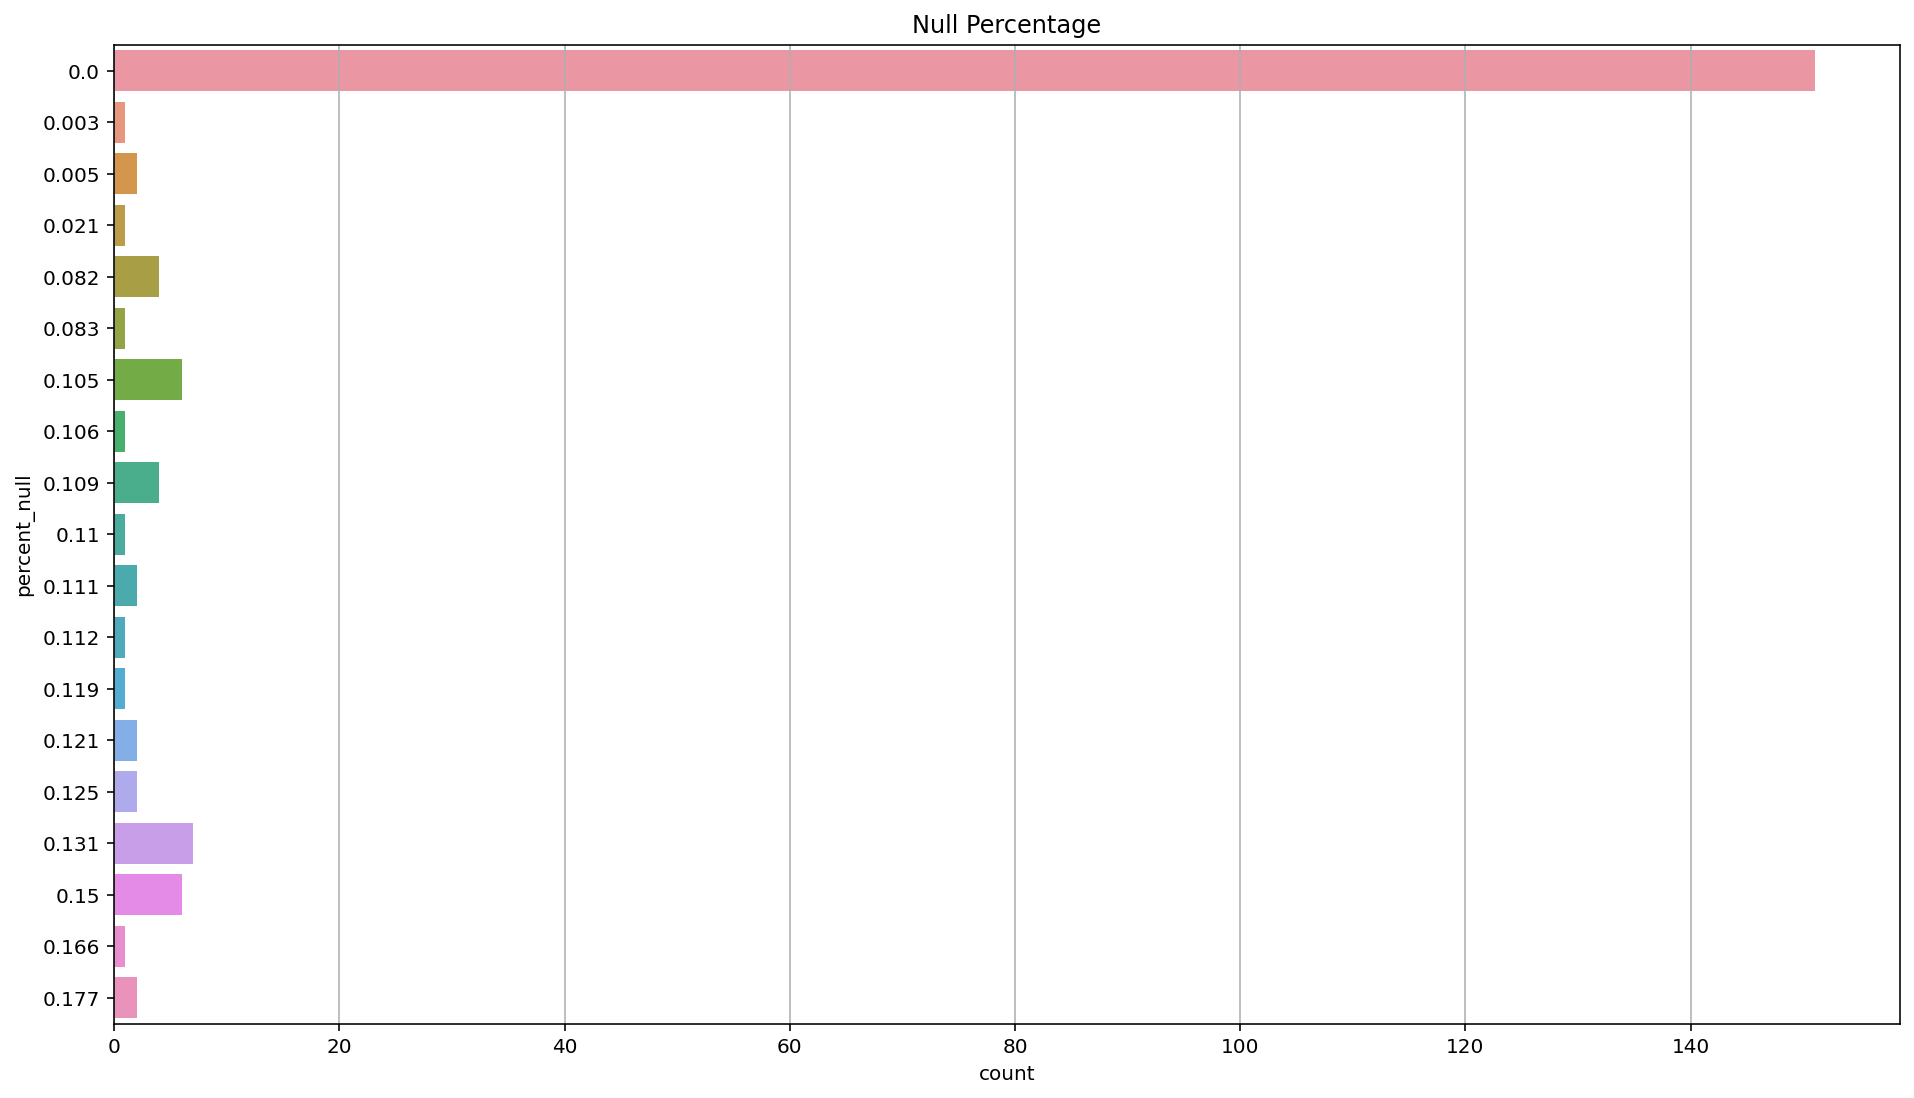

In [51]:
plt.figure(figsize = (16,9))
sb.countplot(data = data_profiling_df, y = 'percent_null')
plt.title('Null Percentage')
plt.grid(axis = 'x')
plt.show()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [52]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # convert missing value codes into NaNs, ...
    from tqdm.notebook import tqdm
    for column in df.columns:
        print(f'Converting column name: {column}')
        converted = []
        for i in tqdm(range(df[column].shape[0])):
            if df[column][i] in feat_info[feat_info['attribute'] == column].missing_or_unknown.tolist()[0]:
                converted.append(np.NaN)
            else:
                converted.append(df[column][i])            
        df[column] = converted
    # export data
    df.to_csv('customer_null_filled.csv', index = False)
    

    # select, re-encode, and engineer column values.

    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    category_columns = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()
    category_columns = [i for i in category_columns if i not in null_columns]

    # search columns which are binary
    binary_columns = []    
    for i in range(len(category_columns)):
        if df[category_columns[i]].value_counts().shape[0] == 2:
            binary_columns.append(category_columns[i])

    # search columns which are binary in non-numeric 
    binary_obj_columns = []
    for i in range(len(category_columns)):
        if df[category_columns[i]].value_counts().shape[0] == 2 and df[category_columns[i]].dtype == 'object':
            binary_obj_columns.append(category_columns[i])

    multi_lv_columns = [i for i in category_columns if i not in binary_columns]

    # Re-encode categorical variable(s) to be kept in the analysis.
    # encode(get dummies) for a column which is binary in object type
    for column in binary_obj_columns:
        df = df.join(pd.get_dummies(df[column], prefix = column))
        df.drop(columns = column, inplace = True)

    # encode(get dummies) for multi-level categoricals
    for column in multi_lv_columns:
        df = df.join(pd.get_dummies(df[column], prefix = column))
        df.drop(columns = column, inplace = True)

    # Engineer Mixed-Type Features
    mixed_columns = feat_info[feat_info['type'] == 'mixed'].attribute.tolist()
    mixed_columns = [i for i in mixed_columns if i not in null_columns]

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    def to_decade_dic(x):
        if x%1 != 0:
            return x
        else:
            decade_dic = {1: 40, 
                          2: 40, 
                          3: 50,
                          4: 50, 
                          5: 60, 
                          6: 60, 
                          7: 60, 
                          8: 70, 
                          9: 70, 
                         10: 80, 
                         11: 80, 
                         12: 80, 
                         13: 80, 
                         14: 90, 
                         15: 90}
            return decade_dic[x]

    def to_movement_dic(x):
        if x%1 != 0:
            return x
        else:
            movement_dic = {1: 1, 
                            2: 0, 
                            3: 1,
                            4: 0, 
                            5: 1, 
                            6: 0, 
                            7: 0, 
                            8: 1, 
                            9: 0, 
                           10: 1, 
                           11: 0, 
                           12: 1, 
                           13: 0, 
                           14: 1, 
                           15: 0}
            return movement_dic[x]

    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(to_decade_dic)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(to_movement_dic)
    df.drop(columns = 'PRAEGENDE_JUGENDJAHRE', inplace = True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def to_wealth(x):
        if type(x) == str:
            return int(str(int(x))[:1])    
        elif math.isnan(x):
            return x

    def to_life(x):
        if type(x) == str:
            return int(str(int(x))[1:])
        elif math.isnan(x):
            return x

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(to_wealth)
    df['CAMEO_INTL_2015_LIFE'] = df['CAMEO_INTL_2015'].apply(to_life)
    df.drop(columns = 'CAMEO_INTL_2015', inplace = True)    

    # create a dataframe to gather information about each column
    data_profiling_df = pd.DataFrame(columns = ["column_name",
                                                "column_type",
                                                "unique_values",
                                                "duplicate_values",
                                                "null_values",
                                                "non_null_values",
                                                "percent_null"])

    # loop through each column to add rows to the data_profiling_df dataframe
    for column in df.columns:

        info_dict = {}

        try:
            info_dict["column_name"] = column
            info_dict["column_type"] = df[column].dtypes
            info_dict["unique_values"] = len(df[column].unique())
            info_dict["duplicate_values"] = (df[column].shape[0] - df[column].isna().sum()) - len(df[column].unique())
            info_dict["null_values"] = df[column].isna().sum()
            info_dict["non_null_values"] = df[column].shape[0] - df[column].isna().sum()
            info_dict["percent_null"] = round((df[column].isna().sum()) / (df[column].shape[0]), 3)

        except:
            print(f"unable to read column: {column}")

        data_profiling_df = data_profiling_df.append(info_dict, ignore_index=True)

    data_profiling_df.sort_values(by = ['unique_values', "non_null_values"],
                                  ascending = [False, False],
                                  inplace=True)

    data_profiling_df.reset_index(drop = True, inplace = True)

    # count plot for null percentage
    plt.figure(figsize = (16,9))
    sb.countplot(data = data_profiling_df, y = 'percent_null')
    plt.title('Null Percentage')
    plt.grid(axis = 'x')
    plt.show()
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [53]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_encode = azdias.copy()

# get values w/o null to get the scaling parameter
azdias_encode_param_test = azdias_encode.dropna()

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# transform the dataset by filling NaN values
# filling NaN with mean
imputer_mean = SimpleImputer(missing_values=np.NaN, strategy='mean')
azdias_encode_imputed_mean = imputer_mean.fit_transform(azdias_encode_param_test)
azdias_encode_imputed_mean = pd.DataFrame(data = azdias_encode_imputed_mean, 
                                          columns = azdias_encode.columns)

# filling NaN with median
imputer_median = SimpleImputer(missing_values=np.NaN, strategy='median')
azdias_encode_imputed_median = imputer_median.fit_transform(azdias_encode_param_test)
azdias_encode_imputed_median = pd.DataFrame(data = azdias_encode_imputed_median, 
                                            columns = azdias_encode.columns)

# filling NaN with freq
imputer_freq = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
azdias_encode_imputed_freq = imputer_freq.fit_transform(azdias_encode_param_test)
azdias_encode_imputed_freq = pd.DataFrame(data = azdias_encode_imputed_freq, 
                                          columns = azdias_encode.columns)

# get each std. average to compare 
std_original = azdias_encode.describe().T['std'].mean()
std_by_mean = azdias_encode_imputed_mean.describe().T['std'].mean()
std_by_median = azdias_encode_imputed_median.describe().T['std'].mean()
std_by_freq = azdias_encode_imputed_freq.describe().T['std'].mean()

print(f'Original data - Standard deviation:             {std_original}')
print(f'Filling NaN by Average - Standard deviation:    {std_by_mean}')
print(f'Filling NaN by Median - Standard deviation:     {std_by_median}')
print(f'Filling NaN by Most Freq. - Standard deviation: {std_by_freq}')  

Original data - Standard deviation:             2.570833417693983
Filling NaN by Average - Standard deviation:    2.5237260112641007
Filling NaN by Median - Standard deviation:     2.5237260112641007
Filling NaN by Most Freq. - Standard deviation: 2.5237260112641007


- We will apply 'most-frequent' as a strategy of the scaling parameter

In [55]:
# filling NaN with most-frequent value

imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent', add_indicator=True)

azdias_encode_imputed = imputer.fit_transform(azdias_encode)
azdias_encode_imputed = azdias_encode_imputed[:, 0:196] # exclude indicator columns
azdias_encode_imputed = pd.DataFrame(data = azdias_encode_imputed, 
                                     index = azdias_encode.index, 
                                     columns = azdias_encode.columns)
azdias_encode_imputed.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0        1.0                3.0            4.0   
1                   1.0        2.0                1.0            5.0   
2                   3.0        2.0                1.0            4.0   
3                   4.0        2.0                4.0            2.0   
4                   3.0        1.0                4.0            3.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               3.0             5.0                    5.0               3.0   
1               2.0             5.0                    4.0               5.0   
2               1.0             2.0                    3.0               5.0   
3               5.0             2.0                    1.0               2.0   
4               4.0             1.0                    3.0               2.0   

   GREEN_AVANTGARDE  HEALTH_TYP  ...  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
0               0.0         3.0  ...                0.0                0.0   
1               0.0         3.0  ...                0.0                0.0   
2               1.0         3.0  ...                0.0                0.0   
3               0.0         2.0  ...                0.0                0.0   
4               0.0         3.0  ...                0.0                0.0   

   CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MOVEMENT  \
0                          90.0                             1.0   
1                          90.0                             1.0   
2                          90.0                             0.0   
3                          70.0                             1.0   
4                          70.0                             1.0   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFE  
0                     5.0                   1.0  
1                     5.0                   1.0  
2                     2.0                   4.0  
3                     1.0                   2.0  
4                     4.0                   3.0  

[5 rows x 196 columns]

=> Total records: 891221
=> Null values: 0
=> Number of Duplicated values: 52553


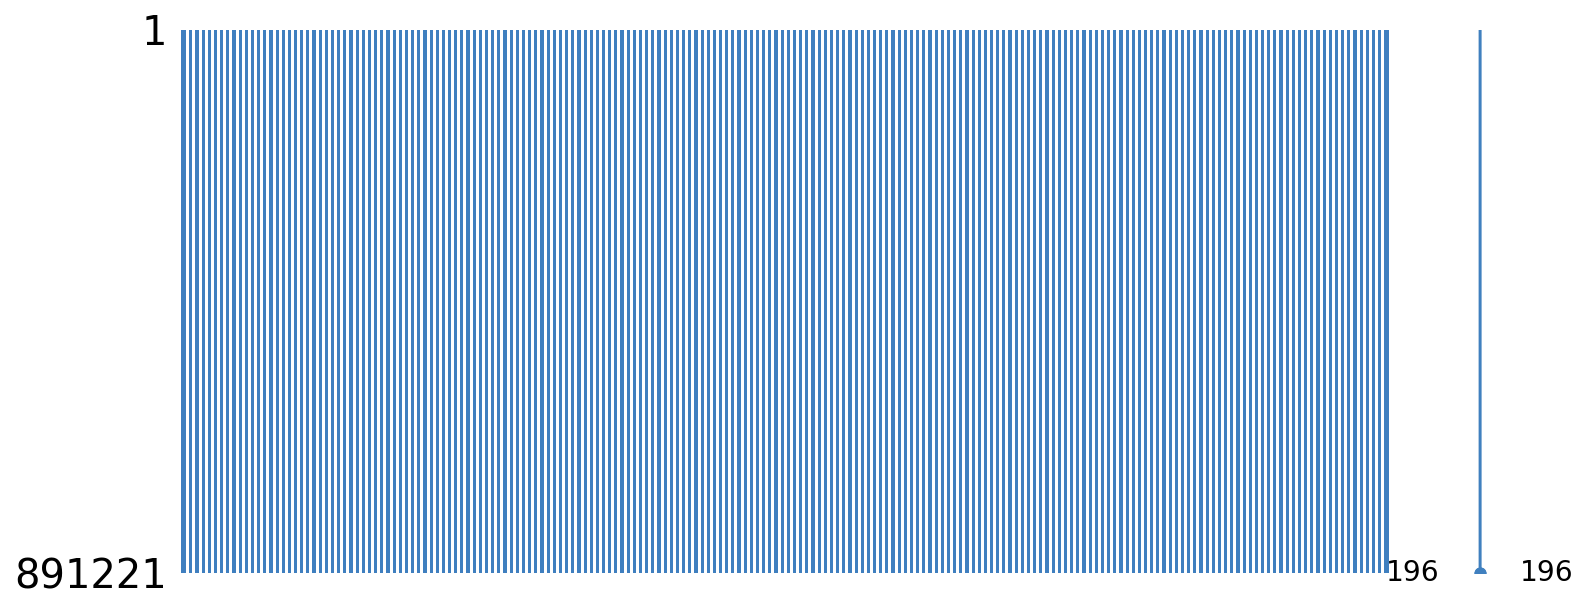

In [56]:
# check missing and duplicated data

df = azdias_encode_imputed.copy()
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"=> Total records: {df.shape[0]}")
print(f"=> Null values: {df.isna().sum().sum()}")
print(f"=> Number of Duplicated values: {df.duplicated().sum()}")

In [57]:
# Apply feature scaling to the general population demographics data.

sc = StandardScaler()
azdias_encode_imputed_scaling = sc.fit_transform(azdias_encode_imputed)
azdias_encode_imputed_scaling = pd.DataFrame(data = azdias_encode_imputed_scaling, 
                                             index = azdias_encode.index, 
                                             columns = azdias_encode.columns)
azdias_encode_imputed_scaling.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -0.751680  -1.045218          -0.056416       0.804890   
1             -1.743339   0.956738          -1.570358       1.487601   
2              0.239980   0.956738          -1.570358       0.804890   
3              1.231640   0.956738           0.700556      -0.560532   
4              0.239980  -1.045218           0.700556       0.122179   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -0.303378        1.285741               1.429871         -0.055511   
1         -1.059731        1.285741               0.757254          1.422415   
2         -1.816084       -0.675554               0.084637          1.422415   
3          1.209329       -0.675554              -1.260597         -0.794475   
4          0.452976       -1.329319               0.084637         -0.794475   

   GREEN_AVANTGARDE  HEALTH_TYP  ...  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
0         -0.494701    0.938197  ...          -0.141838            -0.1536   
1         -0.494701    0.938197  ...          -0.141838            -0.1536   
2          2.021423    0.938197  ...          -0.141838            -0.1536   
3         -0.494701   -0.385397  ...          -0.141838            -0.1536   
4         -0.494701    0.938197  ...          -0.141838            -0.1536   

   CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0          -0.179023           -0.16984          -0.182061          -0.084907   
1          -0.179023           -0.16984          -0.182061          -0.084907   
2          -0.179023           -0.16984          -0.182061          -0.084907   
3          -0.179023           -0.16984          -0.182061          -0.084907   
4          -0.179023           -0.16984          -0.182061          -0.084907   

   PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MOVEMENT  \
0                      0.994991                        0.494701   
1                      0.994991                        0.494701   
2                      0.994991                       -2.021423   
3                     -0.363493                        0.494701   
4                     -0.363493                        0.494701   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFE  
0                1.039938             -1.095866  
1                1.039938             -1.095866  
2               -0.980453              0.879581  
3               -1.653917             -0.437384  
4                0.366474              0.221098  

[5 rows x 196 columns]

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

> Before applying dimensionality reduction techniques, we performed feature scaling. To fill missing values with an appropriate measure, we checked differences in the average of standard deviation when we filled the missing values with average, median, or most-frequent values in the same column with data containing no missing values, and then decided the 'most-frequent' as the imputing parameter. Finally, we used 'StandardScaler' to do feature scaling and transformed the original data.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [59]:
azdias_encode_imputed_scaling.shape

(891221, 196)

In [60]:
pca, azdias_pca = do_pca(15, azdias_encode_imputed_scaling)

In [61]:
azdias_pca.shape

(891221, 15)

Total Variance Explained with the components: 0.36549057657024325


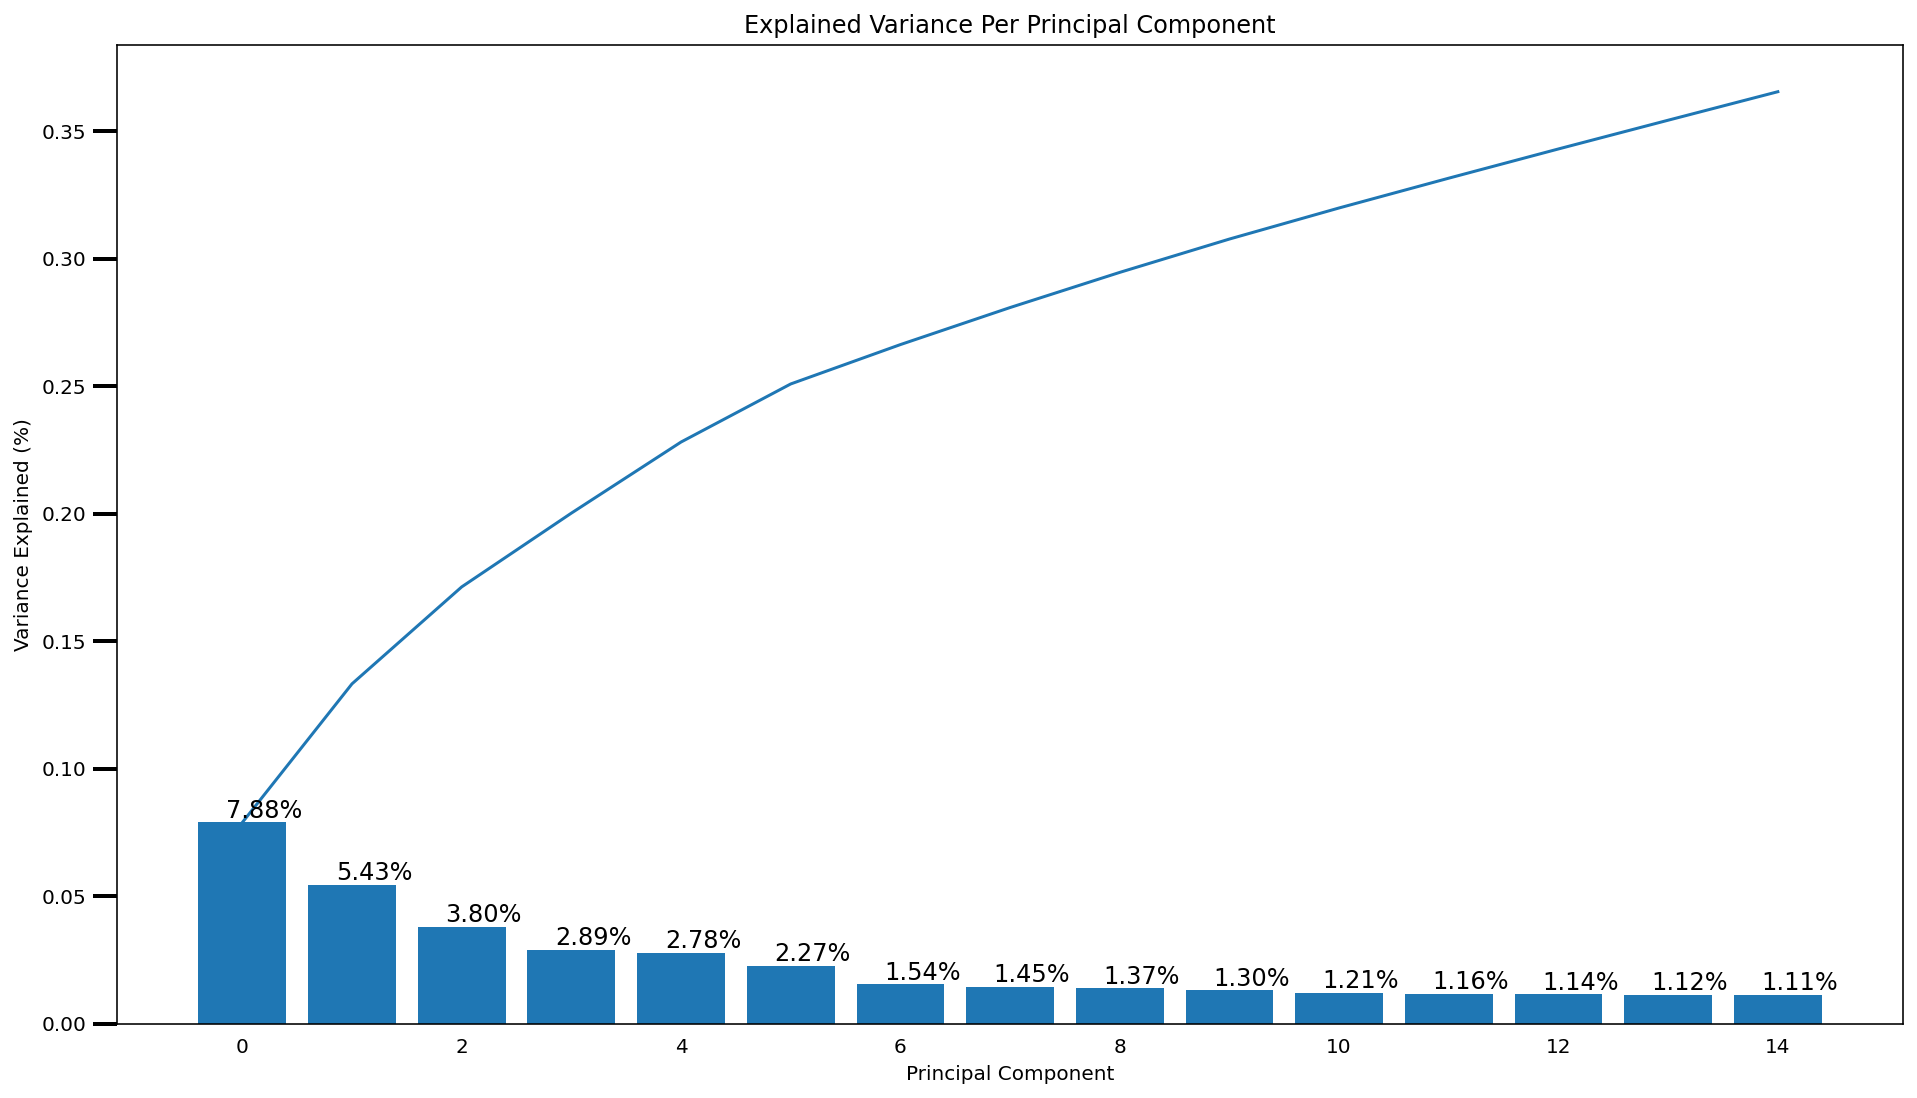

In [62]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    print(f'Total Variance Explained with the components: {vals.sum()}')
    

scree_plot(pca)

Each of the bars represents the amount of variability explained by each component. So you can see the first component explains 6.13% of the variability in the image data. The second explains 4.29% of the variability and so on. Often the number of components is chosen based on the total amount of variability explained by the components. You can see that by using 15 components, we capture almost 35% of the total variability in the images.

Let's see if we can get a better idea of what aspects of the image the components might be picking up on. To do this we will work with the components_ attribute of the pca object. Looking at the shape of components shows us that each component gives the weights for each pixel.

In [63]:
def variance_explained(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    print(f'Total Variance Explained with the components: {vals.sum()}\n')
    
    return vals.sum()

In [64]:
# get the number of components explaining more than 80%
for i in range(1, 100):
    pca, azdias_pca = do_pca(i, azdias_encode_imputed_scaling)
    print(f'Number of components: {i}')
    if variance_explained(pca) > 0.8:
        break

Number of components: 1
Total Variance Explained with the components: 0.07887430671657329

Number of components: 2
Total Variance Explained with the components: 0.1332524801748818

Number of components: 3
Total Variance Explained with the components: 0.17126768521199026

Number of components: 4
Total Variance Explained with the components: 0.20020743275340222

Number of components: 5
Total Variance Explained with the components: 0.2280922357922387

Number of components: 6
Total Variance Explained with the components: 0.2508695010329623

Number of components: 7
Total Variance Explained with the components: 0.2663041006765762

Number of components: 8
Total Variance Explained with the components: 0.28079860907529025

Number of components: 9
Total Variance Explained with the components: 0.2945534489197701

Number of components: 10
Total Variance Explained with the components: 0.30763248076142785

Number of components: 11
Total Variance Explained with the components: 0.3197062834440416

Num

Total Variance Explained with the components: 0.8028122303689114


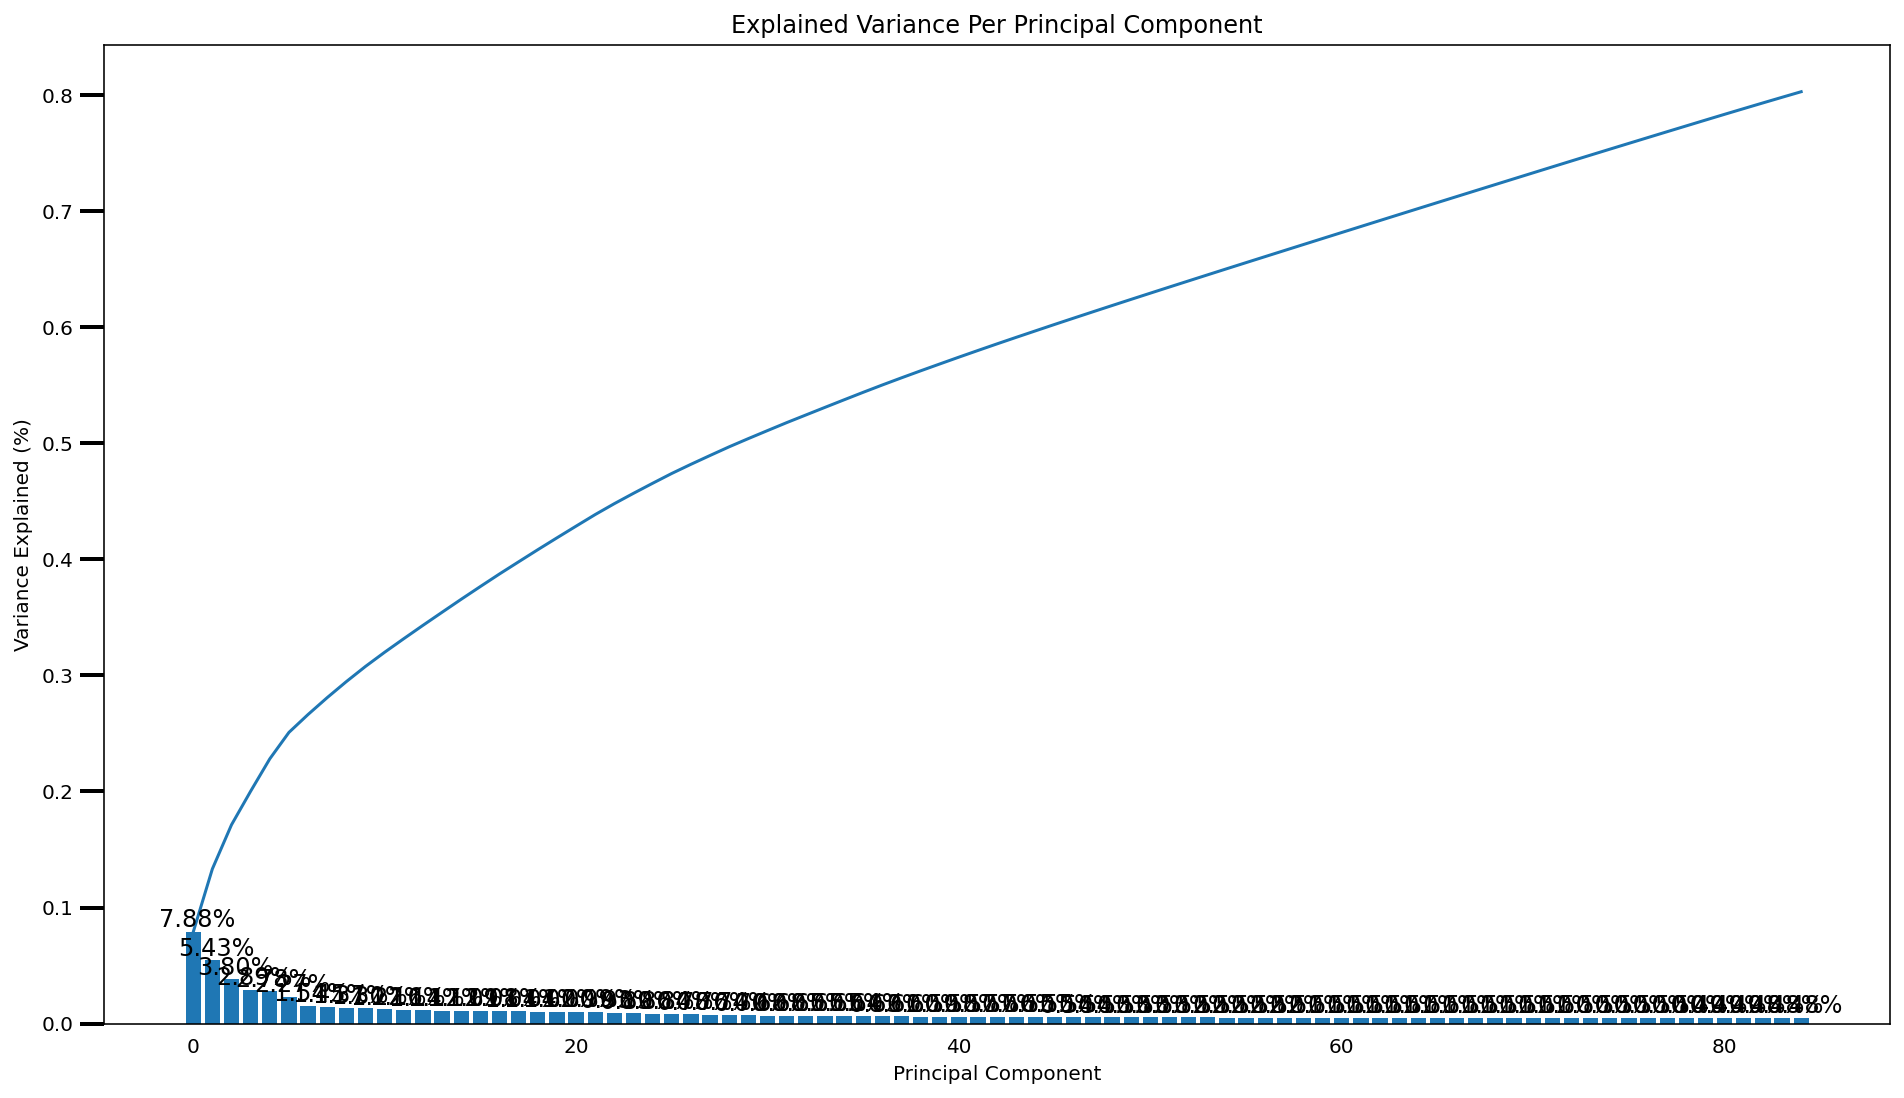

In [65]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(85)
azdias_pca = pca.fit_transform(azdias_encode_imputed_scaling)
scree_plot(pca)

In [66]:
column_name = [f'comp_{str(i)}' for i in np.arange(0, azdias_pca.shape[1]).tolist()]
azdias_pca_df = pd.DataFrame(data = azdias_pca, columns = column_name)
azdias_pca_df

comp_0    comp_1    comp_2    comp_3    comp_4    comp_5    comp_6  \
0       2.545342 -1.334207 -4.215810 -0.867453  3.373793  1.763824  0.741295   
1       4.370439 -3.744325  0.214005  3.072332 -2.837856 -0.313545 -1.891935   
2      -0.422185 -0.329310 -1.234521  1.223799 -2.228379 -5.294743 -1.907636   
3      -4.760554  1.675373 -1.511381 -2.155439 -2.200227  0.029099  2.269547   
4      -0.982069  0.826661  3.135181  1.715742  2.202693  2.818912 -2.649424   
...          ...       ...       ...       ...       ...       ...       ...   
891216  1.191113 -1.891335 -1.559069  0.267422 -4.506580 -2.011565 -0.223066   
891217  5.524611  2.154219  1.151579 -1.183295  0.664373  0.722944  1.676160   
891218 -0.947484 -3.690909 -0.841811 -1.516349 -4.712578 -2.062892 -2.970024   
891219  5.631714 -3.501492  5.206778  1.666965  0.064278  3.196710 -0.847083   
891220  0.295244  3.192122  1.608478 -4.128314 -1.586150  0.446819 -1.232090   

          comp_7    comp_8    comp_9  ...   comp_75   comp_76   comp_77  \
0      -0.705119 -0.457639  0.319386  ...  0.265574 -0.889398  0.201032   
1      -0.612992 -0.582361  1.097468  ...  0.940891  0.627078 -0.253666   
2      -0.973950 -0.740988  0.342940  ...  0.135618 -0.016131 -0.639123   
3       0.641962 -0.384390 -1.487994  ... -0.183406  0.524881  1.410138   
4      -3.388884 -1.086224  2.387372  ... -0.068545  0.204219 -0.243618   
...          ...       ...       ...  ...       ...       ...       ...   
891216 -0.124949 -0.280197 -0.697535  ...  0.856819 -0.481546  0.132136   
891217  0.572514 -1.827764 -2.114214  ... -0.164083  1.618387  0.532717   
891218 -0.600420 -0.551304  0.514413  ... -0.297065  0.556089  0.115422   
891219 -2.286197 -0.281238 -2.252222  ...  0.521416  0.616858  2.688909   
891220 -1.879672 -0.627257  0.239151  ... -0.378328 -0.487109 -0.588317   

         comp_78   comp_79   comp_80   comp_81   comp_82   comp_83   comp_84  
0      -0.320195 -0.148004  0.018112  0.532709 -1.015977 -0.049460 -0.515940  
1       1.981734 -0.244768 -1.500804 -0.614365  0.224721  0.773396 -0.601334  
2      -0.157999  0.000513 -0.653250 -0.724514 -0.241020 -0.627542 -0.035947  
3      -1.333129 -0.207685 -0.009318 -0.312727 -1.793090 -1.406840 -0.027181  
4      -0.263286 -0.660371 -0.588677 -0.414559  0.319484  0.904418  0.329119  
...          ...       ...       ...       ...       ...       ...       ...  
891216 -0.417011 -0.008767  0.535874  0.208356 -0.054838  0.031291  0.417812  
891217  1.043541  0.239990 -0.541605  0.050073 -0.535438 -0.407105 -1.038417  
891218  0.083572  0.588732  0.330278  0.832237 -0.393568  0.096874 -0.664134  
891219  0.055697  2.505595  1.243135 -0.086377  1.045066  0.837403 -0.891793  
891220  0.286141  0.068370 -0.117046 -0.177272  0.126595 -0.547072 -1.085323  

[891221 rows x 85 columns]

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

> We wanted to retain the number of components having an explained variance of more than 80%. After we iterated the number of components we decided to have 85 components with about 80% explained variance. The first two components have about 13% explained variance. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). **The further a weight is from zero, the more the principal component is in the direction of the corresponding feature.** If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

azdias_pca_df

comp_0    comp_1    comp_2    comp_3    comp_4    comp_5    comp_6  \
0       2.545342 -1.334207 -4.215810 -0.867453  3.373793  1.763824  0.741295   
1       4.370439 -3.744325  0.214005  3.072332 -2.837856 -0.313545 -1.891935   
2      -0.422185 -0.329310 -1.234521  1.223799 -2.228379 -5.294743 -1.907636   
3      -4.760554  1.675373 -1.511381 -2.155439 -2.200227  0.029099  2.269547   
4      -0.982069  0.826661  3.135181  1.715742  2.202693  2.818912 -2.649424   
...          ...       ...       ...       ...       ...       ...       ...   
891216  1.191113 -1.891335 -1.559069  0.267422 -4.506580 -2.011565 -0.223066   
891217  5.524611  2.154219  1.151579 -1.183295  0.664373  0.722944  1.676160   
891218 -0.947484 -3.690909 -0.841811 -1.516349 -4.712578 -2.062892 -2.970024   
891219  5.631714 -3.501492  5.206778  1.666965  0.064278  3.196710 -0.847083   
891220  0.295244  3.192122  1.608478 -4.128314 -1.586150  0.446819 -1.232090   

          comp_7    comp_8    comp_9  ...   comp_75   comp_76   comp_77  \
0      -0.705119 -0.457639  0.319386  ...  0.265574 -0.889398  0.201032   
1      -0.612992 -0.582361  1.097468  ...  0.940891  0.627078 -0.253666   
2      -0.973950 -0.740988  0.342940  ...  0.135618 -0.016131 -0.639123   
3       0.641962 -0.384390 -1.487994  ... -0.183406  0.524881  1.410138   
4      -3.388884 -1.086224  2.387372  ... -0.068545  0.204219 -0.243618   
...          ...       ...       ...  ...       ...       ...       ...   
891216 -0.124949 -0.280197 -0.697535  ...  0.856819 -0.481546  0.132136   
891217  0.572514 -1.827764 -2.114214  ... -0.164083  1.618387  0.532717   
891218 -0.600420 -0.551304  0.514413  ... -0.297065  0.556089  0.115422   
891219 -2.286197 -0.281238 -2.252222  ...  0.521416  0.616858  2.688909   
891220 -1.879672 -0.627257  0.239151  ... -0.378328 -0.487109 -0.588317   

         comp_78   comp_79   comp_80   comp_81   comp_82   comp_83   comp_84  
0      -0.320195 -0.148004  0.018112  0.532709 -1.015977 -0.049460 -0.515940  
1       1.981734 -0.244768 -1.500804 -0.614365  0.224721  0.773396 -0.601334  
2      -0.157999  0.000513 -0.653250 -0.724514 -0.241020 -0.627542 -0.035947  
3      -1.333129 -0.207685 -0.009318 -0.312727 -1.793090 -1.406840 -0.027181  
4      -0.263286 -0.660371 -0.588677 -0.414559  0.319484  0.904418  0.329119  
...          ...       ...       ...       ...       ...       ...       ...  
891216 -0.417011 -0.008767  0.535874  0.208356 -0.054838  0.031291  0.417812  
891217  1.043541  0.239990 -0.541605  0.050073 -0.535438 -0.407105 -1.038417  
891218  0.083572  0.588732  0.330278  0.832237 -0.393568  0.096874 -0.664134  
891219  0.055697  2.505595  1.243135 -0.086377  1.045066  0.837403 -0.891793  
891220  0.286141  0.068370 -0.117046 -0.177272  0.126595 -0.547072 -1.085323  

[891221 rows x 85 columns]

In [68]:
column_weight = [f'comp_{str(i)}' for i in np.arange(0, azdias_pca.shape[1]).tolist()]
df_weight = pd.DataFrame(data = pca.components_.T, index = pca.feature_names_in_, columns = column_weight)
df_weight

comp_0    comp_1    comp_2    comp_3  \
ALTERSKATEGORIE_GROB           -0.084370  0.226237 -0.048518 -0.017437   
ANREDE_KZ                       0.018087  0.015612 -0.217144  0.196811   
FINANZ_MINIMALIST              -0.184709  0.082749  0.013046 -0.072953   
FINANZ_SPARER                   0.120510 -0.231848 -0.001596  0.020606   
FINANZ_VORSORGER               -0.087302  0.217832 -0.029599 -0.023792   
...                                  ...       ...       ...       ...   
CAMEO_DEU_2015_9E               0.015106  0.040726 -0.002738  0.004220   
PRAEGENDE_JUGENDJAHRE_DECADE    0.087542 -0.237361 -0.023626  0.023207   
PRAEGENDE_JUGENDJAHRE_MOVEMENT  0.107749 -0.006784 -0.073487 -0.145614   
CAMEO_INTL_2015_WEALTH          0.181268  0.034819 -0.047235 -0.025803   
CAMEO_INTL_2015_LIFE           -0.115218  0.034211  0.053425  0.027645   

                                  comp_4    comp_5    comp_6    comp_7  \
ALTERSKATEGORIE_GROB            0.016339  0.057070  0.011192  0.016467   
ANREDE_KZ                      -0.189380 -0.096041 -0.002314  0.015451   
FINANZ_MINIMALIST               0.136183  0.062052  0.149256  0.052579   
FINANZ_SPARER                  -0.026828 -0.034167 -0.018624 -0.014408   
FINANZ_VORSORGER                0.047518  0.043963 -0.039172 -0.047581   
...                                  ...       ...       ...       ...   
CAMEO_DEU_2015_9E              -0.004654 -0.001168 -0.011895  0.071755   
PRAEGENDE_JUGENDJAHRE_DECADE    0.003493 -0.026227  0.027066  0.029735   
PRAEGENDE_JUGENDJAHRE_MOVEMENT -0.166364  0.222905 -0.014103  0.029468   
CAMEO_INTL_2015_WEALTH          0.046770  0.158877 -0.005872 -0.061655   
CAMEO_INTL_2015_LIFE           -0.069957 -0.101920 -0.067625 -0.045600   

                                  comp_8    comp_9  ...   comp_75   comp_76  \
ALTERSKATEGORIE_GROB           -0.029646  0.025228  ... -0.015733  0.018932   
ANREDE_KZ                       0.019380 -0.014098  ... -0.009989 -0.008825   
FINANZ_MINIMALIST              -0.009791  0.006649  ... -0.002796  0.015247   
FINANZ_SPARER                   0.009213 -0.035539  ... -0.007571 -0.005654   
FINANZ_VORSORGER               -0.109443  0.019866  ...  0.013691  0.003403   
...                                  ...       ...  ...       ...       ...   
CAMEO_DEU_2015_9E              -0.008934 -0.043101  ...  0.016178  0.066515   
PRAEGENDE_JUGENDJAHRE_DECADE    0.001576 -0.007897  ... -0.001992  0.006442   
PRAEGENDE_JUGENDJAHRE_MOVEMENT -0.069141  0.026337  ... -0.003203  0.016556   
CAMEO_INTL_2015_WEALTH         -0.042590  0.033175  ...  0.026245  0.009868   
CAMEO_INTL_2015_LIFE            0.186224  0.081193  ...  0.007158  0.023218   

                                 comp_77   comp_78   comp_79   comp_80  \
ALTERSKATEGORIE_GROB           -0.033567 -0.032511  0.037490 -0.011373   
ANREDE_KZ                       0.016843  0.023910  0.002997  0.019112   
FINANZ_MINIMALIST               0.005278 -0.008610 -0.012070  0.008207   
FINANZ_SPARER                   0.010763 -0.019143  0.035498 -0.011792   
FINANZ_VORSORGER               -0.032090  0.036992 -0.006985 -0.017892   
...                                  ...       ...       ...       ...   
CAMEO_DEU_2015_9E               0.053430 -0.040923 -0.154546 -0.003708   
PRAEGENDE_JUGENDJAHRE_DECADE    0.000162 -0.024342  0.010632 -0.003071   
PRAEGENDE_JUGENDJAHRE_MOVEMENT  0.005655 -0.005763 -0.021718  0.052767   
CAMEO_INTL_2015_WEALTH         -0.002949 -0.014774  0.025683 -0.008270   
CAMEO_INTL_2015_LIFE            0.016579 -0.019749 -0.014012  0.001882   

                                 comp_81   comp_82   comp_83   comp_84  
ALTERSKATEGORIE_GROB           -0.007117 -0.032410 -0.000507  0.001864  
ANREDE_KZ                       0.017255 -0.002998 -0.011273  0.066726  
FINANZ_MINIMALIST              -0.035016  0.030772 -0.011167  0.030152  
FINANZ_SPARER                   0.006950 -0.042635  0.006228 -0.017048  
FINANZ_VORSORGER                0.030872  0.035736 -0

In [69]:
def map_weights(column_name):
    print('start:')
    print(df_weight.sort_values(column_name, ascending = False).head(15)[column_name])
    print('\n\nend:')
    print(df_weight.sort_values(column_name, ascending = False).tail(15)[column_name])

In [70]:
map_weights('comp_0')

start:
CAMEO_INTL_2015_WEALTH            0.181268
PLZ8_ANTG3                        0.180450
LP_STATUS_GROB_1.0                0.174513
EWDICHTE                          0.154818
PLZ8_BAUMAX                       0.153561
PLZ8_ANTG4                        0.148428
ORTSGR_KLS9                       0.147753
HH_EINKOMMEN_SCORE                0.140796
FINANZ_HAUSBAUER                  0.140126
PLZ8_ANTG2                        0.123585
FINANZ_SPARER                     0.120510
ARBEIT                            0.118719
KBA05_ANTG4                       0.115579
LP_STATUS_FEIN_1.0                0.112081
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.107749
Name: comp_0, dtype: float64


end:
LP_STATUS_FEIN_9.0     -0.109403
LP_STATUS_GROB_4.0     -0.110759
LP_STATUS_GROB_5.0     -0.113696
LP_STATUS_FEIN_10.0    -0.113696
CAMEO_INTL_2015_LIFE   -0.115218
INNENSTADT             -0.119313
PLZ8_GBZ               -0.132362
LP_LEBENSPHASE_GROB    -0.133054
KONSUMNAEHE            -0.139955
LP_LEBENSPHASE_

In [71]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights('comp_1')

start:
ALTERSKATEGORIE_GROB    0.226237
FINANZ_VORSORGER        0.217832
SEMIO_ERL               0.174251
RETOURTYP_BK_S          0.156398
SEMIO_LUST              0.148461
ZABEOTYP_3              0.145880
FINANZTYP_5             0.113128
LP_STATUS_FEIN_1.0      0.112533
CJT_GESAMTTYP_2.0       0.107145
NATIONALITAET_KZ_1.0    0.099894
W_KEIT_KIND_HH          0.098476
PLZ8_ANTG4              0.096757
FINANZTYP_2             0.093806
FINANZ_HAUSBAUER        0.092281
PLZ8_BAUMAX             0.088066
Name: comp_1, dtype: float64


end:
LP_STATUS_FEIN_5.0             -0.104876
FINANZTYP_1                    -0.112089
FINANZTYP_4                    -0.117683
SEMIO_KULT                     -0.125947
SEMIO_FAM                      -0.130131
SEMIO_MAT                      -0.130781
ONLINE_AFFINITAET              -0.151802
SEMIO_RAT                      -0.172229
SEMIO_TRADV                    -0.188445
SEMIO_PFLICHT                  -0.206815
SEMIO_REL                      -0.214095
FINANZ_ANLE

In [72]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights('comp_2')

start:
SEMIO_VERT              0.278119
SEMIO_KULT              0.253264
SEMIO_SOZ               0.252243
SEMIO_FAM               0.137995
PLZ8_ANTG4              0.128195
SHOPPER_TYP_0.0         0.119719
NATIONALITAET_KZ_1.0    0.117148
OST_WEST_KZ_W           0.111934
PLZ8_BAUMAX             0.111762
ZABEOTYP_1              0.104381
SEMIO_TRADV             0.099571
HH_EINKOMMEN_SCORE      0.096832
FINANZTYP_5             0.083757
ANZ_PERSONEN            0.082817
SHOPPER_TYP_1.0         0.081016
Name: comp_2, dtype: float64


end:
W_KEIT_KIND_HH        -0.089807
BALLRAUM              -0.109395
CJT_GESAMTTYP_6.0     -0.114166
FINANZ_ANLEGER        -0.118103
LP_STATUS_GROB_2.0    -0.126988
SEMIO_ERL             -0.130103
GFK_URLAUBERTYP_5.0   -0.139064
KBA13_ANZAHL_PKW      -0.153172
FINANZTYP_4           -0.160137
LP_STATUS_FEIN_5.0    -0.167968
ZABEOTYP_3            -0.182669
ANREDE_KZ             -0.217144
SEMIO_DOM             -0.224229
SEMIO_KAEM            -0.254130
SEMIO_KRIT    

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

> Referring to the data dictionary associated with the first few principal components listed in 'Start' and 'End' above, we've found the distinctive difference between those two lists; positive values of the components are closed related in that those are an open-minded, young, major consumer, and high income whereas negative values of the components are conservative, old, frugal, low income by and large.        

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans

In [73]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans

def k_means_clusters_score(df, number_of_cluster):
    kmeans = KMeans(n_clusters = number_of_cluster)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    return score

scores = []
kvalues = list(range(1,20)) 
for k in kvalues: 
    print(f'Cluster Number: {k}', end = '       \r')
    scores.append(k_means_clusters_score(azdias_pca_df, k))

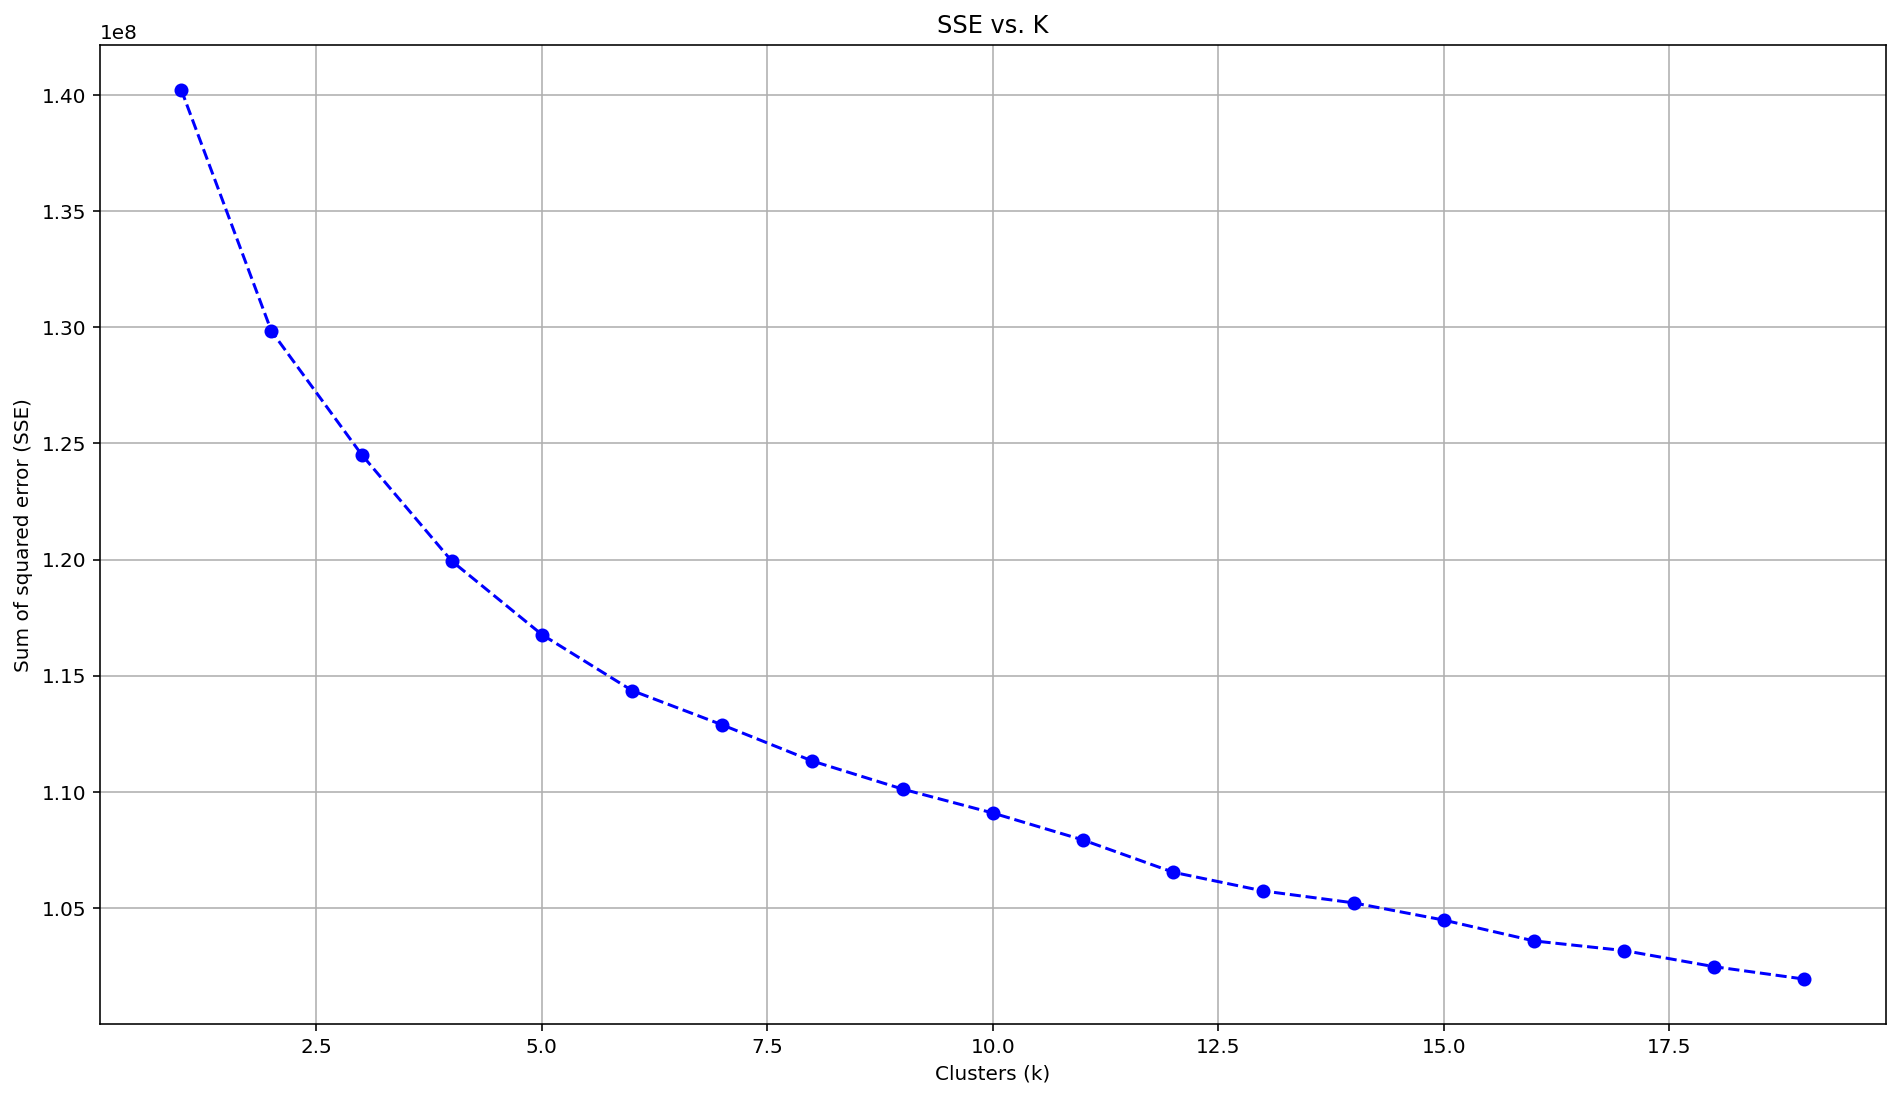

In [74]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize = (16, 9))
plt.plot(kvalues, scores, linestyle='--', marker='o', color='b');
plt.grid(axis = 'x')
plt.grid(axis = 'y')
plt.xlabel('Clusters (k)');
plt.ylabel('Sum of squared error (SSE)');
plt.title('SSE vs. K');

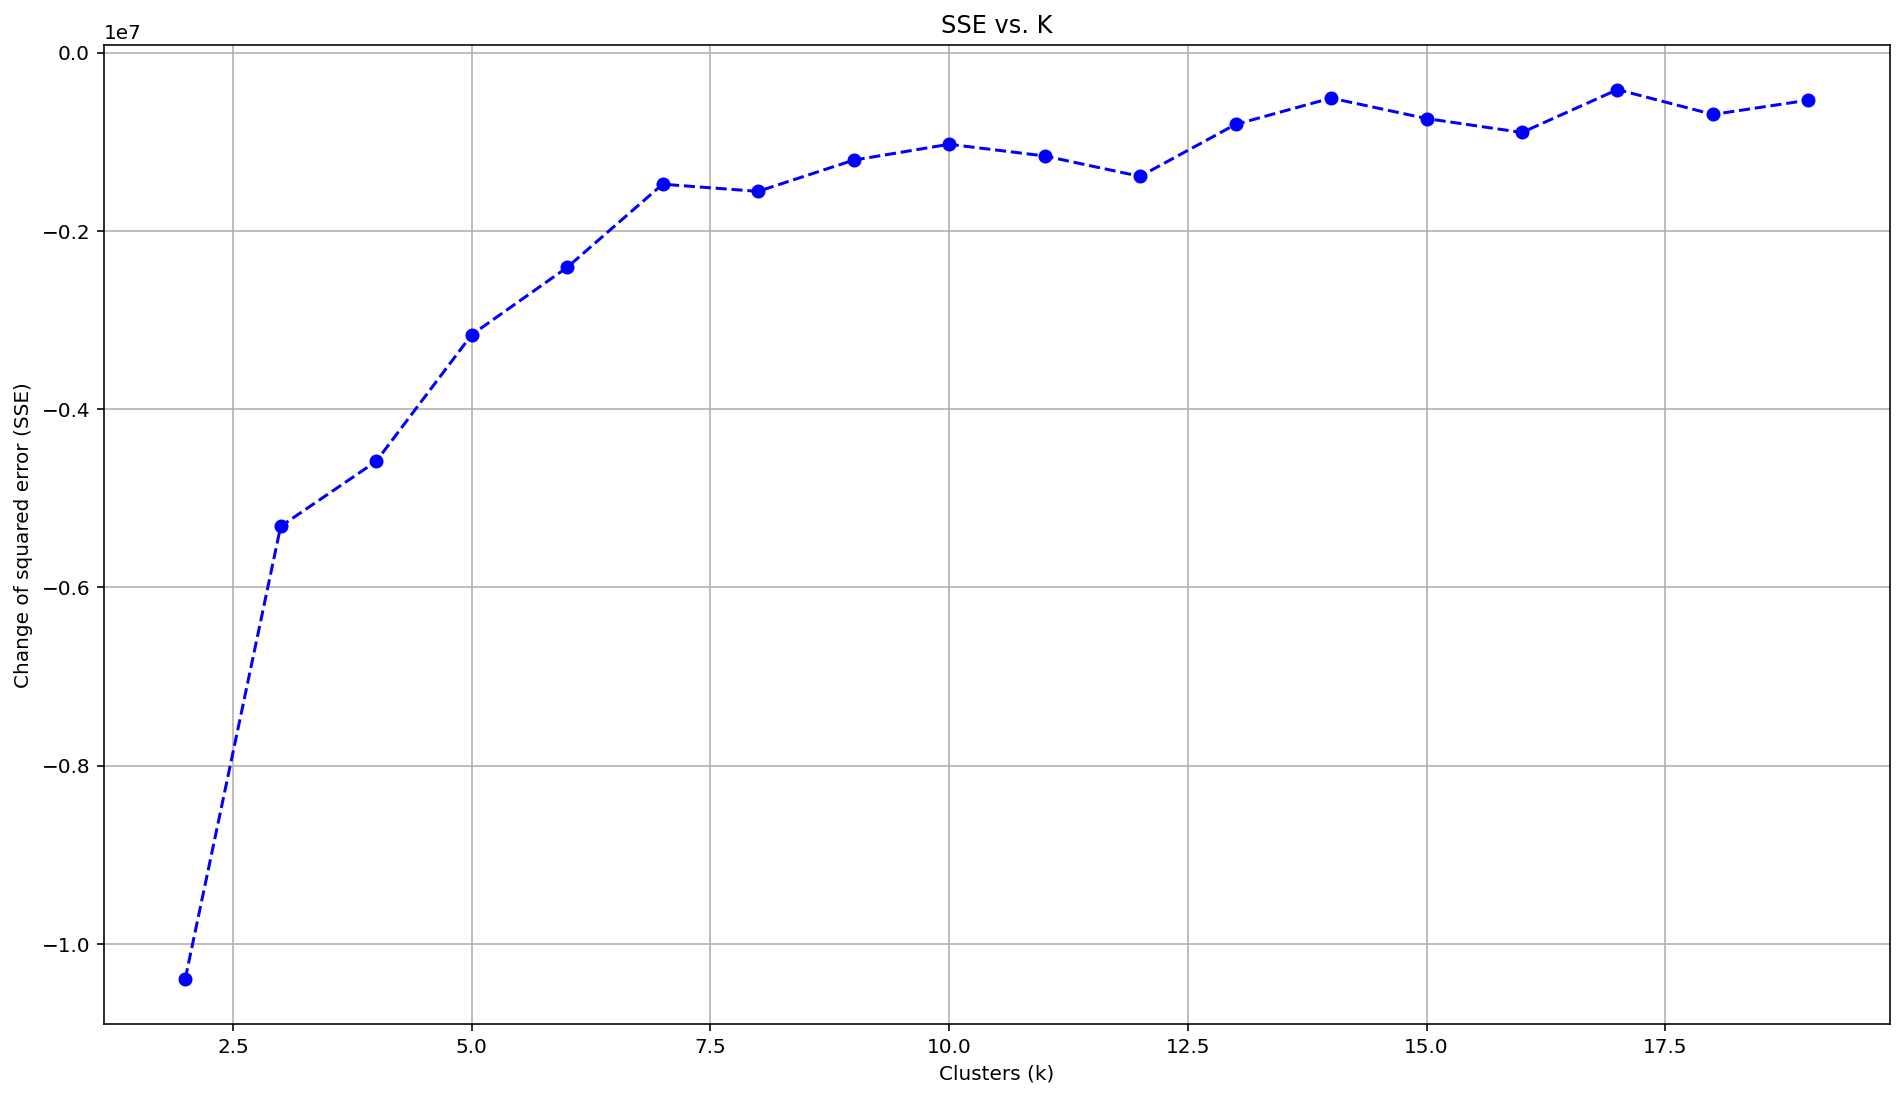

In [75]:
elbow_df = pd.DataFrame([kvalues, scores], index = ['k', 'score']).T
elbow_df['diff_socre'] = elbow_df['score'].diff()

plt.figure(figsize = (16, 9))
plt.plot(kvalues, elbow_df.diff_socre, linestyle='--', marker='o', color='b');
plt.grid(axis = 'x')
plt.grid(axis = 'y')
plt.xlabel('Clusters (k)');
plt.ylabel('Change of squared error (SSE)');
plt.title('SSE vs. K');

In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 7)
model = kmeans.fit(azdias_pca_df)
labels = model.predict(azdias_pca_df)

In [77]:
len(labels)

891221

In [78]:
azdias_pca_df.shape

(891221, 85)

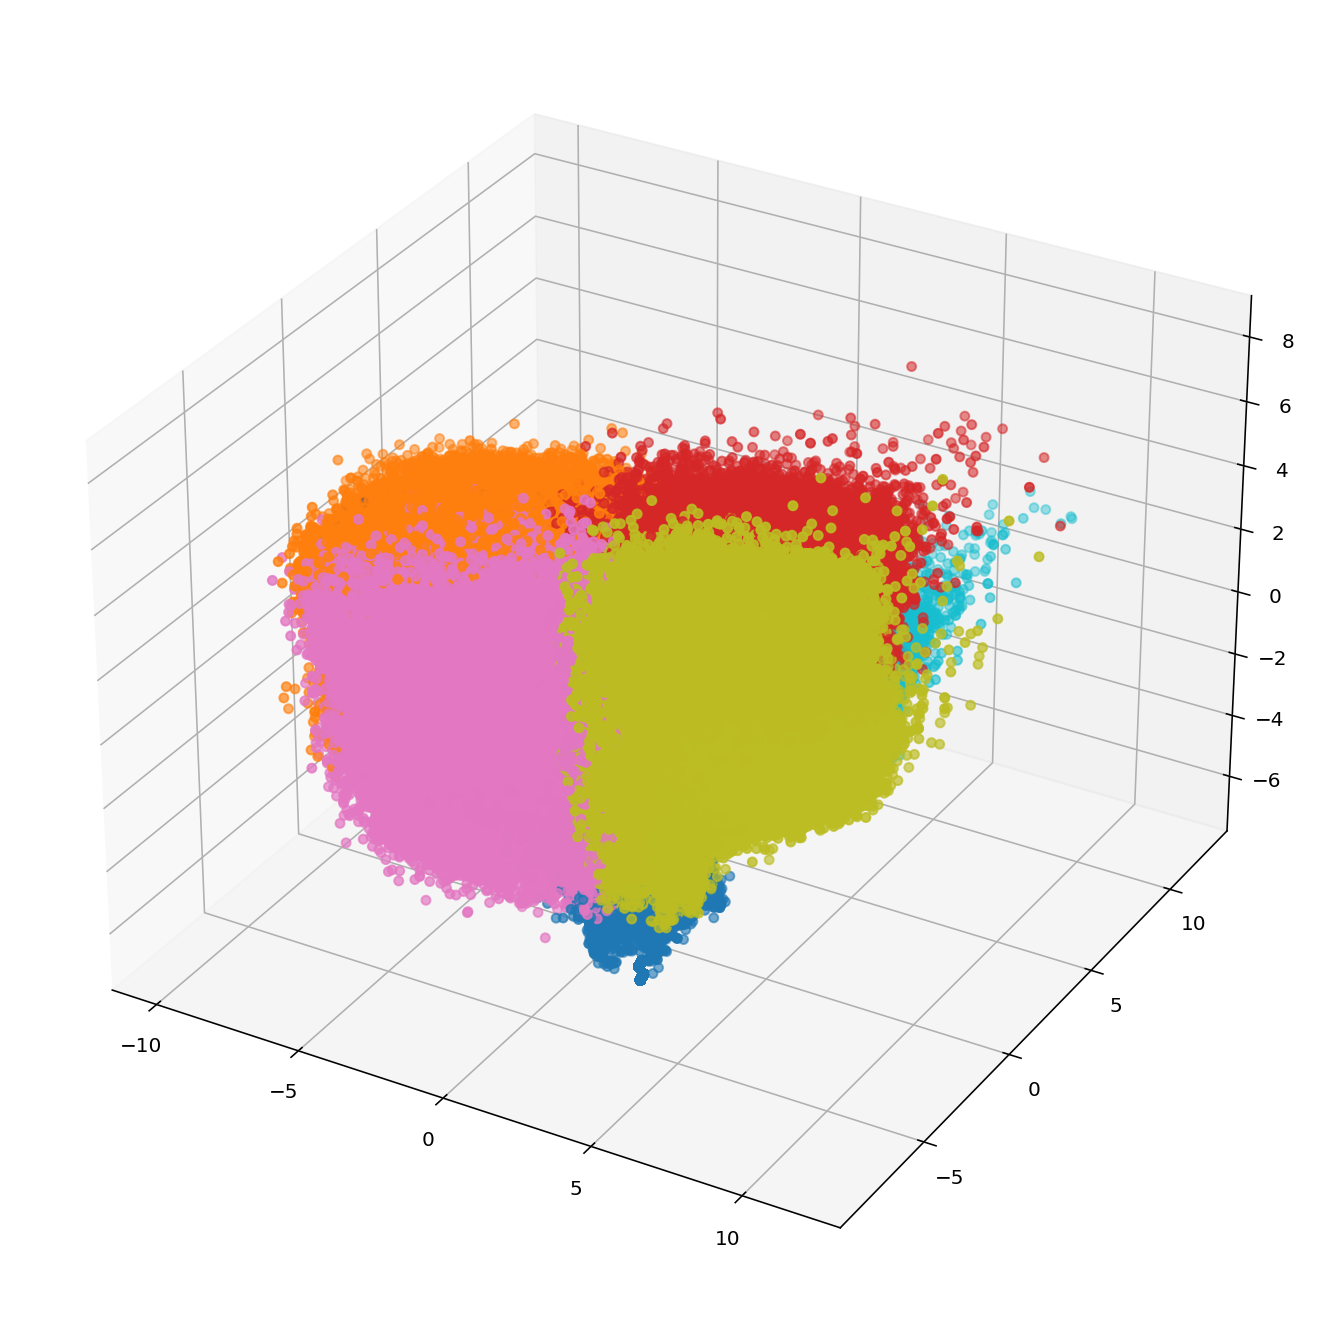

In [79]:
from mpl_toolkits.mplot3d import Axes3D

def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure(figsize = (16, 9));
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');
    plt.show()
    
plot_data(azdias_pca_df.values, labels)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

> We have tested 20 clusters to get the best number of clusters based on the SSE or the sum of squared errors.  We figured that when the number of K reached 7, the SSE has not a large difference, which implies the appropriate number of K.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

Converting column name: AGER_TYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ALTERSKATEGORIE_GROB


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ANREDE_KZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: CJT_GESAMTTYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZ_MINIMALIST


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZ_SPARER


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZ_VORSORGER


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZ_ANLEGER


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZ_UNAUFFAELLIGER


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZ_HAUSBAUER


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: FINANZTYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: GEBURTSJAHR


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: GFK_URLAUBERTYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: GREEN_AVANTGARDE


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: HEALTH_TYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: LP_LEBENSPHASE_FEIN


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: LP_LEBENSPHASE_GROB


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: LP_FAMILIE_FEIN


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: LP_FAMILIE_GROB


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: LP_STATUS_FEIN


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: LP_STATUS_GROB


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: NATIONALITAET_KZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PRAEGENDE_JUGENDJAHRE


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: RETOURTYP_BK_S


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_SOZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_FAM


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_REL


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_MAT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_VERT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_LUST


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_ERL


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_KULT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_RAT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_KRIT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_DOM


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_KAEM


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_PFLICHT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SEMIO_TRADV


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SHOPPER_TYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: SOHO_KZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: TITEL_KZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: VERS_TYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ZABEOTYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ALTER_HH


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ANZ_PERSONEN


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ANZ_TITEL


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: HH_EINKOMMEN_SCORE


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KK_KUNDENTYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: W_KEIT_KIND_HH


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: WOHNDAUER_2008


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ANZ_HAUSHALTE_AKTIV


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ANZ_HH_TITEL


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: GEBAEUDETYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KONSUMNAEHE


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: MIN_GEBAEUDEJAHR


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: OST_WEST_KZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: WOHNLAGE


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: CAMEO_DEUG_2015


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: CAMEO_DEU_2015


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: CAMEO_INTL_2015


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG1


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG2


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG3


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA05_ANTG4


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA05_BAUMAX


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA05_GBZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: BALLRAUM


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: EWDICHTE


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: INNENSTADT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: GEBAEUDETYP_RASTER


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KKK


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: MOBI_REGIO


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ONLINE_AFFINITAET


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: REGIOTYP


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: KBA13_ANZAHL_PKW


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG1


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG2


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG3


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_ANTG4


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_BAUMAX


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_HHZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: PLZ8_GBZ


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ARBEIT


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: ORTSGR_KLS9


  0%|          | 0/191652 [00:00<?, ?it/s]

Converting column name: RELAT_AB


  0%|          | 0/191652 [00:00<?, ?it/s]

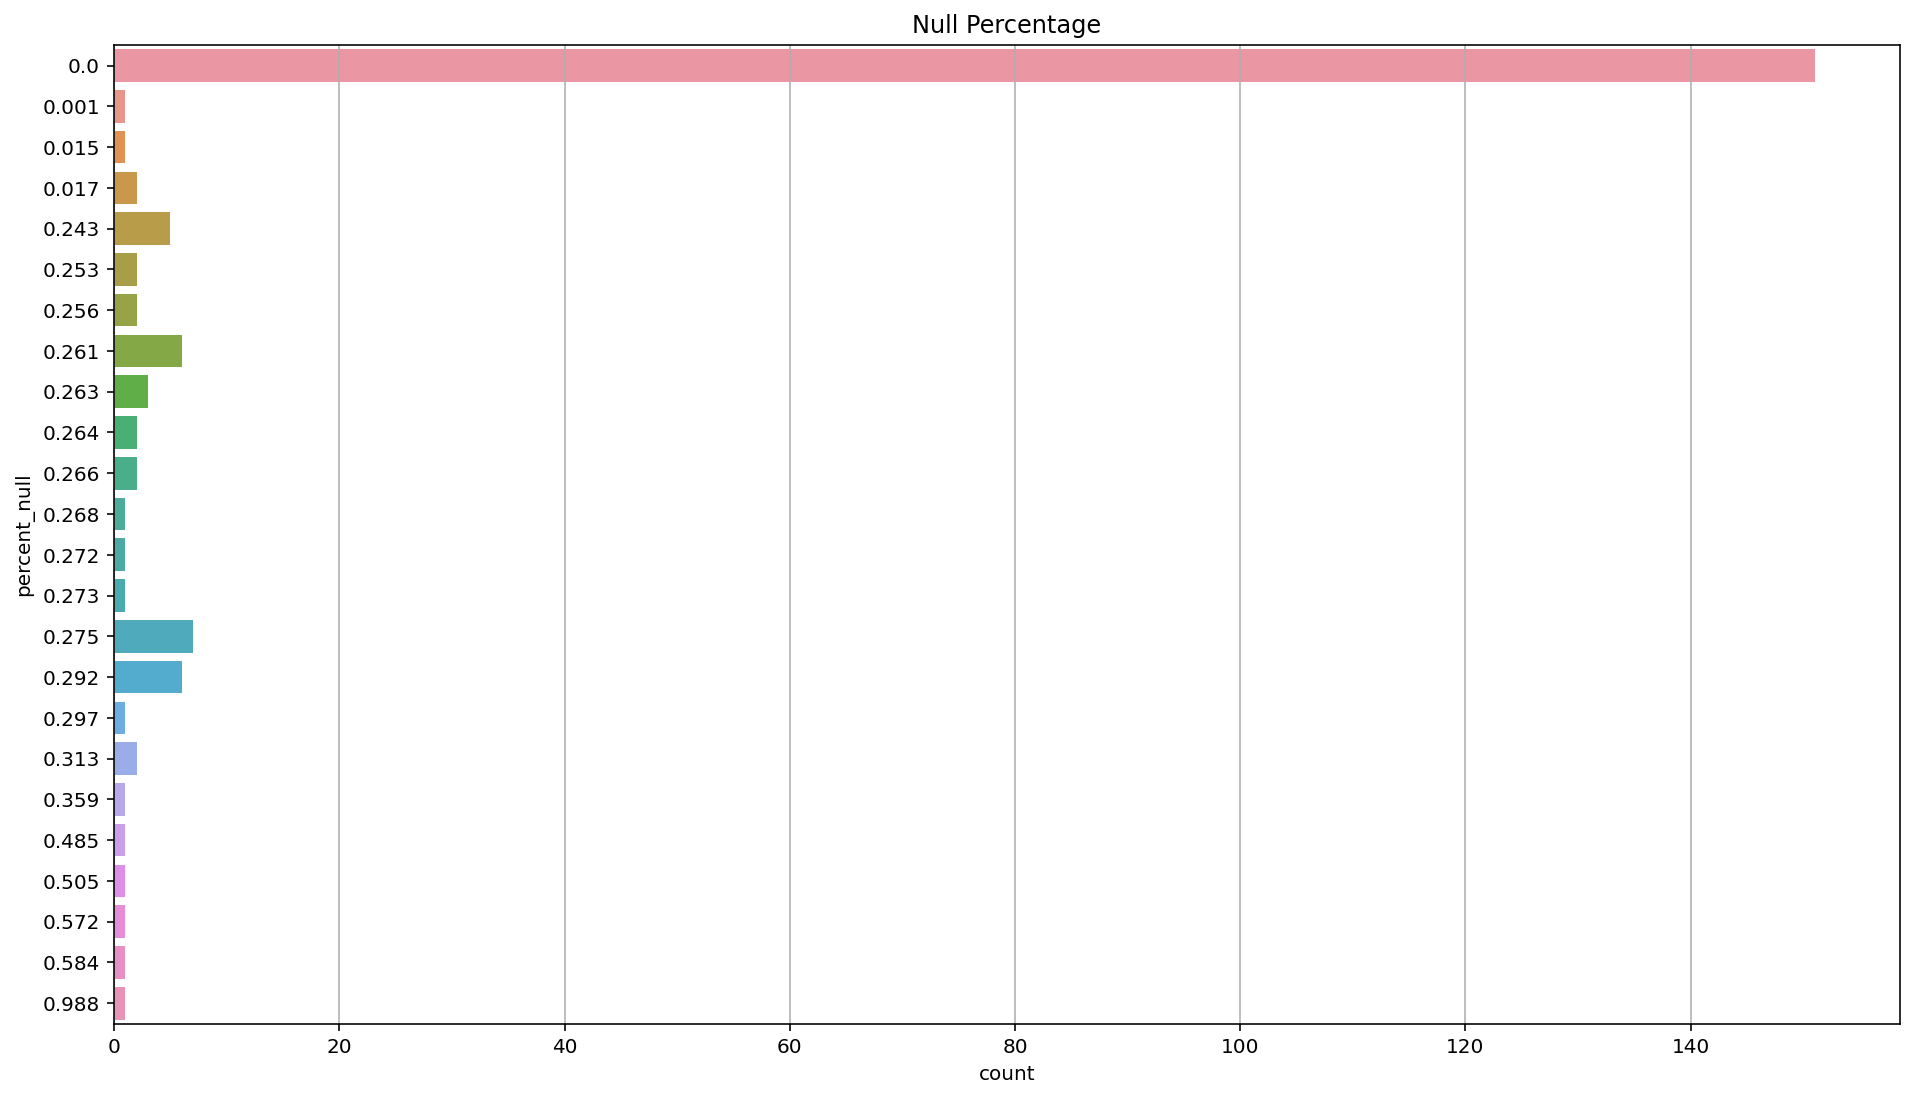

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  \
0            2.0                   4.0          1                  5   
1            NaN                   4.0          1                  5   
2            NaN                   4.0          2                  5   
3            1.0                   4.0          1                  5   
4            NaN                   3.0          1                  3   
...          ...                   ...        ...                ...   
191647       1.0                   3.0          1                  5   
191648       NaN                   4.0          2                  5   
191649       2.0                   4.0          1                  5   
191650       3.0                   3.0          2                  2   
191651       3.0                   2.0          1                  5   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   1                 5               1   
1                   1                 5               1   
2                   1                 5               1   
3                   1                 5               2   
4                   1                 4               4   
...               ...               ...             ...   
191647              1                 5               1   
191648              1                 5               2   
191649              1                 5               1   
191650              1                 5               1   
191651              1                 5               1   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  GEBURTSJAHR  ...  \
0                           2                 2          NaN  ...   
1                           3                 2          NaN  ...   
2                           4                 4          NaN  ...   
3                           1                 2          NaN  ...   
4                           5                 2       1960.0  ...   
...                       ...               ...          ...  ...   
191647                      1                 2          NaN  ...   
191648                      2                 3          NaN  ...   
191649                      1                 2       1944.0  ...   
191650                      2                 5          NaN  ...   
191651                      1                 2       1937.0  ...   

        CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ...   
191647                  0                  0                  0   
191648                  0                  0                  0   
191649                  0                  0                  0   
191650                  0                  0                  0   
191651                  0                  0                  0   

        CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ...   
191647                  0                  0                  0   
191648                  0                  0                  0   
191649                  0                  0                  0   
191650                  0                  0                  0   
191651                  0                  0                  0

In [80]:
# Load in the customer demographics data.

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';'))
customers

In [81]:
# remove columns not in general population data

column_match_drop = []
for column in customers.columns:
    if column not in azdias.columns:
        column_match_drop.append(column)
customers.drop(columns = column_match_drop, inplace = True)

In [82]:
# check if match

column_match_drop = []
for column in azdias.columns:
    if column not in customers.columns:
        column_match_drop.append(column)
column_match_drop

[]

In [83]:
customers_encode = customers.copy()

In [87]:
# filling NaN with most-frequent value

customers_encode_imputed = imputer.transform(customers_encode)
customers_encode_imputed = customers_encode_imputed[:, 0:196]

=> Total records: 191652
=> Null values: 0
=> Number of Duplicated values: 42439


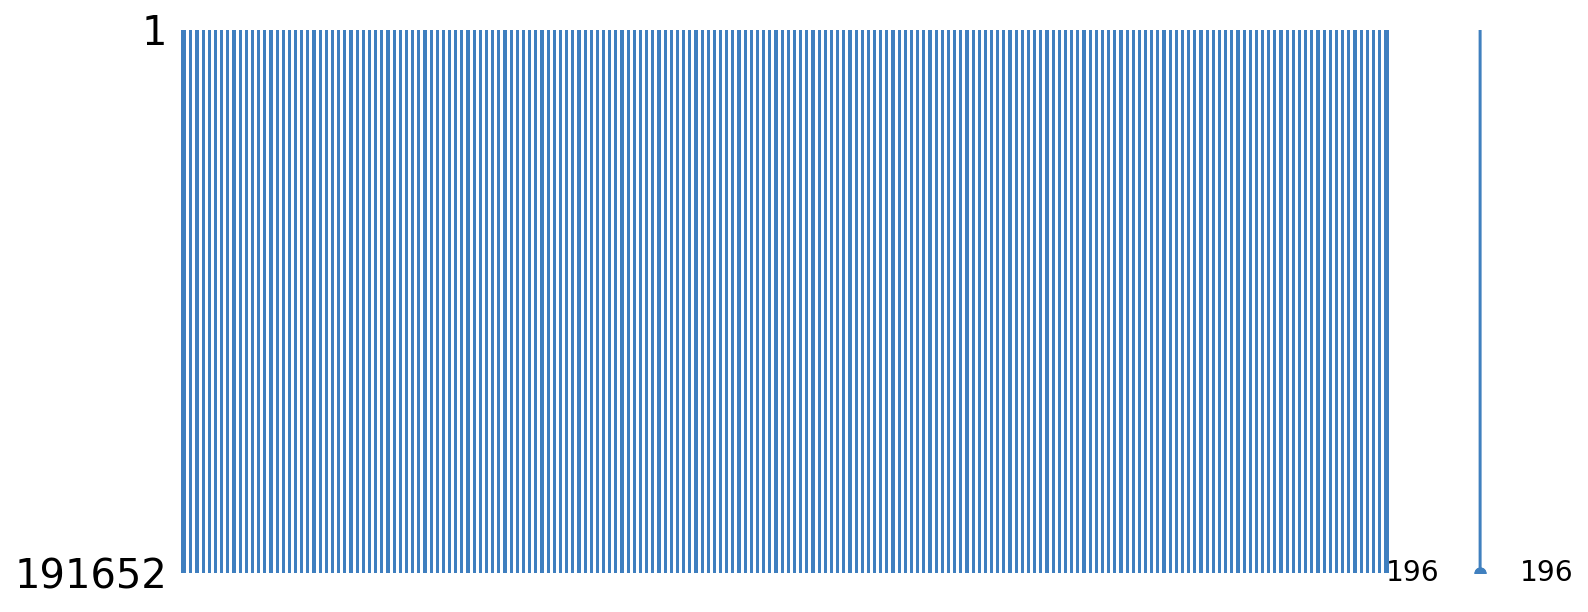

In [88]:
# check missing and duplicated data

df = pd.DataFrame(customers_encode_imputed)
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"=> Total records: {df.shape[0]}")
print(f"=> Null values: {df.isna().sum().sum()}")
print(f"=> Number of Duplicated values: {df.duplicated().sum()}")

In [89]:
# Apply feature scaling to the general population demographics data.

customers_encode_imputed_scaling = sc.transform(customers_encode_imputed)

In [90]:
# Apply PCA to the data.

customers_pca = pca.transform(customers_encode_imputed_scaling)

In [91]:
# cluster predictions for the general population demographics data.

labels_customers = model.predict(customers_pca)

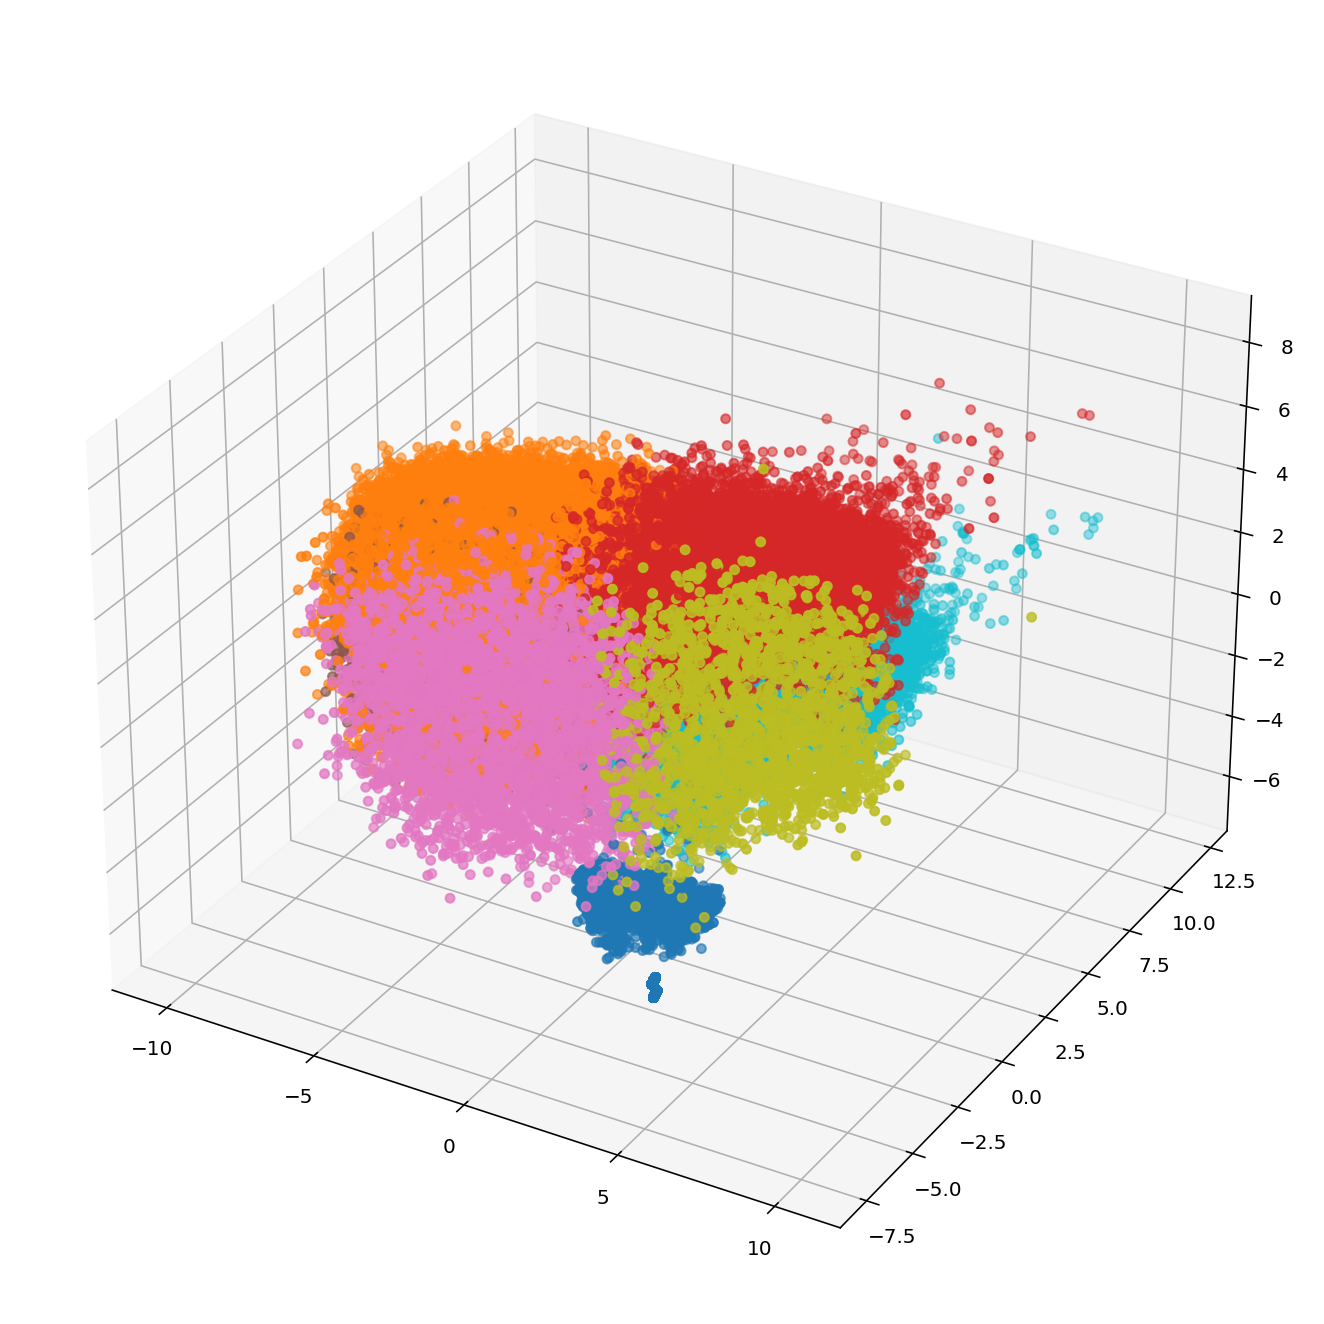

In [92]:
plot_data(customers_pca, labels_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. **If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company.** On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [116]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

General_Population_Label = pd.DataFrame(labels, columns = ['General Population'])
General_Population_Label_prop = General_Population_Label.value_counts(sort = False).values
General_Population_Label_prop = pd.DataFrame(General_Population_Label_prop, columns = ['General Population']).reset_index().rename(columns = {'index':'Label'})
General_Population_Label_prop['General Population Proportion'] = np.round(General_Population_Label_prop['General Population']/len(labels)*100, 1)

Customer_Data_Label = pd.DataFrame(labels_customers, columns = ['Customer Data'])
Customer_Data_Label_prop = Customer_Data_Label.value_counts(sort = False).values
Customer_Data_Label_prop = pd.DataFrame(Customer_Data_Label_prop, columns = ['Customer Data']).reset_index().rename(columns = {'index':'Label'})
Customer_Data_Label_prop['Customer Data Proportion'] = np.round(Customer_Data_Label_prop['Customer Data']/len(labels_customers)*100, 1)

label_prop = pd.merge(General_Population_Label_prop, Customer_Data_Label_prop, how = 'inner', on = 'Label')
label_prop['Proportion_diff'] = label_prop['General Population Proportion'] - label_prop['Customer Data Proportion']
diff = np.round(label_prop['Proportion_diff'].mean(), 2)
print(f'Proportion difference average: {diff}')
label_prop

Proportion difference average: 0.01


Label  General Population  General Population Proportion  Customer Data  \
0      0               75221                            8.4          46655   
1      1              119153                           13.4          63026   
2      2              127532                           14.3          19996   
3      3              146656                           16.5          36947   
4      4              142582                           16.0           5091   
5      5              152962                           17.2           2041   
6      6              127115                           14.3          17896   

   Customer Data Proportion  Proportion_diff  
0                      24.3            -15.9  
1                      32.9            -19.5  
2                      10.4              3.9  
3                      19.3             -2.8  
4                       2.7             13.3  
5                       1.1             16.1  
6                       9.3              5.0

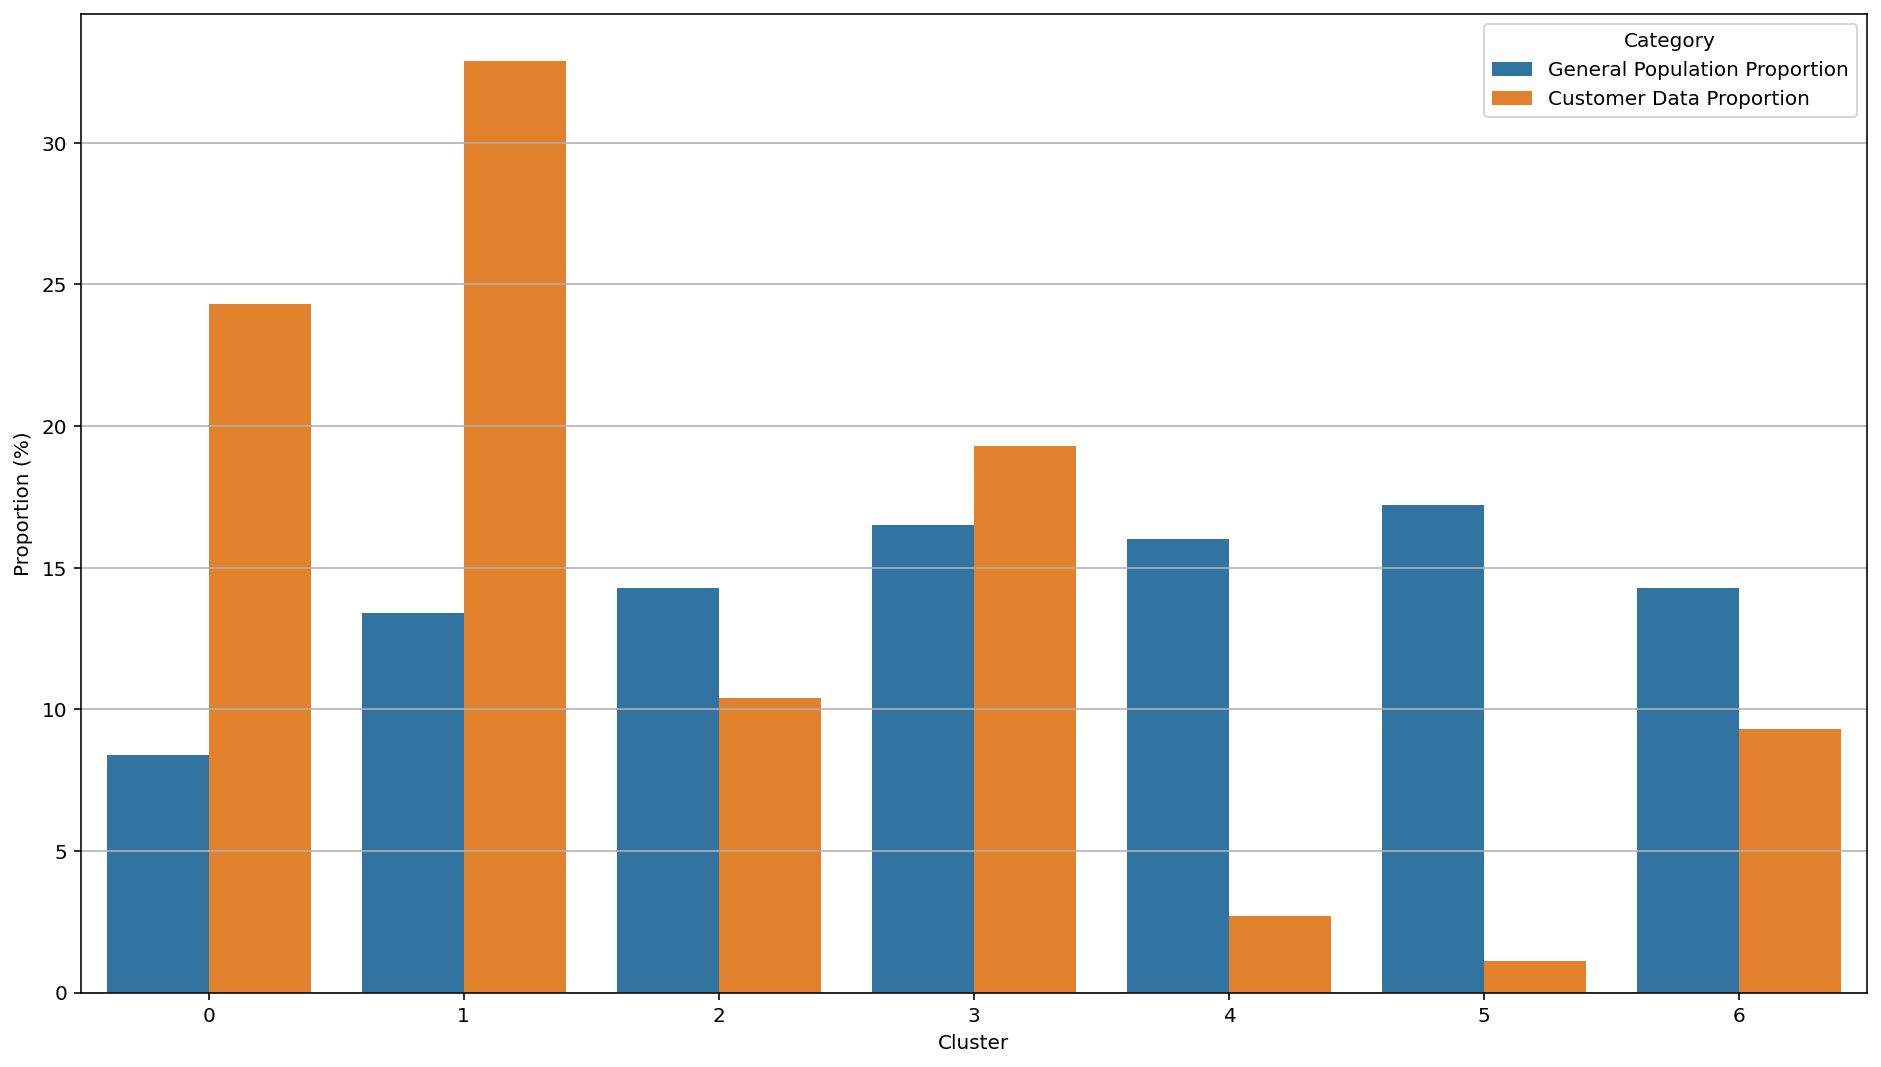

In [117]:
label_prop = label_prop[['Label', 'General Population Proportion', 'Customer Data Proportion']]
label_prop = label_prop.melt(id_vars = ['Label'], var_name = 'Category', value_name = 'Proportion')

plt.figure(figsize = (16, 9))
sb.barplot(data = label_prop, x = 'Label', y = 'Proportion', hue = 'Category');
plt.ylabel('Proportion (%)')
plt.xlabel('Cluster')
plt.grid(axis = 'y')
plt.show()

In [118]:
customers_pca_inverse = pca.inverse_transform(customers_pca)
customers_pca_scaling_inverse = sc.inverse_transform(customers_pca_inverse)
customers_pca_scaling_inverse = customers_pca_scaling_inverse.round(0).astype(int)
customers_inversed = imputer.inverse_transform(customers_pca_scaling_inverse)
customers_inversed = pd.DataFrame(data = customers_inversed, columns = customers.columns)
customers_inversed['label'] = labels_customers
customers_inversed

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        4.0        1.0                5.0            1.0   
1                        4.0        1.0                4.0            1.0   
2                        4.0        2.0                4.0            1.0   
3                        3.0        1.0                5.0            1.0   
4                        3.0        1.0                3.0            3.0   
...                      ...        ...                ...            ...   
191647                   3.0        1.0                4.0            2.0   
191648                   4.0        2.0                4.0            1.0   
191649                   4.0        1.0                5.0            1.0   
191650                   3.0        2.0                3.0            1.0   
191651                   2.0        1.0                5.0            2.0   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0                    5.0             1.0                    2.0   
1                    5.0             2.0                    3.0   
2                    5.0             1.0                    2.0   
3                    5.0             2.0                    1.0   
4                    4.0             2.0                    3.0   
...                  ...             ...                    ...   
191647               5.0             1.0                    3.0   
191648               5.0             2.0                    2.0   
191649               5.0             1.0                    1.0   
191650               5.0             2.0                    2.0   
191651               4.0             2.0                    1.0   

        FINANZ_HAUSBAUER  GREEN_AVANTGARDE  HEALTH_TYP  ...  \
0                    3.0               1.0         1.0  ...   
1                    3.0               0.0         1.0  ...   
2                    3.0               1.0         2.0  ...   
3                    2.0               0.0         1.0  ...   
4                    3.0               0.0         2.0  ...   
...                  ...               ...         ...  ...   
191647               2.0               1.0         3.0  ...   
191648               3.0               0.0         2.0  ...   
191649               3.0               1.0         1.0  ...   
191650               4.0               0.0         2.0  ...   
191651               2.0               0.0         2.0  ...   

        CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  \
0                     0.0                0.0                0.0   
1                     0.0                0.0                0.0   
2                     0.0                0.0                0.0   
3                     0.0                0.0                0.0   
4                     0.0                0.0                0.0   
...                   ...                ...                ...   
191647                0.0                0.0                0.0   
191648                0.0                0.0                0.0   
191649                0.0                0.0                0.0   
191650                0.0                0.0                0.0   
191651                0.0                0.0                0.0   

        CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DECADE  \
0                     0.0                0.0                           NaN   
1                     0.0                0.0                           NaN   
2                     0.0                0.0                           NaN   
3                     0.0                0.0                           NaN   
4                     0.0                0.0                           NaN   
...                   ...                ...                           ...   
191647                0.0                0.0                           NaN   
191648                0.0                0.0                           NaN   
191649        

In [119]:
filter_mask_over = (customers_inversed['label'] == 1) 
filter_mask_under = (customers_inversed['label'] == 4)

overrepresented = customers_inversed[filter_mask_over]
underrepresented = customers_inversed[filter_mask_under]

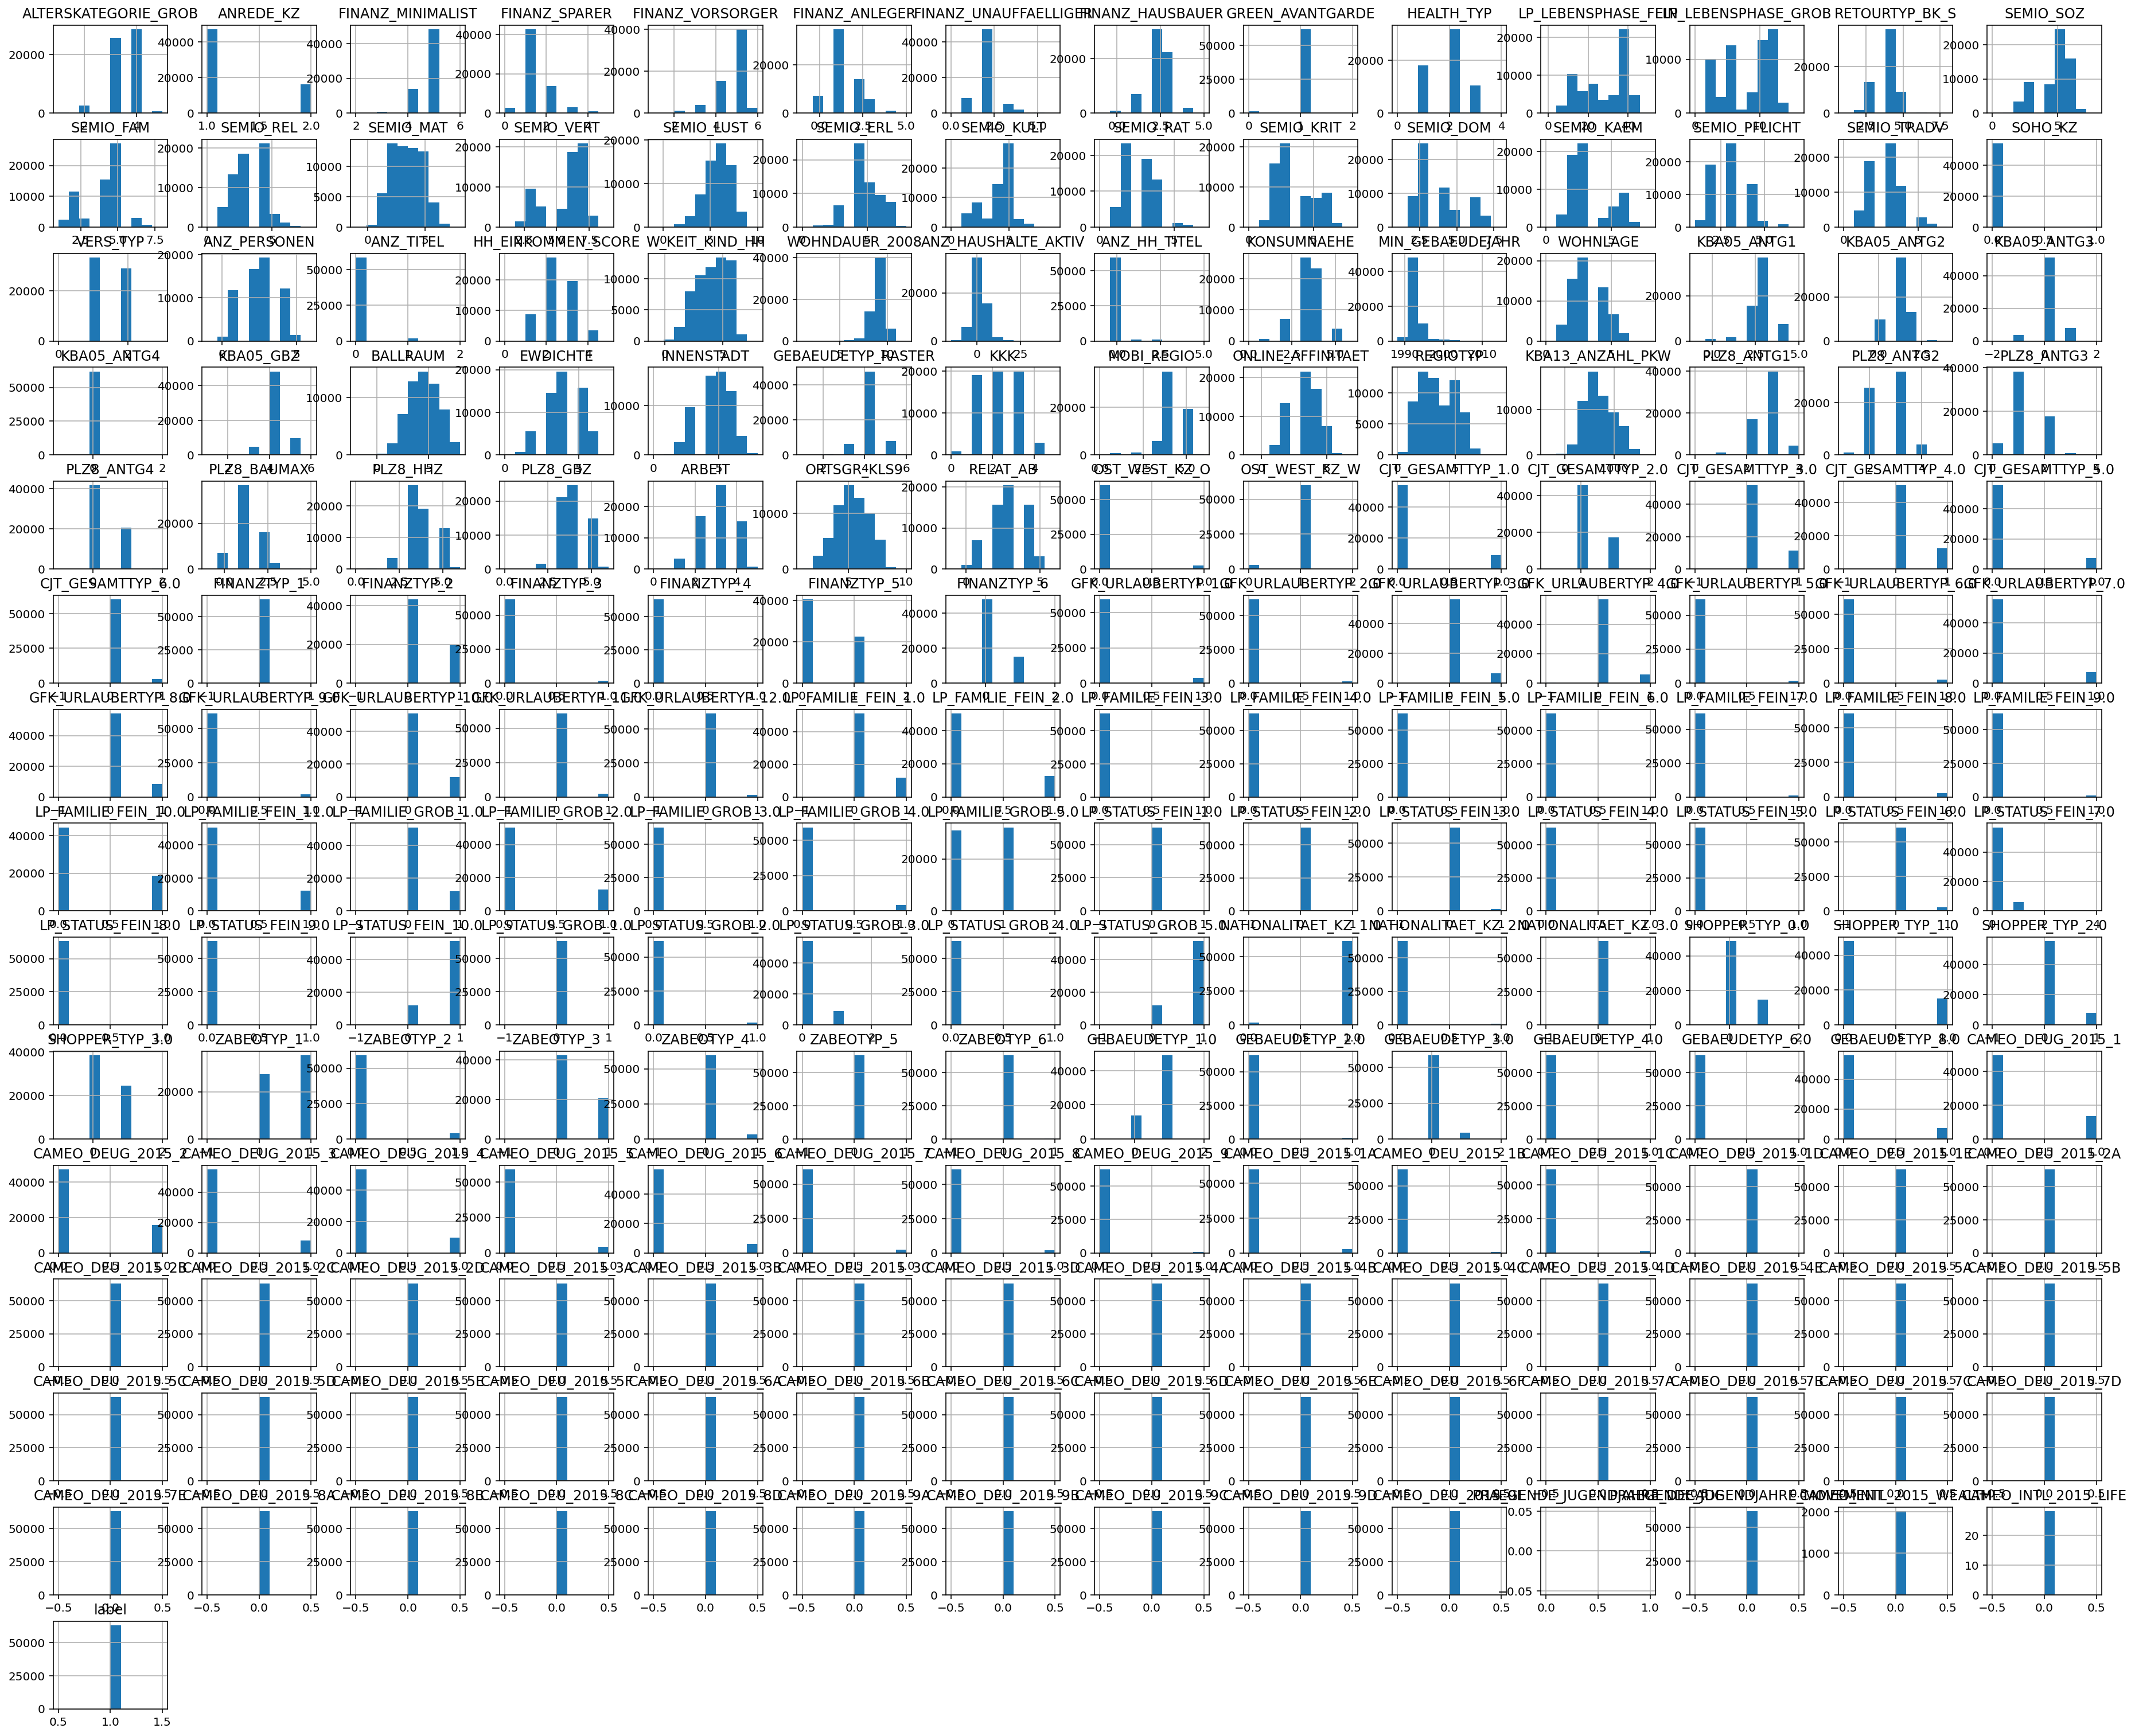

In [120]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

fig = plt.figure(figsize = (32,27))
ax = fig.gca()
overrepresented.hist(ax = ax);

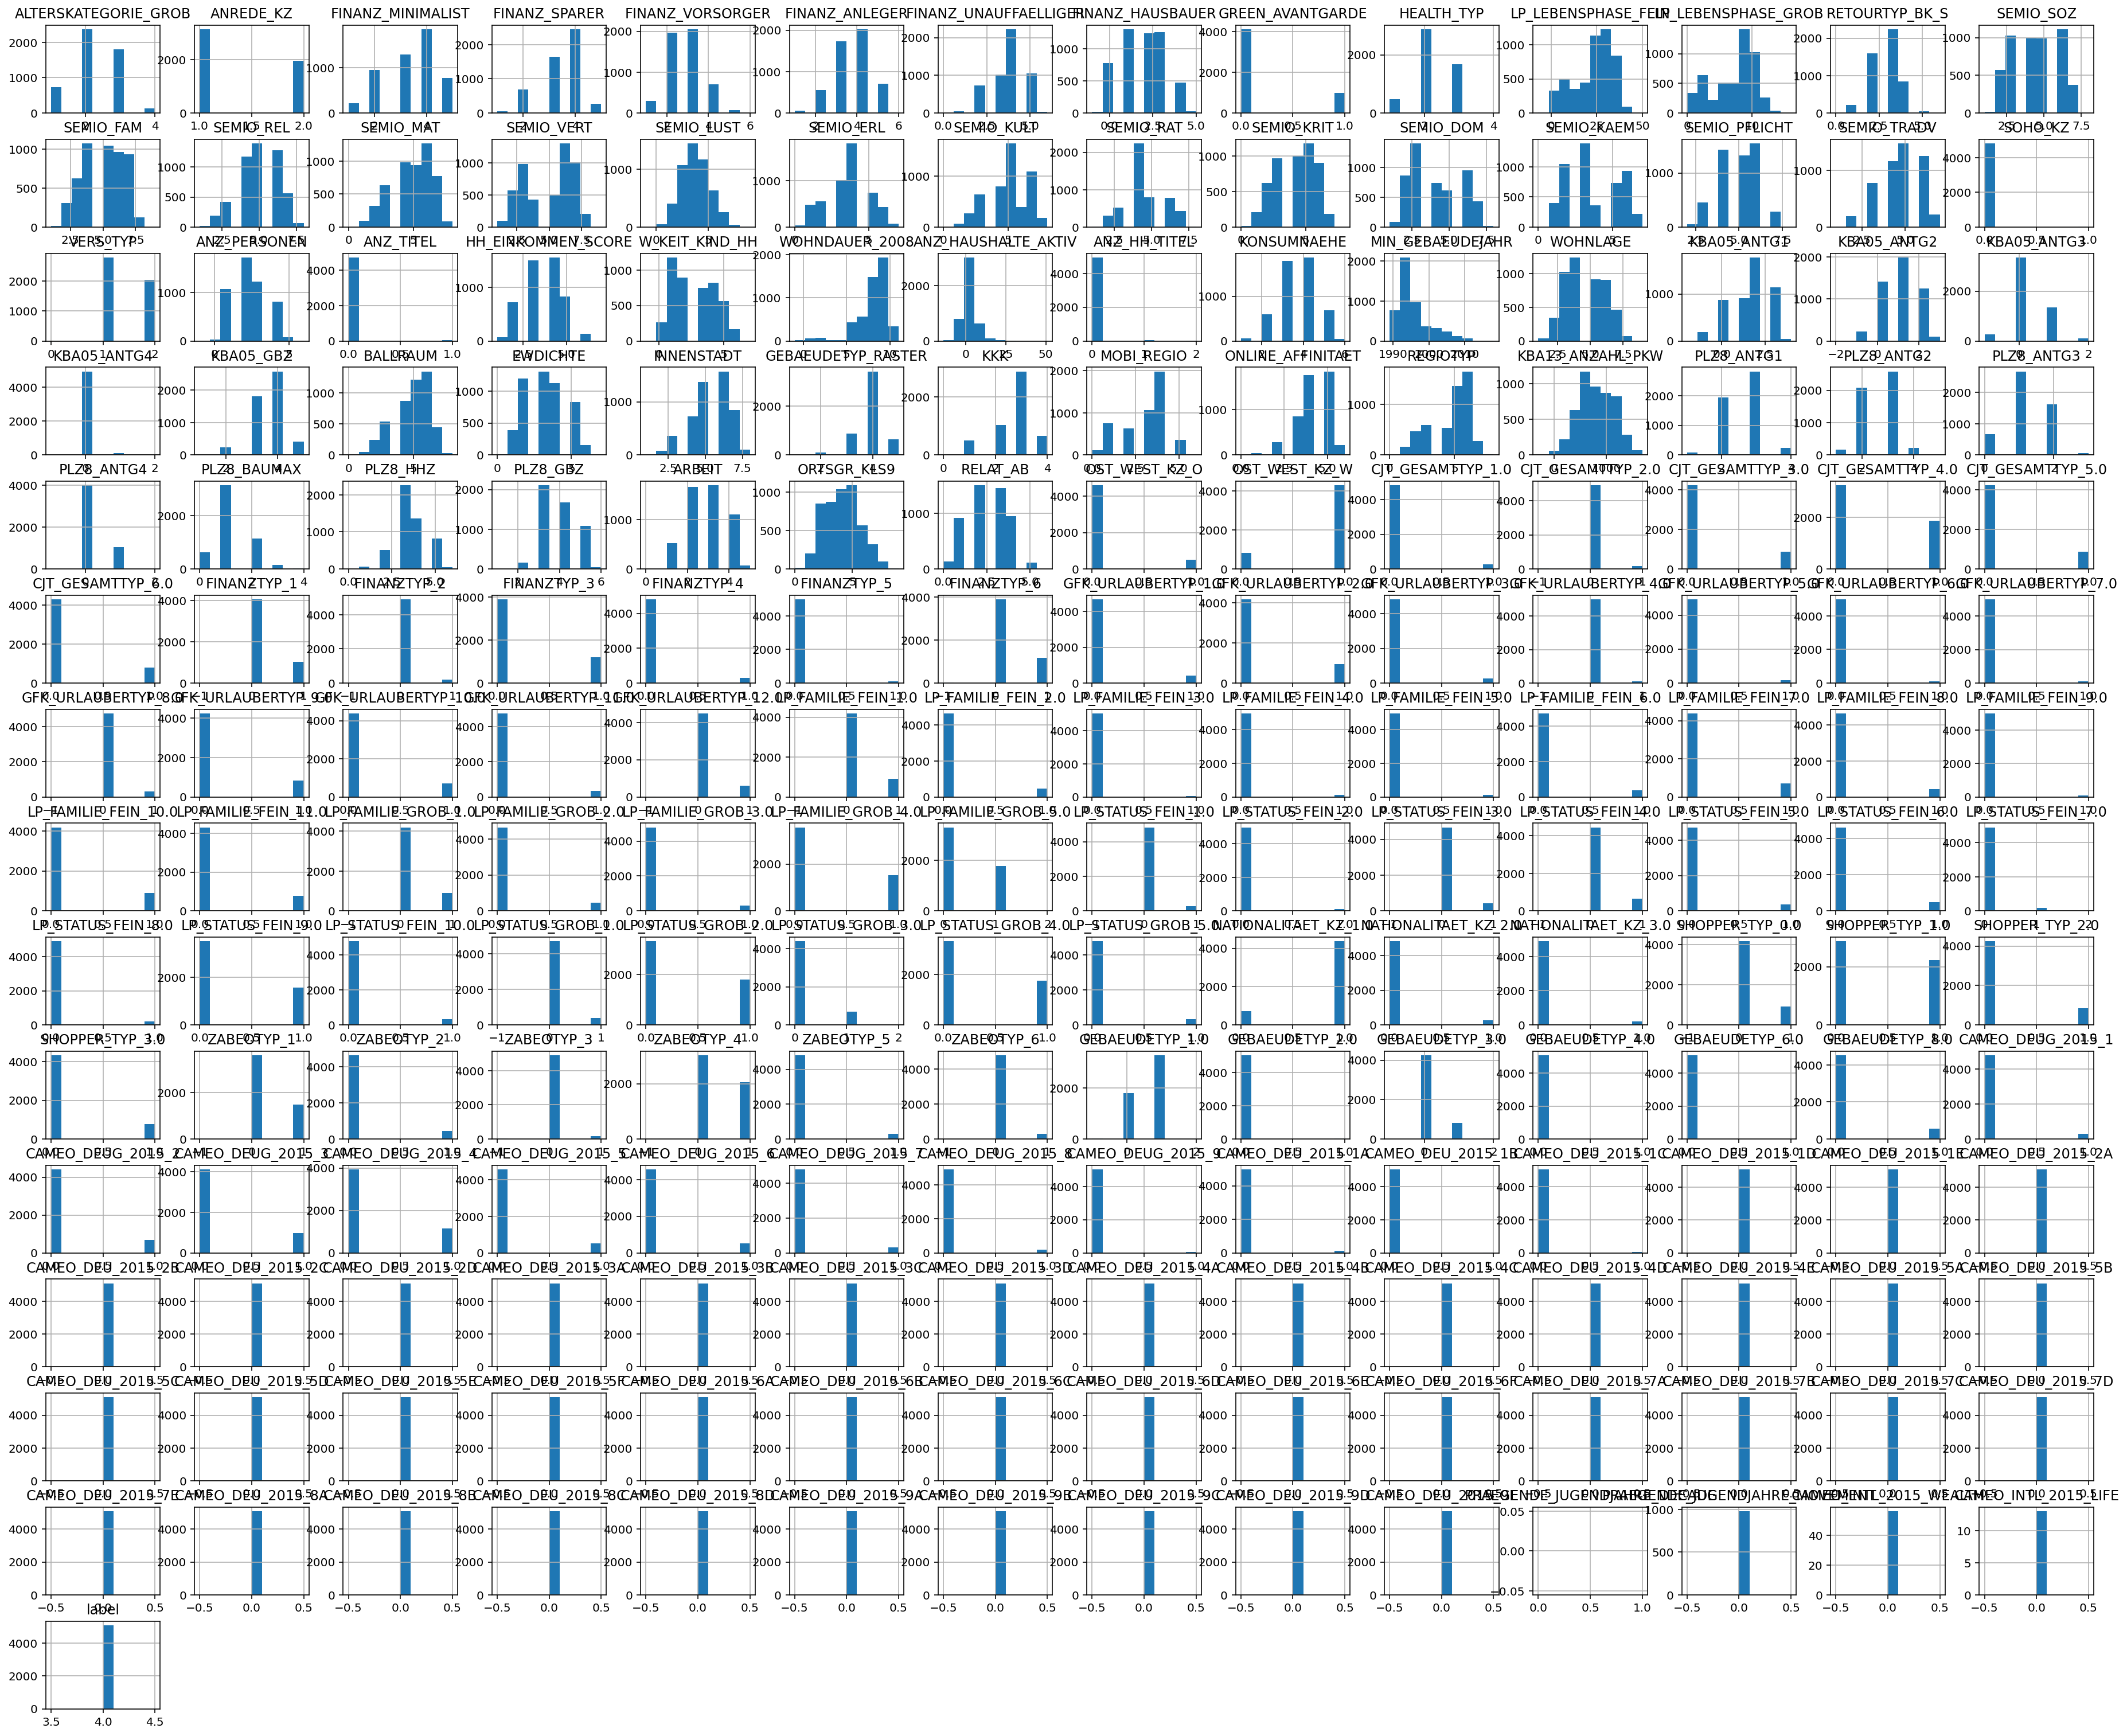

In [121]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

fig = plt.figure(figsize = (32,27))
ax = fig.gca()
underrepresented.hist(ax = ax);

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> We have compared each segment to check if there is any group that is qualitatively different from the main bulk of the data. The average difference of each proportion between the general population data and the customer data is not significantly different. There are three clusters having a higher proportion of persons in a cluster compared to the general population, and four clusters in the other cases. Looking into the attributes of the cluster labeled as 0 and 1 which are relatively popular with the mail-order company or overrepresented, most people are senior citizens having low income and money savers with low affinity, and located a far distance from the nearest urban center. In contrast, the opposite group, which is labeled as 4 and 5, are mostly younger than 60 years old females having a high income, prefer investing, and are located near the urban center. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.